# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics

## How to use this notebook

### Local installation

1. Install required packages with `pip install -r requirements.txt` to your desired environment.
2. If a script version of this notebook is desired, comment (not uncomment) the first line of `nbconvert` cell.

### Colab installation

1.  Comment (not uncomment) the first line of the drive mounting cell.
2.  Comment (not uncomment) the first line of the `pip install` cell.

<!-- - For colab we also want to set the runtime to GPU by clicking _Change runtime_ in the _Runtime_ menu, and -->
<!-- - We want to wait for the google drive connection popup to appear and follow the instructions. -->

### Loading / Generating data
3. Set `LOAD_DATA_FROM_CSV` to `True` / `False` to load data from csv files / generate data in this notebook.

### Training without optimization

4. Set `OPTIMIZE = False` in section _Constants and flags to set_.
5. Run the entire notebook.

### Training with optimization

4. Set `OPTIMIZE = True` in section _Constants and flags to set_.
5. Run the entire notebook.

### Loading an already trained model

4. Run cells in section _Initialization_.
5. Run cells with definitions in section _Input data and labels_.
6. Run cell with the definition of _Net_ in section _Defining the neural network_.
7. Make sure the `net.pth`, `optimizer.pth`, `scheduler.pth`, `var_dict.json` and `train_output.csv` files are in the directory containing this notebook.
8. Run the cells in section _Loading_ and continue from there.

### Generating the C++ model

9. Run section _Porting the model to C++_, this requires a model to be loaded.
10. Set the path to the `net.pt` file in the C++ source file.
11. `mkdir build && cd build`,
12. Configure a `CMakeLists.txt` file as is done [here](https://pytorch.org/cppdocs/installing.html).
13. `cmake -DCMAKE_PREFIX_PATH=/path/to/libtorch/ ..`,
14. Compile and run, e.g. `cmake --build . --config release && ./<executable name>`

## Initialization


Use this first cell to **convert this notebook** to a python script.

In [ ]:
%%script echo skipping

!jupyter nbconvert pt1_before_restructuring.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on **google colab**,

In [ ]:
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")
# change this to your desired folder
drive_folder = "/content/drive/My Drive/bsc/con2prim_GRMHD/1e5_runs"

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [ ]:
# %%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing the **libraries**,

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx
import pandas as pd

### Constants and flags to set
Defining some constants and parameters for convenience.

**NOTE**: Some **subparameters** still need to be adjusted in the `create_model` function itself as of (Tue May 16 07:42:45 AM CEST 2023) in the case the model is being trained without optimization.

In [ ]:

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_TRIALS = 200 # Number of trials for hyperparameter optimization # NOTE: Set this properly.
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values. # NOTE: Set this properly.
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.
LOAD_DATA_FROM_CSV = False  # If not true we generate the data in this file and save to {x_train,y_train,x_test,y_test}.csv, otherwise we load the data from files of the same name. # NOTE: Set this before properly.

csv_filenames = { # File names to load input data and labels from if LOAD_DATA_FROM_CSV is True.
    "x_train": "x_train.csv",
    "x_val": "x_val.csv",
    "x_test": "x_test.csv",
    "y_train": "y_train.csv",
    "y_val": "y_val.csv",
    "y_test": "y_test.csv",
}

# Values to use for hyperparameters if OPTIMIZE is False; set these to the best parameters found by Optuna.
# NOTE: TODO: Currently (Sat May 27 05:16:57 PM CEST 2023) there are still subparameters to be set in create_model function.
N_LAYERS_NO_OPT = 3
N_UNITS_NO_OPT = [555, 458, 115]
HIDDEN_ACTIVATION_NAME_NO_OPT = "LeakyReLU"
OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
LOSS_NAME_NO_OPT = "Huber"
OPTIMIZER_NAME_NO_OPT = "RMSprop"
LR_NO_OPT = 0.000122770896701404
BATCH_SIZE_NO_OPT = 49
N_EPOCHS_NO_OPT = 400 # NOTE: Set this properly.
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"
DROPOUT_RATE_NO_OPT = 0.2

N_INPUTS = 14  # Number of input features.
N_OUTPUTS = 1  # Number of outputs.
Gamma = 5/3  # Adiabatic index

n_samples = 1e5 # NOTE: Set this properly.
train_frac = 0.7  # 70% of data for training
val_frac = 0.15  # 15% of data for validation, rest for testing

rho_interval = (0, 2) 
epsilon_interval = (1e-2, 2000)  # Will be sampled in log space
vx_interval = (0, 0.999)  
vy_interval = (0, 0.999)  
vz_interval = (0, 0.999)  
Bx_interval = (-10, 10)  
By_interval = (-10, 10)  
Bz_interval = (-10, 10)  
gxx_interval = (0.9, 1.1)
gxy_interval = (0, 0.1)
gxz_interval = (0, 0.1)
gyy_interval = (0.9, 1.1)
gyz_interval = (0, 0.1)
gzz_interval = (0.9, 1.1)

np.random.seed(61) # Comment for true random data.


## Input data and labels

We either generate the data or load the data. First the definitions for generating the data come below.

In [ ]:
# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    # Adding some assertions to check that the input tensors are valid and have 
    # the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    print('rho.shape: ', rho.shape)
    print('epsilon.shape: ', epsilon.shape)
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (Gamma - 1) * rho * epsilon

def sample_primitive_variables_and_metric():
    rho = np.random.uniform(*rho_interval)  
    epsilon = np.random.uniform(*np.log10(epsilon_interval))
    vx = np.random.uniform(*vx_interval)  
    vy = np.random.uniform(*vy_interval)  
    vz = np.random.uniform(*vz_interval)  
    Bx = np.random.uniform(*Bx_interval)  
    By = np.random.uniform(*By_interval)  
    Bz = np.random.uniform(*Bz_interval)  
    gxx = np.random.uniform(*gxx_interval)
    gxy = np.random.uniform(*gxy_interval)
    gxz = np.random.uniform(*gxz_interval)
    gyy = np.random.uniform(*gyy_interval)
    gyz = np.random.uniform(*gyz_interval)
    gzz = np.random.uniform(*gzz_interval)

    return rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz

def check_sample(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    wtemp_expr = 1 - (gxx * vx**2 + gyy * vy**2 + gzz * vz**2 + 2 * gxy * vx * vy + 2 * gxz * vx * vz + 2 * gyz * vy * vz)
    sdet_expr = gxx * gyy * gzz + 2 * gxy * gxz * gyz - gxx * gyz ** 2 - gyy * gxz ** 2 - gzz * gxy ** 2
    if vx**2 + vy**2 + vz**2 >= 1 or wtemp_expr < 0 or sdet_expr < 0:
        # print(f"Sample failed checks. vx^2+vy^2+vz^2: {vx**2 + vy**2 + vz**2}, wtemp_expr: {wtemp_expr}, sdet_expr: {sdet_expr}")
        return False
    else:
        # print(f"Sample passed checks. vx^2+vy^2+vz^2: {vx**2 + vy**2 + vz**2}, wtemp_expr: {wtemp_expr}, sdet_expr: {sdet_expr}")
        return True

def generate_samples(n_samples):
    samples = []
    while len(samples) < n_samples:
        sample = sample_primitive_variables_and_metric()
        if check_sample(*sample):
            samples.append(sample)
        # print(f"Number of valid samples: {len(samples)}")
    return zip(*samples)
def sdet(gxx, gxy, gxz, gyy, gyz, gzz):
    # Determinant of the three metric.
    return (gxx * gyy * gzz + 2 * gxy * gxz * gyz - gxx * gyz ** 2 - gyy * gxz ** 2 - gzz * gxy ** 2) ** 0.5

# Defining a function that computes conserved variables from primitive variables and the metric
# We follow the source code of GRaM-X: A new GPU-accelerated dynamical spacetime GRMHD code for Exascale
# computing with the Einstein Toolkit of Shankar et al.
def compute_conserved_variables(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    pres = eos_analytic(rho, epsilon)
    wtemp = 1 / (1 - (gxx * vx**2 + gyy * vy**2 + gzz * vz**2 +
        2 * gxy * vx * vy + 2 * gxz * vx * vz +
        2 * gyz * vy * vz))**0.5

    vlowx = gxx * vx + gxy * vy + gxz * vz
    vlowy = gxy * vx + gyy * vy + gyz * vz
    vlowz = gxz * vx + gyz * vy + gzz * vz

    Bxlow = gxx * Bx + gxy * By + gxz * Bz
    Bylow = gxy * Bx + gyy * By + gyz * Bz
    Bzlow = gxz * Bx + gyz * By + gzz * Bz

    B2 = Bxlow * Bx + Bylow * By + Bzlow * Bz

    Bdotv = Bxlow * vx + Bylow * vy + Bzlow * vz
    Bdotv2 = Bdotv * Bdotv
    wtemp2 = wtemp * wtemp
    b2 = B2 / wtemp2 + Bdotv2
    ab0 = wtemp * Bdotv

    blowx = (gxx * Bx + gxy * By + gxz * Bz) / wtemp + wtemp * Bdotv * vlowx
    blowy = (gxy * Bx + gyy * By + gyz * Bz) / wtemp + wtemp * Bdotv * vlowy
    blowz = (gxz * Bx + gyz * By + gzz * Bz) / wtemp + wtemp * Bdotv * vlowz

    hrhow2 = (rho * (1 + epsilon) + pres + b2) * (wtemp) * (wtemp)

    D = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * rho * (wtemp)
    Sx = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowx - ab0 * blowx)
    Sy = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowy - ab0 * blowy)
    Sz = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 * vlowz - ab0 * blowz)
    tau = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * (hrhow2 - pres - b2 / 2 - ab0 * ab0) - D
    Bconsx = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * Bx
    Bconsy = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * By
    Bconsz = sdet(gxx, gxy, gxz, gyy, gyz, gzz) * Bz

    return D, Sx, Sy, Sz, tau, Bconsx, Bconsy, Bconsz

def generate_input_data(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz):
    rho = torch.tensor(np.array(rho), dtype=torch.float32).to(device)
    epsilon = torch.tensor(np.array(epsilon), dtype=torch.float32).to(device)
    vx = torch.tensor(np.array(vx), dtype=torch.float32).to(device)
    vy = torch.tensor(np.array(vy), dtype=torch.float32).to(device)
    vz = torch.tensor(np.array(vz), dtype=torch.float32).to(device)
    Bx = torch.tensor(np.array(Bx), dtype=torch.float32).to(device)
    By = torch.tensor(np.array(By), dtype=torch.float32).to(device)
    Bz = torch.tensor(np.array(Bz), dtype=torch.float32).to(device)
    gxx = torch.tensor(np.array(gxx), dtype=torch.float32).to(device)
    gxy = torch.tensor(np.array(gxy), dtype=torch.float32).to(device)
    gxz = torch.tensor(np.array(gxz), dtype=torch.float32).to(device)
    gyy = torch.tensor(np.array(gyy), dtype=torch.float32).to(device)
    gyz = torch.tensor(np.array(gyz), dtype=torch.float32).to(device)
    gzz = torch.tensor(np.array(gzz), dtype=torch.float32).to(device)

    D, Sx, Sy, Sz, tau, Bscriptx, Bscripty, Bscriptz = compute_conserved_variables(
        rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz
    ) 

    # Add gxx, gxy, gxz, gyy, gyz, gzz to the tensor
    x = torch.stack([D, Sx, Sy, Sz, tau, Bscriptx, Bscripty, Bscriptz, gxx, gxy, gxz, gyy, gyz, gzz], axis=1)
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
# We use the definitions as given in Recovery schemes for primitive variables in
# general-relativistic magnetohydrodynamics of Siegel et al.
def generate_labels(rho, epsilon, vx, vy, vz):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(np.array(rho), dtype=torch.float32).to(device)
    epsilon = torch.tensor(np.array(epsilon), dtype=torch.float32).to(device)
    vx = torch.tensor(np.array(vx), dtype=torch.float32).to(device)
    vy = torch.tensor(np.array(vy), dtype=torch.float32).to(device)
    vz = torch.tensor(np.array(vz), dtype=torch.float32).to(device)

    # Computing the required quantities
    pres = eos_analytic(rho, epsilon)
    h = 1 + epsilon + pres / rho
    W = 1 / torch.sqrt(1 - (vx * vx + vy * vy + vz * vz))

    # Returning the output data tensor
    return h * W

### Generating or loading input data and labels

In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

In [ ]:
if LOAD_DATA_FROM_CSV:
    # Load the data from CSV files
    x_train = pd.read_csv(csv_filenames["x_train"]).values
    y_train = pd.read_csv(csv_filenames["y_train"]).values.squeeze()  # reshape to 1D
    x_val = pd.read_csv(csv_filenames["x_val"]).values
    y_val = pd.read_csv(csv_filenames["y_val"]).values.squeeze()  # reshape to 1D
    x_test = pd.read_csv(csv_filenames["x_test"]).values
    y_test = pd.read_csv(csv_filenames["y_test"]).values.squeeze()  # reshape to 1D

    # Convert numpy arrays to tensors
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    x_val = torch.from_numpy(x_val).float().to(device)
    y_val = torch.from_numpy(y_val).float().to(device)
    x_test = torch.from_numpy(x_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

    # This is an alternative to having if clauses around the cells that visualize these variables.
    rho = epsilon = vx = vy = vz = Bx = By = Bz = gxx = gxy = gxz = gyy = gyz  = gzz = None

In [ ]:
if not LOAD_DATA_FROM_CSV:
    # Sample primitive variables and metric
    rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz = generate_samples(n_samples)

In [ ]:
if not LOAD_DATA_FROM_CSV:
    # Generate data and labels.
    x = generate_input_data(rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz)
    y = generate_labels(rho, epsilon, vx, vy, vz)

    # Calculate the number of samples in each set
    n_train_samples = int(n_samples * train_frac)
    n_val_samples = int(n_samples * val_frac)

    # Create the data sets
    x_train = x[:n_train_samples]
    y_train = y[:n_train_samples]
    x_val = x[n_train_samples : n_train_samples + n_val_samples]
    y_val = y[n_train_samples : n_train_samples + n_val_samples]
    x_test = x[n_train_samples + n_val_samples :]
    y_test = y[n_train_samples + n_val_samples :]

    # Save the data to CSV files; tensors need to be converted numpy arrays for saving in CSV.
    pd.DataFrame(x_train.cpu().numpy()).to_csv(csv_filenames["x_train"], index=False)
    save_file(csv_filenames["x_train"])
    pd.DataFrame(y_train.cpu().numpy()).to_csv(csv_filenames["y_train"], index=False)
    save_file(csv_filenames["y_train"])

    pd.DataFrame(x_val.cpu().numpy()).to_csv(csv_filenames["x_val"], index=False)
    save_file(csv_filenames["x_val"])
    pd.DataFrame(y_val.cpu().numpy()).to_csv(csv_filenames["y_val"], index=False)
    save_file(csv_filenames["y_val"])

    pd.DataFrame(x_test.cpu().numpy()).to_csv(csv_filenames["x_test"], index=False)
    save_file(csv_filenames["x_test"])
    pd.DataFrame(y_test.cpu().numpy()).to_csv(csv_filenames["y_test"], index=False)
    save_file(csv_filenames["y_test"])

rho.shape:  torch.Size([100000])
epsilon.shape:  torch.Size([100000])
rho.shape:  torch.Size([100000])
epsilon.shape:  torch.Size([100000])


In [ ]:

x_train.shape
y_train.shape
x_val.shape
y_val.shape
x_test.shape
y_test.shape
x_train
y_train
x_val
y_val
x_test
y_test

torch.Size([70000, 14])

torch.Size([70000])

torch.Size([15000, 14])

torch.Size([15000])

torch.Size([15000, 14])

torch.Size([15000])

tensor([[1.3121e+00, 7.5593e+01, 1.9495e+00,  ..., 1.0449e+00, 1.9199e-02,
         1.0056e+00],
        [2.2639e+00, 9.4906e+00, 1.2860e+01,  ..., 9.5365e-01, 4.8469e-02,
         9.6535e-01],
        [7.5294e-01, 1.0326e+01, 2.2564e+01,  ..., 9.8890e-01, 4.7826e-02,
         9.4907e-01],
        ...,
        [9.1813e-01, 2.9421e+01, 1.9176e+01,  ..., 9.8543e-01, 6.4790e-03,
         9.6383e-01],
        [8.5508e+00, 5.0635e+01, 3.9088e+01,  ..., 9.1652e-01, 6.2200e-02,
         9.7333e-01],
        [1.9811e+00, 9.4068e+00, 1.5408e+01,  ..., 9.9392e-01, 4.2198e-03,
         9.6730e-01]], device='cuda:0')

tensor([ 7.3791,  0.4109, -1.5084,  ...,  2.1515,  4.5566,  6.0180],
       device='cuda:0')

tensor([[ 9.4952e-01,  8.4530e+01,  4.6791e+01,  ...,  9.4795e-01,
          6.4117e-02,  9.8453e-01],
        [ 1.1101e+00,  3.2358e+01, -3.5728e+01,  ...,  1.0028e+00,
          4.2319e-02,  9.2391e-01],
        [ 1.8930e-01,  2.6863e+01,  1.5945e+01,  ...,  9.6654e-01,
          1.6199e-02,  1.0561e+00],
        ...,
        [ 1.3516e-01, -7.9392e+00, -1.2131e+00,  ...,  1.0494e+00,
          8.3238e-02,  9.1046e-01],
        [ 1.7712e+00,  4.3202e+01,  4.5530e+01,  ...,  1.0381e+00,
          8.8945e-02,  1.0892e+00],
        [ 2.4583e+00, -3.2981e+01,  7.4548e+01,  ...,  1.0244e+00,
          7.8031e-02,  1.0698e+00]], device='cuda:0')

tensor([ 9.1254,  1.8326,  1.4551,  ...,  7.3208, -1.2007,  1.5241],
       device='cuda:0')

tensor([[ 2.7066e+00,  1.5971e+01,  7.3148e+00,  ...,  1.0045e+00,
          2.5816e-02,  1.0476e+00],
        [ 2.3870e+00,  1.1095e+01,  1.3234e+01,  ...,  1.0246e+00,
          8.5177e-02,  9.3924e-01],
        [ 4.2651e+00,  3.8008e+01,  5.5582e+01,  ...,  1.0080e+00,
          3.5999e-02,  1.0696e+00],
        ...,
        [ 1.1491e+00,  1.9284e+01,  4.5160e+01,  ...,  1.0976e+00,
          1.8357e-02,  1.0351e+00],
        [ 1.7668e+00,  4.2190e+01,  3.4972e+01,  ...,  1.0558e+00,
          6.8292e-02,  9.4435e-01],
        [ 9.9124e+00, -1.2277e+01,  1.8248e+01,  ...,  1.0422e+00,
          7.0388e-02,  1.0822e+00]], device='cuda:0')

tensor([-1.0361,  2.7455, 17.4197,  ..., -1.6525,  1.5343, -3.0060],
       device='cuda:0')

In [ ]:
torch.isnan(x_train).any()
torch.isnan(x_val).any()
torch.isnan(x_test).any()
torch.isnan(y_train).any()
torch.isnan(y_val).any()
torch.isnan(y_test).any()

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

tensor(False, device='cuda:0')

In [ ]:
nan_mask_train = torch.isnan(x_train)     # get a boolean mask indicating NaN values
nan_indices_train = torch.where(nan_mask_train)  # get the indices of the NaN values
nan_indices_train
# len(nan_indices_train)

nan_mask_val = torch.isnan(x_val)     # get a boolean mask indicating NaN values
nan_indices_val = torch.where(nan_mask_val)  # get the indices of the NaN values
nan_indices_val
# len(nan_indices_test)

nan_mask_test = torch.isnan(x_test)     # get a boolean mask indicating NaN values
nan_indices_test = torch.where(nan_mask_test)  # get the indices of the NaN values
nan_indices_test
# len(nan_indices_test)

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

## Visualizing the data

### Visualizing sampled data

In [ ]:
%%script echo skipping

if not LOAD_DATA_FROM_CSV:
    rho
    epsilon
    vx
    vy
    vz 
    Bx
    By
    Bz
    gxx
    gxy
    gxz
    gyy
    gyz
    gzz 

skipping


In [ ]:
if not LOAD_DATA_FROM_CSV:
    print(len(rho))
    print(len(epsilon))
    print(len(vx))
    print(len(vy))
    print(len(vz))
    print(len(Bx))
    print(len(By))
    print(len(Bz))
    print()
    print(len(gxx))
    print(len(gxy))
    print(len(gxz))
    print(len(gyy))
    print(len(gyz))
    print(len(gzz))

100000
100000
100000
100000
100000
100000
100000
100000

100000
100000
100000
100000
100000
100000


In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [ ]:
%%script echo skipping

plt.hist([np.random.uniform(0, 0.999) for _ in range(n_train_samples)], bins=20)

skipping


In [ ]:
%%script echo skipping

epsilon

skipping


The reason the sampling is not uniformly distributed in the following plots is due to the resampling and the fact that we certain values of e.g. velocity are more likely to violate the speed of light constraint than others.

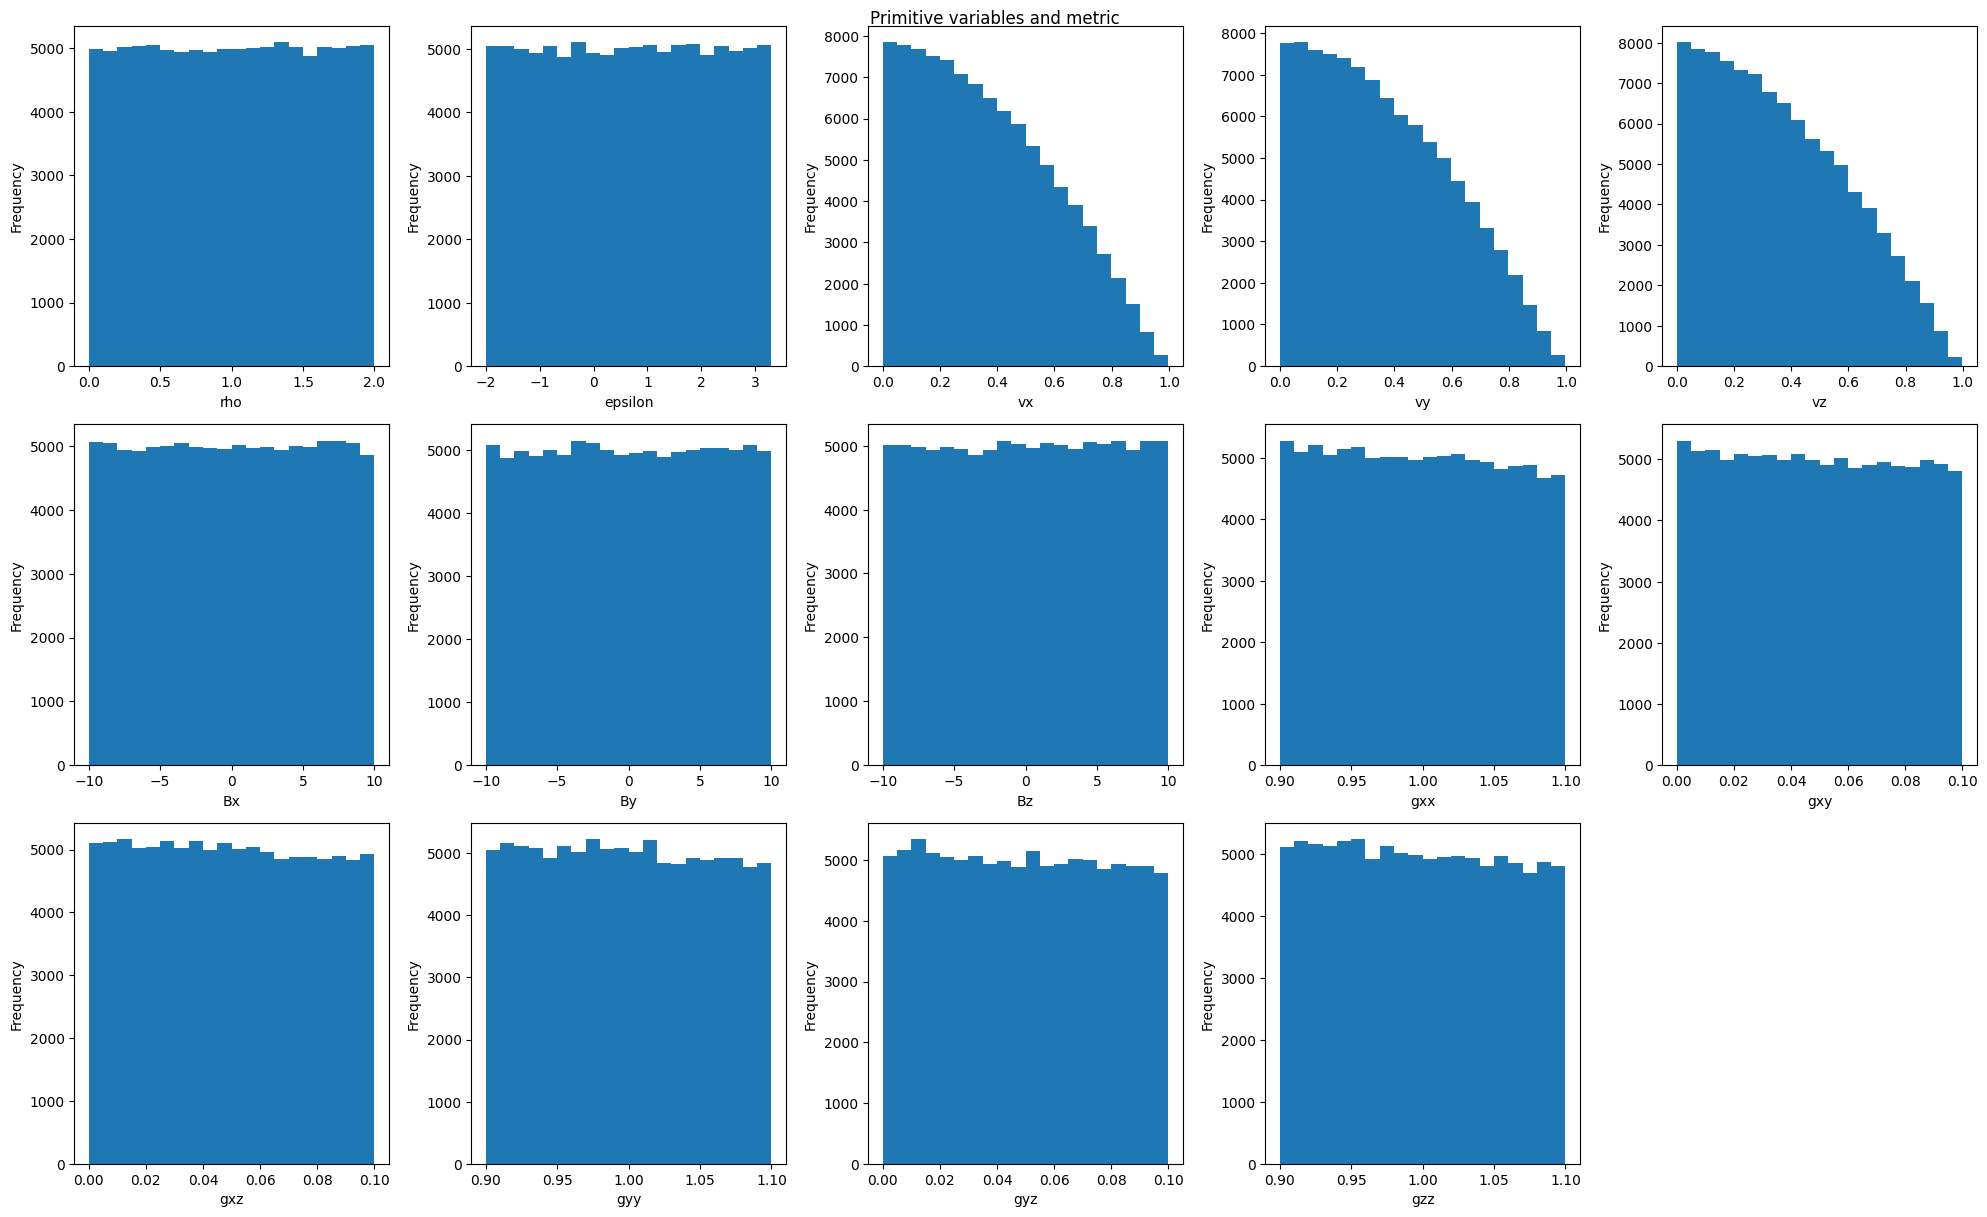

In [ ]:
#%%script echo skipping

if not LOAD_DATA_FROM_CSV:
    def plot_histogram(data, xlabel, ylabel, position, bins=20, xlog_scale=False, ylog_scale=False):
        plt.subplot(4, 5, position)
        plt.hist(data, bins=bins)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if xlog_scale: # Setting does not work expected for epsilon.
            plt.xscale("log")
        if ylog_scale: # Setting does not work expected for epsilon.
            plt.yscale("log")

    # Plotting the histograms of rho, vx, epsilon, b0, b1, b2, and b3
    bins = 20
    plt.figure(figsize=(20, 16))

    plot_histogram(rho, "rho", "Frequency", 1, bins=bins)
    plot_histogram(epsilon, "epsilon", "Frequency", 2, bins=bins)
    plot_histogram(vx, "vx", "Frequency", 3, bins=bins)
    plot_histogram(vy, "vy", "Frequency", 4, bins=bins)
    plot_histogram(vz, "vz", "Frequency", 5, bins=bins)
    plot_histogram(Bx, "Bx", "Frequency", 6, bins=bins)
    plot_histogram(By, "By", "Frequency", 7, bins=bins)
    plot_histogram(Bz, "Bz", "Frequency", 8, bins=bins)

    # Plot these
    plot_histogram(gxx, "gxx", "Frequency", 9, bins=bins)
    plot_histogram(gxy, "gxy", "Frequency", 10, bins=bins)
    plot_histogram(gxz, "gxz", "Frequency", 11, bins=bins)
    plot_histogram(gyy, "gyy", "Frequency", 12, bins=bins)
    plot_histogram(gyz, "gyz", "Frequency", 13, bins=bins)
    plot_histogram(gzz, "gzz", "Frequency", 14, bins=bins)


    plt.suptitle("Primitive variables and metric")
    plt.tight_layout()
    plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

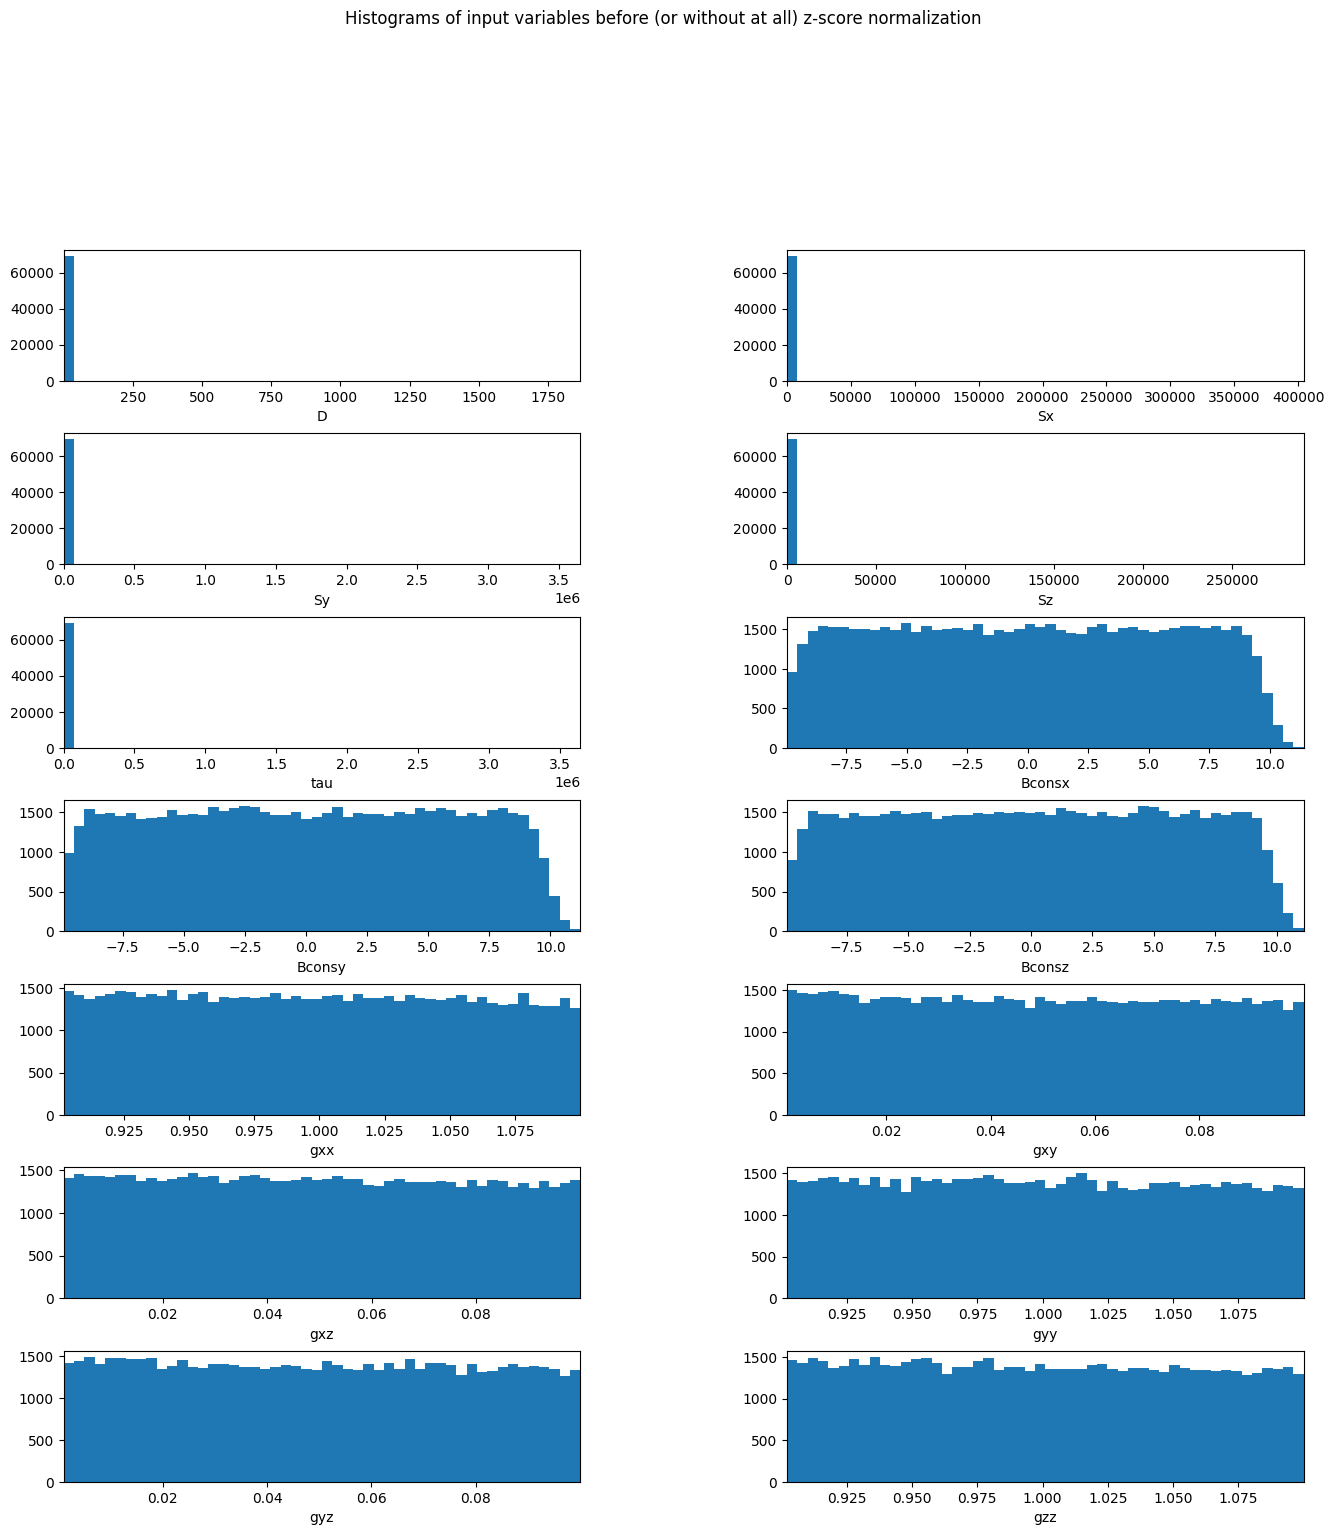

In [ ]:
#%%script echo skipping

# Variable names
variable_names = ["D", "Sx", "Sy", "Sz", "tau", "Bconsx", "Bconsy", "Bconsz", "gxx", "gxy", "gxz", "gyy", "gyz", "gzz"]

# Plotting histograms of the input variables before z-score normalization
plt.figure(figsize=(16, 16))
plt.suptitle('Histograms of input variables before (or without at all) z-score normalization', y=1.03)

for i in range(N_INPUTS):
    plt.subplot(7, 2, i+1)
    data = x_train[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
    lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
    # lower_bound, upper_bound = np.percentile(data, [1, 90]) # Calculate 1st and 99th percentile

    plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
    plt.xlabel(variable_names[i])
    plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

# Same plotting but for the test data. Adjust the percentile range as needed to zoom in.
# plt.figure(figsize=(16, 16))
# plt.suptitle('Histograms of input variables before (or without at all) z-score normalization (test data)', y=1.03)

# for i in range(14):
#     plt.subplot(7, 2, i+1)
#     data = x_test[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
#     #lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
#     lower_bound, upper_bound = np.percentile(data, [1, 99]) # Use this to zoom in.

#     plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
#     plt.xlabel(variable_names[i])
#     plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

# plt.subplots_adjust(hspace=0.4, wspace=0.4)
# plt.show()



### Data normalization

In [ ]:
# Computing summary statistics of the input variables before and after z-score normalization
print('Summary statistics of input variables before z-score normalization')
print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.nanmean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))

Summary statistics of input variables before z-score normalization
tensor([[ 1.7178e-05,  1.8661e+03,  2.2990e+00,  1.6672e+00,  7.8869e+00],
        [-9.9749e+03,  4.0428e+05,  4.5452e+01,  2.1877e+01,  1.5903e+03],
        [-8.9312e+03,  3.6518e+06,  9.3442e+01,  2.2109e+01,  1.3813e+04],
        [-1.1200e+04,  2.9022e+05,  4.3849e+01,  2.1879e+01,  1.1846e+03],
        [-1.5104e+04,  3.6454e+06,  1.4806e+02,  7.0033e+01,  1.3801e+04],
        [-1.1340e+01,  1.1406e+01, -2.0666e-02, -7.4331e-03,  5.7423e+00],
        [-1.1255e+01,  1.1218e+01,  9.0668e-03,  4.5898e-03,  5.7402e+00],
        [-1.1131e+01,  1.1091e+01,  2.9727e-02,  5.7525e-02,  5.7442e+00],
        [ 9.0000e-01,  1.1000e+00,  9.9869e-01,  9.9830e-01,  5.7583e-02],
        [ 7.1982e-07,  1.0000e-01,  4.9360e-02,  4.9177e-02,  2.8987e-02],
        [ 3.8715e-07,  9.9998e-02,  4.9399e-02,  4.9102e-02,  2.8843e-02],
        [ 9.0000e-01,  1.1000e+00,  9.9894e-01,  9.9830e-01,  5.7585e-02],
        [ 1.0813e-06,  1.0000e-01

Perform z-score normalization

In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

In [ ]:
if ZSCORE_NORMALIZATION:
    
    # TODO: Add magnetic field variables to the normalization if I decide to use the old code that is commented out here.
    # # Computing the median of each input variable from the training set using torch.nanmedian function
    # D_median = torch.nanmedian(x_train[:, 0])
    # Sx_median = torch.nanmedian(x_train[:, 1])
    # Sy_median = torch.nanmedian(x_train[:, 2])
    # Sz_median = torch.nanmedian(x_train[:, 3])
    # tau_median = torch.nanmedian(x_train[:, 4])

    # # Computing the standard deviation of each input variable from the training set using torch.std function with a boolean mask to ignore nan values
    # D_std = torch.std(x_train[~torch.isnan(x_train[:, 0]), 0])
    # Sx_std = torch.std(x_train[~torch.isnan(x_train[:, 1]), 1])
    # Sy_std = torch.std(x_train[~torch.isnan(x_train[:, 2]), 2])
    # Sz_std = torch.std(x_train[~torch.isnan(x_train[:, 3]), 3])
    # tau_std = torch.std(x_train[~torch.isnan(x_train[:, 4]), 4])


    # # Applying z-score normalization to both train and test sets using the statistics from the training set
    # x_train[:, 0] = torch.sub(x_train[:, 0], D_median).div(D_std)
    # x_train[:, 1] = torch.sub(x_train[:, 1], Sx_median).div(Sx_std)
    # x_train[:, 2] = torch.sub(x_train[:, 2], Sy_median).div(Sy_std)
    # x_train[:, 3] = torch.sub(x_train[:, 3], Sz_median).div(Sz_std)
    # x_train[:, 4] = torch.sub(x_train[:, 4], tau_median).div(tau_std)

    # x_test[:, 0] = torch.sub(x_test[:, 0], D_median).div(D_std)
    # x_test[:, 1] = torch.sub(x_test[:, 1], Sx_median).div(Sx_std)
    # x_test[:, 2] = torch.sub(x_test[:, 2], Sy_median).div(Sy_std)
    # x_test[:, 3] = torch.sub(x_test[:, 3], Sz_median).div(Sz_std)
    # x_test[:, 4] = torch.sub(x_test[:, 4], tau_median).div(tau_std)

    # Computing the mean and standard deviation of each column
    mean = x_train.mean(dim=0)
    std = x_train.std(dim=0)

    # Applying z-score normalization
    x_train = (x_train - mean) / std
    # Use the same mean and std from the training data as we don't want test data leakage.
    x_test = (x_test - mean) / std



Plotting the histograms of the input data after normalization if z-score normalization was performed.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [ ]:
if not LOAD_DATA_FROM_CSV:
    if ZSCORE_NORMALIZATION:
        # Variable names
        variable_names = ["D", "Sx", "Sy", "Sz", "tau", "Bconsx", "Bconsy", "Bconsz", "gxx", "gxy", "gxz", "gyy", "gyz", "gzz"]

        # Plotting histograms of the input variables before z-score normalization
        plt.figure(figsize=(16, 16))
        plt.suptitle('Histograms of input variables before (or without at all) z-score normalization', y=1.03)

        for i in range(N_INPUTS):
            plt.subplot(7, 2, i+1)
            data = x_train[:, i].cpu().numpy() # Convert tensor to numpy array for percentile calculation
            lower_bound, upper_bound = np.percentile(data, [1, 100]) # NOTE: Use this instead to visualize all the data.
            # lower_bound, upper_bound = np.percentile(data, [1, 90]) # Calculate 1st and 99th percentile

            plt.hist(data, bins=50, range=(lower_bound, upper_bound)) # Set range to the calculated percentile range
            plt.xlabel(variable_names[i])
            plt.xlim(lower_bound, upper_bound) # Set the x limit to match the range of the histogram

        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()

In [ ]:
if ZSCORE_NORMALIZATION:
    # Computing summary statistics of the input variables after z-score normalization
    print('Summary statistics of input variables after z-score normalization')
    print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.mean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))


### Visualizing input data and labels

In [ ]:
x_train
y_train
x_val
y_val
x_test
y_test

tensor([-1.0361,  2.7455, 17.4197,  ..., -1.6525,  1.5343, -3.0060],
       device='cuda:0')

Checking if our output is always positive ~~by plotting a histogram of y_train and y_test tensors~~

In [ ]:
import torch

# Create a sample tensor
tensor = torch.randn(80000, 14)  # Assuming a tensor of shape [80000, 14]
tensor


# Check if any element is negative
any_negative = torch.any(tensor < 0)

# Print the result
print(any_negative)


tensor(True)


In [ ]:
y_train.shape
any_negative = torch.any(y_train < 0)
any_negative

y_test.shape
any_negative = torch.any(y_test < 0)
any_negative

x_train.shape
any_negative = torch.any(x_train < 0)
any_negative

tensor(True, device='cuda:0')

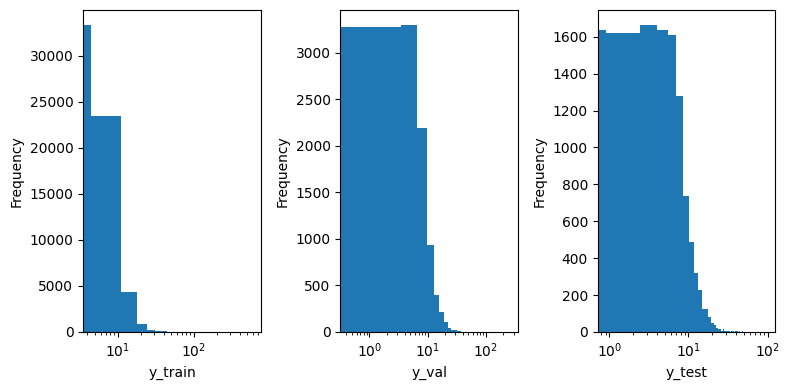

In [ ]:
#%%script echo skipping

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.hist(y_train.cpu().numpy(), bins=100) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.xscale("log")
plt.subplot(1, 3, 2)
plt.hist(y_val.cpu().numpy(), bins=100) # must be cpu here
plt.xlabel("y_val")
plt.ylabel("Frequency")
plt.xscale("log")
plt.tight_layout()
plt.subplot(1, 3, 3)
plt.hist(y_test.cpu().numpy(), bins=100) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.xscale("log")
plt.tight_layout()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [ ]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation, dropout_rate):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
            TODO: [ver. Copilot description] dropout_rate (float): The dropout rate to use for all layers.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.dropout_rate = dropout_rate

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        self.layers.append(nn.Linear(N_INPUTS, n_units[0]))
        self.dropouts.append(nn.Dropout(p=dropout_rate))

        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
            self.dropouts.append(nn.Dropout(p=dropout_rate))

        self.layers.append(nn.Linear(n_units[-1], N_OUTPUTS))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, N_INPUTS).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, N_OUTPUTS).
        """
        # Adding an assertion to check that the input tensor has the expected shape and type
        assert isinstance(x, torch.Tensor), "x must be a torch.Tensor"
        assert x.shape[1] == N_INPUTS, f"x must have shape (batch_size, {N_INPUTS})"

        for layer, dropout in zip(self.layers[:-1], self.dropouts):
            x = dropout(self.hidden_activation(layer(x)))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x)) # No dropout at output layer

        return x # Returning the output tensor


In [ ]:
%%script echo skipping

[1,2,3]
[1,2,3][:-1]

skipping


In [ ]:
for x in [1,2,3][:-1]:
    print(x)



1
2


## Defining the model and search space

In [ ]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
            dropout_rate is the dropout rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if OPTIMIZE:
        n_layers = trial.suggest_int("n_layers", 2, 10)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 4096) for i in range(n_layers)]

        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "PReLU", "Swish", "GELU", "SoftPlus"]
        )
        output_activation_name = trial.suggest_categorical( "output_activation", ["Linear"])

        loss_name = trial.suggest_categorical( "loss", ["MSE", "MAE", "Huber", "Quantile"])  # Added Quantile loss

        optimizer_name = trial.suggest_categorical( "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] )

        lr = trial.suggest_loguniform("lr", 1e-6, 1)

        batch_size_list = [32, 64, 128, 256, 512, 1024, 2048]
        batch_size = trial.suggest_categorical("batch_size", batch_size_list)
        
        n_epochs = trial.suggest_int("n_epochs", 50, 150)

        # scheduler_name = trial.suggest_categorical("scheduler", ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "CyclicLR"])
        scheduler_name = trial.suggest_categorical("scheduler", ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR"])

        # Creating the activation functions from their names
        if hidden_activation_name == "ReLU":
            hidden_activation = nn.ReLU()
        elif hidden_activation_name == "LeakyReLU":
            negative_slope = trial.suggest_uniform("leakyrelu_slope", 0.01, 0.3)
            hidden_activation = nn.LeakyReLU(negative_slope=negative_slope)
        elif hidden_activation_name == "ELU":
            hidden_activation = nn.ELU() 
        elif hidden_activation_name == "PReLU":
            init = trial.suggest_uniform("prelu_init", 0.1, 0.3)
            hidden_activation = nn.PReLU(init=init)
        elif hidden_activation_name == "Swish":
            class Swish(nn.Module):
                def forward(self, x):
                    return x * torch.sigmoid(x)
            hidden_activation = Swish()
        elif hidden_activation_name == "GELU":
            hidden_activation = nn.GELU()
        elif hidden_activation_name == "SoftPlus":
            beta = trial.suggest_uniform("softplus_beta", 0.5, 1.5)
            hidden_activation = nn.Softplus(beta=beta) # We don't optimize thresshold subparameters, as it's mainly for numerical stability.

        dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)


    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT

        # Creating the activation functions from their names
        if hidden_activation_name == "ReLU":
            hidden_activation = nn.ReLU()
        elif hidden_activation_name == "LeakyReLU":
            negative_slope = 0.01
            hidden_activation = nn.LeakyReLU(negative_slope=negative_slope)
        elif hidden_activation_name == "ELU":
            hidden_activation = nn.ELU() 
        elif hidden_activation_name == "PReLU":
            init = 0.25
            hidden_activation = nn.PReLU(init=init)
        elif hidden_activation_name == "Swish":
            class Swish(nn.Module):
                def forward(self, x):
                    return x * torch.sigmoid(x)
            hidden_activation = Swish()
        elif hidden_activation_name == "GELU":
            hidden_activation = nn.GELU()
        elif hidden_activation_name == "SoftPlus":
            beta = 1
            hidden_activation = nn.Softplus(beta=beta) # We don't optimize threshold subparameter, as it's mainly for numerical stability.

        dropout_rate = DROPOUT_RATE_NO_OPT


    # We used to have options here, but since we have a regression problem with continuous output, we only use Linear.
    output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    elif loss_name == "Quantile":
        def quantile_loss(y_pred, y_true, q=0.5):
            e = y_pred - y_true
            return torch.mean(torch.max(q*e, (q-1)*e))
        loss_fn = quantile_loss
    else:
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(n_layers, n_units, hidden_activation, output_activation, dropout_rate).to(device)


    if OPTIMIZE:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
            beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.1, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            if n_epochs < 150:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
            elif n_epochs > 250:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.05, 0.1)
            else:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.2)

            T_max = int(n_epochs * t_max_fraction)
            eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
        elif scheduler_name == "ReduceLROnPlateau":
            factor = trial.suggest_uniform("factor", 0.1, 0.5)
            patience = trial.suggest_int("patience", 5, 10)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        elif scheduler_name == "CyclicLR":
            base_lr = trial.suggest_loguniform("base_lr", 1e-6, 1e-2)
            max_lr = trial.suggest_loguniform("max_lr", 1e-4, 1)
            step_size_up = trial.suggest_int("step_size_up", 200, 2000)
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up)
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer)
        elif scheduler_name == "ReduceLROnPlateau":
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.18979341786654758, patience=11, threshold=0.0017197466122611932 #, min_lr=1e-6
                    )
        elif scheduler_name == "CyclicLR":
            # TODO: Change these appropriately.
            base_lr = 1e-6
            max_lr = 1e-4
            step_size_up = 200
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up)
        else:
            scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr, dropout_rate




 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [ ]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [ ]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_loader, val_loader, test_loader, trial=None):
    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    val_losses = []
    test_losses = []
    train_metrics = []
    val_metrics = []
    test_metrics = []


    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        if val_loader is not None:
            net.eval()
            val_loss = 0.0
            val_l1_norm = 0.0
            val_linf_norm = 0.0

            with torch.no_grad():
                for x_batch, y_batch in val_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = net(x_batch)
                    loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)

                    val_loss += loss.item() * x_batch.size(0)
                    val_l1_norm += l1_norm.item() * x_batch.size(0)
                    val_linf_norm += linf_norm.item() * x_batch.size(0)

            val_loss /= len(val_loader.dataset)
            val_l1_norm /= len(val_loader.dataset)
            val_linf_norm /= len(val_loader.dataset)

            val_losses.append(val_loss)
            val_metrics.append(
                {
                    "l1_norm": val_l1_norm,
                    "linf_norm": val_linf_norm,
                }
            )

            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("L1 norm/val", val_l1_norm, epoch)
            writer.add_scalar("Linf norm/val", val_linf_norm, epoch)
            print(f"Epoch {epoch+1}/{n_epochs}.. Train loss: {train_loss:.3f}.. Val loss: {val_loss:.3f}.. Train L1 norm: {train_l1_norm:.3f}.. Val L1 norm: {val_l1_norm:.3f}.. Train Linf norm: {train_linf_norm:.3f}.. Val Linf norm: {val_linf_norm:.3f}")


            update_scheduler(scheduler, val_loss)

        if test_loader is not None:
            net.eval()
            test_loss = 0.0
            test_l1_norm = 0.0
            test_linf_norm = 0.0

            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = net(x_batch)
                    loss, l1_norm, linf_norm = compute_loss_and_metrics(y_pred, y_batch, loss_fn)

                    test_loss += loss.item() * x_batch.size(0)
                    test_l1_norm += l1_norm.item() * x_batch.size(0)
                    test_linf_norm += linf_norm.item() * x_batch.size(0)

            test_loss /= len(test_loader.dataset)
            test_l1_norm /= len(test_loader.dataset)
            test_linf_norm /= len(test_loader.dataset)

            test_losses.append(test_loss)
            test_metrics.append(
                {
                    "l1_norm": test_l1_norm,
                    "linf_norm": test_linf_norm,
                }
            )

            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
            writer.add_scalar("Linf norm/test", test_linf_norm, epoch)
            print(f"Epoch {epoch+1}/{n_epochs}.. Train loss: {train_loss:.3f}.. Test loss: {test_loss:.3f}.. Train L1 norm: {train_l1_norm:.3f}.. Test L1 norm: {test_l1_norm:.3f}.. Train Linf norm: {train_linf_norm:.3f}.. Test Linf norm: {test_linf_norm:.3f}")


        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(val_l1_norm, epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics


In [ ]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial, optimize=True)

    # Create separate data loaders for training and validation
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_val, y_val), batch_size=batch_size
    )
    
    _, _, _, _, val_metrics, _ = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_loader, val_loader, None, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return val_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-29 02:36:48,307] A new study created in memory with name: no-name-381fcc13-8946-48ec-a8cd-d54eee387c84
<ipython-input-77-ddc3c9d46736>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1)
<ipython-input-77-ddc3c9d46736>:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
<ipython-input-77-ddc3c9d46736>:178: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  factor = trial.

Epoch 1/105.. Train loss: 257623969627.328.. Val loss: 3.798.. Train L1 norm: 139930137856.206.. Val L1 norm: 5.813.. Train Linf norm: 1508127832064.914.. Val Linf norm: 123.754
Epoch 2/105.. Train loss: 25730.059.. Val loss: 3.804.. Train L1 norm: 7301.163.. Val L1 norm: 4.884.. Train Linf norm: 233573.572.. Val Linf norm: 101.951
Epoch 3/105.. Train loss: 6076.437.. Val loss: 3.824.. Train L1 norm: 5348.730.. Val L1 norm: 6.449.. Train Linf norm: 171095.195.. Val Linf norm: 138.457
Epoch 4/105.. Train loss: 14614.797.. Val loss: 3.794.. Train L1 norm: 2627.463.. Val L1 norm: 5.553.. Train Linf norm: 84015.930.. Val Linf norm: 117.671
Epoch 5/105.. Train loss: 1336.650.. Val loss: 3.984.. Train L1 norm: 407.660.. Val L1 norm: 3.077.. Train Linf norm: 12981.277.. Val Linf norm: 58.074
Epoch 6/105.. Train loss: 1733.446.. Val loss: 3.794.. Train L1 norm: 814.258.. Val L1 norm: 5.348.. Train Linf norm: 25994.770.. Val Linf norm: 112.888
Epoch 7/105.. Train loss: 1800.736.. Val loss: 3.86

[I 2023-05-29 03:13:52,750] Trial 0 finished with value: 5.475563034884135 and parameters: {'n_layers': 5, 'n_units_0': 1810, 'n_units_1': 2471, 'n_units_2': 3863, 'n_units_3': 847, 'n_units_4': 3837, 'hidden_activation': 'Swish', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.5048353295116449, 'batch_size': 32, 'n_epochs': 105, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.1488418576403419, 'factor': 0.4948638775131383, 'patience': 5, 'threshold': 0.007132405166355046}. Best is trial 0 with value: 5.475563034884135.


Epoch 105/105.. Train loss: 1673.194.. Val loss: 3.794.. Train L1 norm: 600.333.. Val L1 norm: 5.476.. Train Linf norm: 19152.235.. Val Linf norm: 115.871


<ipython-input-77-ddc3c9d46736>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1)
<ipython-input-77-ddc3c9d46736>:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta = trial.suggest_uniform("softplus_beta", 0.5, 1.5)
<ipython-input-77-ddc3c9d46736>:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
<ipython-input-77-ddc3c9d46736>:178: FutureWarning: suggest_uniform has be

Epoch 1/99.. Train loss: 5113708.906.. Val loss: 2.057.. Train L1 norm: 20499684.534.. Val L1 norm: 4.433.. Train Linf norm: 1256310831.781.. Val Linf norm: 301.628
Epoch 2/99.. Train loss: 2.344.. Val loss: 2.283.. Train L1 norm: 39.399.. Val L1 norm: 4.498.. Train Linf norm: 4735.839.. Val Linf norm: 313.586
Epoch 3/99.. Train loss: 3.221.. Val loss: 2.118.. Train L1 norm: 51.418.. Val L1 norm: 4.665.. Train Linf norm: 6164.097.. Val Linf norm: 325.148
Epoch 4/99.. Train loss: 2.604.. Val loss: 2.135.. Train L1 norm: 49.712.. Val L1 norm: 5.382.. Train Linf norm: 6001.885.. Val Linf norm: 382.025
Epoch 5/99.. Train loss: 2.296.. Val loss: 2.135.. Train L1 norm: 56.312.. Val L1 norm: 5.504.. Train Linf norm: 6880.011.. Val Linf norm: 391.677
Epoch 6/99.. Train loss: 2.889.. Val loss: 2.135.. Train L1 norm: 56.180.. Val L1 norm: 5.361.. Train Linf norm: 6824.222.. Val Linf norm: 380.409
Epoch 7/99.. Train loss: 2.408.. Val loss: 2.135.. Train L1 norm: 56.628.. Val L1 norm: 5.467.. Trai

[I 2023-05-29 03:23:06,772] Trial 1 finished with value: 5.473422298431396 and parameters: {'n_layers': 4, 'n_units_0': 1461, 'n_units_1': 1257, 'n_units_2': 3865, 'n_units_3': 3100, 'hidden_activation': 'SoftPlus', 'output_activation': 'Linear', 'loss': 'Quantile', 'optimizer': 'RMSprop', 'lr': 0.013350957754286737, 'batch_size': 128, 'n_epochs': 99, 'scheduler': 'ReduceLROnPlateau', 'softplus_beta': 0.7041414244993218, 'dropout_rate': 0.24711369656353527, 'factor': 0.28072566444985225, 'patience': 6, 'threshold': 0.0003643445534342737}. Best is trial 1 with value: 5.473422298431396.


Epoch 99/99.. Train loss: 2.141.. Val loss: 2.135.. Train L1 norm: 56.839.. Val L1 norm: 5.473.. Train Linf norm: 6961.839.. Val Linf norm: 389.261


<ipython-input-77-ddc3c9d46736>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1)
<ipython-input-77-ddc3c9d46736>:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  negative_slope = trial.suggest_uniform("leakyrelu_slope", 0.01, 0.3)
<ipython-input-77-ddc3c9d46736>:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
<ipython-input-77-ddc3c9d46736>:145: FutureWarning: suggest_l

Epoch 1/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 2/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 3/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 4/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 5/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 6/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 7/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 8/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 9/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 10/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 11/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 12/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 13/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 14/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 15/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 16/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 17/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 18/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 19/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 20/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 21/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 22/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 23/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 24/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 25/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 26/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 27/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 28/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 29/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 30/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 31/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 32/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 33/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 34/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 35/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 36/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 37/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 38/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 39/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 40/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 41/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 42/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 43/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 44/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 45/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 46/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 47/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 48/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 49/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 50/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


Epoch 51/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[W 2023-05-29 03:28:15,758] Trial 2 failed with parameters: {'n_layers': 8, 'n_units_0': 3580, 'n_units_1': 1309, 'n_units_2': 44, 'n_units_3': 3153, 'n_units_4': 3302, 'n_units_5': 528, 'n_units_6': 2008, 'n_units_7': 2731, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.000443614672043173, 'batch_size': 128, 'n_epochs': 52, 'scheduler': 'CosineAnnealingLR', 'leakyrelu_slope': 0.1998660141516426, 'dropout_rate': 0.18536913197790994, 'weight_decay': 0.0004033003754287748, 'momentum': 0.46836209291099223, 't_max_fraction': 0.13849952781161015, 'eta_min': 7.526976524655028e-07} because of the following error: The value nan is not acceptable..
[W 2023-05-29 03:28:15,759] Trial 2 failed with value nan.


Epoch 52/52.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


<ipython-input-77-ddc3c9d46736>:178: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.5)
<ipython-input-77-ddc3c9d46736>:180: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)


Epoch 1/111.. Train loss: 1073959011.306.. Val loss: 128.138.. Train L1 norm: 276.488.. Val L1 norm: 2.244.. Train Linf norm: 4557.800.. Val Linf norm: 36.711
Epoch 2/111.. Train loss: 81815.299.. Val loss: 45.854.. Train L1 norm: 8.787.. Val L1 norm: 1.892.. Train Linf norm: 242.301.. Val Linf norm: 27.130
Epoch 3/111.. Train loss: 310524.864.. Val loss: 52.459.. Train L1 norm: 48.291.. Val L1 norm: 1.399.. Train Linf norm: 1508.157.. Val Linf norm: 13.867
Epoch 4/111.. Train loss: 34774.897.. Val loss: 46.565.. Train L1 norm: 23.054.. Val L1 norm: 1.747.. Train Linf norm: 703.349.. Val Linf norm: 23.545
Epoch 5/111.. Train loss: 82966.816.. Val loss: 52.891.. Train L1 norm: 26.996.. Val L1 norm: 1.102.. Train Linf norm: 830.361.. Val Linf norm: 4.955
Epoch 6/111.. Train loss: 1306.639.. Val loss: 76.768.. Train L1 norm: 25.342.. Val L1 norm: 1.202.. Train Linf norm: 776.957.. Val Linf norm: 8.100
Epoch 7/111.. Train loss: 208687.916.. Val loss: 69.229.. Train L1 norm: 15.756.. Val L1

[I 2023-05-29 04:23:07,667] Trial 3 finished with value: 1.478571067237854 and parameters: {'n_layers': 7, 'n_units_0': 2912, 'n_units_1': 3116, 'n_units_2': 2245, 'n_units_3': 488, 'n_units_4': 3078, 'n_units_5': 2852, 'n_units_6': 2983, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.004781959866774028, 'batch_size': 32, 'n_epochs': 111, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.12469063486457926, 'factor': 0.12705535727393857, 'patience': 7, 'threshold': 0.004372075888689966}. Best is trial 3 with value: 1.478571067237854.


Epoch 111/111.. Train loss: 1041.407.. Val loss: 56.752.. Train L1 norm: 16.380.. Val L1 norm: 1.479.. Train Linf norm: 491.729.. Val Linf norm: 15.756
Epoch 1/127.. Train loss: 2431.559.. Val loss: 303.006.. Train L1 norm: 13.627.. Val L1 norm: 6.044.. Train Linf norm: 11947.436.. Val Linf norm: 1790.288
Epoch 2/127.. Train loss: 472401.679.. Val loss: 55.036.. Train L1 norm: 47.234.. Val L1 norm: 2.552.. Train Linf norm: 45920.383.. Val Linf norm: 773.171
Epoch 3/127.. Train loss: 59994.538.. Val loss: 95.503.. Train L1 norm: 43.976.. Val L1 norm: 2.401.. Train Linf norm: 43213.895.. Val Linf norm: 633.864
Epoch 4/127.. Train loss: 86604.997.. Val loss: 51.454.. Train L1 norm: 18.284.. Val L1 norm: 2.650.. Train Linf norm: 16876.323.. Val Linf norm: 796.568
Epoch 5/127.. Train loss: 38524.932.. Val loss: 78.464.. Train L1 norm: 53.581.. Val L1 norm: 1.931.. Train Linf norm: 52853.929.. Val Linf norm: 500.041
Epoch 6/127.. Train loss: 12585.086.. Val loss: 47.538.. Train L1 norm: 2.38

[I 2023-05-29 04:30:47,426] Trial 4 finished with value: 1.30382172832489 and parameters: {'n_layers': 4, 'n_units_0': 313, 'n_units_1': 3265, 'n_units_2': 3831, 'n_units_3': 2412, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 5.142300685583092e-06, 'batch_size': 1024, 'n_epochs': 127, 'scheduler': 'ReduceLROnPlateau', 'leakyrelu_slope': 0.23154673591607142, 'dropout_rate': 0.10646571932712628, 'factor': 0.44677932125713526, 'patience': 6, 'threshold': 0.0002858329123008351}. Best is trial 4 with value: 1.30382172832489.


Epoch 127/127.. Train loss: 1432.051.. Val loss: 63.215.. Train L1 norm: 14.652.. Val L1 norm: 1.304.. Train Linf norm: 13773.091.. Val Linf norm: 220.547


<ipython-input-77-ddc3c9d46736>:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta = trial.suggest_uniform("softplus_beta", 0.5, 1.5)
<ipython-input-77-ddc3c9d46736>:161: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.1, 0.5)


Epoch 1/126.. Train loss: 19342.652.. Val loss: 4.505.. Train L1 norm: 8377.501.. Val L1 norm: 6.087.. Train Linf norm: 29754.275.. Val Linf norm: 132.335
Epoch 2/126.. Train loss: 4.005.. Val loss: 3.786.. Train L1 norm: 33.480.. Val L1 norm: 5.898.. Train Linf norm: 1016.833.. Val Linf norm: 128.710
Epoch 3/126.. Train loss: 3.656.. Val loss: 3.147.. Train L1 norm: 21.576.. Val L1 norm: 3.681.. Train Linf norm: 639.354.. Val Linf norm: 75.362
Epoch 4/126.. Train loss: 3.252.. Val loss: 2.870.. Train L1 norm: 20.688.. Val L1 norm: 3.131.. Train Linf norm: 620.932.. Val Linf norm: 68.290
Epoch 5/126.. Train loss: 2.890.. Val loss: 2.726.. Train L1 norm: 22.773.. Val L1 norm: 1.768.. Train Linf norm: 691.955.. Val Linf norm: 29.543
Epoch 6/126.. Train loss: 2.721.. Val loss: 2.535.. Train L1 norm: 34.278.. Val L1 norm: 2.480.. Train Linf norm: 1062.965.. Val Linf norm: 51.314
Epoch 7/126.. Train loss: 2.602.. Val loss: 2.360.. Train L1 norm: 13.526.. Val L1 norm: 2.373.. Train Linf norm

[I 2023-05-29 05:33:51,148] Trial 5 finished with value: 1.6918909295399984 and parameters: {'n_layers': 10, 'n_units_0': 3397, 'n_units_1': 1563, 'n_units_2': 1854, 'n_units_3': 3052, 'n_units_4': 486, 'n_units_5': 3292, 'n_units_6': 3122, 'n_units_7': 2736, 'n_units_8': 579, 'n_units_9': 1600, 'hidden_activation': 'SoftPlus', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.00048324682346559427, 'batch_size': 32, 'n_epochs': 126, 'scheduler': 'StepLR', 'softplus_beta': 0.7709420236586922, 'dropout_rate': 0.13008975704083042, 'step_size': 9, 'gamma': 0.24815624124188673}. Best is trial 4 with value: 1.30382172832489.


Epoch 126/126.. Train loss: 1.842.. Val loss: 1.772.. Train L1 norm: 3.676.. Val L1 norm: 1.692.. Train Linf norm: 94.384.. Val Linf norm: 33.584


[I 2023-05-29 05:34:02,526] Trial 6 pruned. 


Epoch 1/93.. Train loss: 9958.053.. Val loss: 43.369.. Train L1 norm: 76.882.. Val L1 norm: 6.172.. Train Linf norm: 2403.202.. Val Linf norm: 133.167


[I 2023-05-29 05:34:40,623] Trial 7 pruned. 


Epoch 1/82.. Train loss: 4.978.. Val loss: 4.037.. Train L1 norm: 83.983.. Val L1 norm: 6.195.. Train Linf norm: 2620.200.. Val Linf norm: 133.131
Epoch 1/76.. Train loss: 2.696.. Val loss: 2.411.. Train L1 norm: 7.644.. Val L1 norm: 1.262.. Train Linf norm: 13331.965.. Val Linf norm: 280.606
Epoch 2/76.. Train loss: 2.638.. Val loss: 2.374.. Train L1 norm: 18.884.. Val L1 norm: 1.454.. Train Linf norm: 36089.662.. Val Linf norm: 475.408
Epoch 3/76.. Train loss: 2.662.. Val loss: 2.354.. Train L1 norm: 14.486.. Val L1 norm: 1.571.. Train Linf norm: 26950.096.. Val Linf norm: 591.638
Epoch 4/76.. Train loss: 2.712.. Val loss: 2.343.. Train L1 norm: 21.197.. Val L1 norm: 1.648.. Train Linf norm: 40505.180.. Val Linf norm: 669.121
Epoch 5/76.. Train loss: 2.611.. Val loss: 2.334.. Train L1 norm: 17.031.. Val L1 norm: 1.709.. Train Linf norm: 32013.459.. Val Linf norm: 730.973
Epoch 6/76.. Train loss: 2.666.. Val loss: 2.329.. Train L1 norm: 10.217.. Val L1 norm: 1.755.. Train Linf norm: 1

[I 2023-05-29 05:37:46,157] Trial 8 finished with value: 2.052531473223368 and parameters: {'n_layers': 5, 'n_units_0': 389, 'n_units_1': 2298, 'n_units_2': 2727, 'n_units_3': 1407, 'n_units_4': 1708, 'hidden_activation': 'SoftPlus', 'output_activation': 'Linear', 'loss': 'Quantile', 'optimizer': 'Adagrad', 'lr': 3.6285475205836346e-06, 'batch_size': 2048, 'n_epochs': 76, 'scheduler': 'StepLR', 'softplus_beta': 1.0680991488570912, 'dropout_rate': 0.14278371333213874, 'step_size': 14, 'gamma': 0.47171326354053933}. Best is trial 4 with value: 1.30382172832489.


Epoch 76/76.. Train loss: 2.567.. Val loss: 2.300.. Train L1 norm: 22.206.. Val L1 norm: 2.053.. Train Linf norm: 42064.291.. Val Linf norm: 1095.213


[I 2023-05-29 05:37:47,944] Trial 9 pruned. 


Epoch 1/106.. Train loss: 5.401.. Val loss: 3.794.. Train L1 norm: 354.447.. Val L1 norm: 5.436.. Train Linf norm: 89836.231.. Val Linf norm: 705.663
Epoch 1/145.. Train loss: 8.379.. Val loss: 4.312.. Train L1 norm: 60.370.. Val L1 norm: 3.062.. Train Linf norm: 29129.410.. Val Linf norm: 574.640
Epoch 2/145.. Train loss: 5.066.. Val loss: 3.846.. Train L1 norm: 76.064.. Val L1 norm: 4.746.. Train Linf norm: 37590.781.. Val Linf norm: 1050.389


[I 2023-05-29 05:38:00,488] Trial 10 pruned. 


Epoch 3/145.. Train loss: 4.699.. Val loss: 4.021.. Train L1 norm: 78.130.. Val L1 norm: 3.896.. Train Linf norm: 28023.471.. Val Linf norm: 917.885


<ipython-input-77-ddc3c9d46736>:149: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-77-ddc3c9d46736>:150: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
<ipython-input-77-ddc3c9d46736>:151: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)


Epoch 1/55.. Train loss: 372934.830.. Val loss: 937.782.. Train L1 norm: 59.914.. Val L1 norm: 2.411.. Train Linf norm: 59383.138.. Val Linf norm: 609.599
Epoch 2/55.. Train loss: 109365.716.. Val loss: 574.757.. Train L1 norm: 34.385.. Val L1 norm: 2.192.. Train Linf norm: 33393.546.. Val Linf norm: 472.424
Epoch 3/55.. Train loss: 2786.228.. Val loss: 485.219.. Train L1 norm: 42.871.. Val L1 norm: 2.445.. Train Linf norm: 41974.510.. Val Linf norm: 624.270
Epoch 4/55.. Train loss: 4225.760.. Val loss: 432.569.. Train L1 norm: 50.757.. Val L1 norm: 2.642.. Train Linf norm: 49993.455.. Val Linf norm: 728.089


[I 2023-05-29 05:38:07,061] Trial 11 pruned. 


Epoch 5/55.. Train loss: 1172.740.. Val loss: 430.780.. Train L1 norm: 41.667.. Val L1 norm: 2.644.. Train Linf norm: 40654.826.. Val Linf norm: 729.283
Epoch 1/127.. Train loss: 8655747590464.767.. Val loss: 55.937.. Train L1 norm: 75713.585.. Val L1 norm: 1.091.. Train Linf norm: 5354138.933.. Val Linf norm: 64.305
Epoch 2/127.. Train loss: 61.378.. Val loss: 55.937.. Train L1 norm: 2.523.. Val L1 norm: 1.091.. Train Linf norm: 1529.151.. Val Linf norm: 64.340
Epoch 3/127.. Train loss: 61.378.. Val loss: 55.937.. Train L1 norm: 2.524.. Val L1 norm: 1.091.. Train Linf norm: 1529.306.. Val Linf norm: 64.338
Epoch 4/127.. Train loss: 61.386.. Val loss: 55.937.. Train L1 norm: 2.524.. Val L1 norm: 1.091.. Train Linf norm: 1530.223.. Val Linf norm: 64.336
Epoch 5/127.. Train loss: 61.378.. Val loss: 55.937.. Train L1 norm: 2.523.. Val L1 norm: 1.091.. Train Linf norm: 1529.196.. Val Linf norm: 64.333
Epoch 6/127.. Train loss: 61.378.. Val loss: 55.937.. Train L1 norm: 2.523.. Val L1 norm:

[I 2023-05-29 05:48:30,299] Trial 12 finished with value: 1.1513660175323486 and parameters: {'n_layers': 8, 'n_units_0': 2666, 'n_units_1': 3174, 'n_units_2': 1813, 'n_units_3': 2294, 'n_units_4': 2402, 'n_units_5': 3801, 'n_units_6': 291, 'n_units_7': 81, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.006919811588951734, 'batch_size': 1024, 'n_epochs': 127, 'scheduler': 'CosineAnnealingLR', 'dropout_rate': 0.08585425252313758, 'weight_decay': 0.0003982972185580364, 'beta1': 0.9015749124067319, 'beta2': 0.999784773536315, 't_max_fraction': 0.11504831591926465, 'eta_min': 0.004347985819191817}. Best is trial 12 with value: 1.1513660175323486.


Epoch 127/127.. Train loss: 61.805.. Val loss: 56.360.. Train L1 norm: 3.405.. Val L1 norm: 1.151.. Train Linf norm: 2405.049.. Val Linf norm: 100.986
Epoch 1/136.. Train loss: 5543.809.. Val loss: 52.775.. Train L1 norm: 4.993.. Val L1 norm: 1.170.. Train Linf norm: 4012.715.. Val Linf norm: 118.708
Epoch 2/136.. Train loss: 3197.124.. Val loss: 51.360.. Train L1 norm: 10.409.. Val L1 norm: 1.420.. Train Linf norm: 9372.785.. Val Linf norm: 268.974
Epoch 3/136.. Train loss: 895.261.. Val loss: 48.040.. Train L1 norm: 11.876.. Val L1 norm: 2.281.. Train Linf norm: 10843.923.. Val Linf norm: 745.839
Epoch 4/136.. Train loss: 51.353.. Val loss: 40.212.. Train L1 norm: 48.631.. Val L1 norm: 6.558.. Train Linf norm: 46940.410.. Val Linf norm: 2797.483
Epoch 5/136.. Train loss: 204.528.. Val loss: 40.330.. Train L1 norm: 47.076.. Val L1 norm: 5.938.. Train Linf norm: 44702.058.. Val Linf norm: 2512.216
Epoch 6/136.. Train loss: 274.584.. Val loss: 40.311.. Train L1 norm: 64.095.. Val L1 nor

[I 2023-05-29 05:58:32,336] Trial 13 finished with value: 491036884983.26184 and parameters: {'n_layers': 9, 'n_units_0': 1244, 'n_units_1': 3230, 'n_units_2': 1218, 'n_units_3': 2303, 'n_units_4': 2450, 'n_units_5': 4095, 'n_units_6': 96, 'n_units_7': 421, 'n_units_8': 3958, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.6190756370319895e-05, 'batch_size': 1024, 'n_epochs': 136, 'scheduler': 'CosineAnnealingLR', 'dropout_rate': 0.07576322122724959, 'weight_decay': 0.00042315897345965406, 'beta1': 0.9002513329092581, 'beta2': 0.9998918652645777, 't_max_fraction': 0.10219960366850916, 'eta_min': 0.009329680637802071}. Best is trial 12 with value: 1.1513660175323486.


Epoch 136/136.. Train loss: 11825084847852407669336834048.000.. Val loss: 2815741984419868473032704.000.. Train L1 norm: 732769471722.759.. Val L1 norm: 491036884983.262.. Train Linf norm: 438520978655442.188.. Val Linf norm: 166462811018432.781


<ipython-input-77-ddc3c9d46736>:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  init = trial.suggest_uniform("prelu_init", 0.1, 0.3)
[I 2023-05-29 05:58:43,319] Trial 14 pruned. 


Epoch 1/124.. Train loss: 584974642.892.. Val loss: 6429299.803.. Train L1 norm: 6034.384.. Val L1 norm: 196.633.. Train Linf norm: 313127.218.. Val Linf norm: 8756.993


/usr/local/lib/python3.10/dist-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)
[I 2023-05-29 05:58:44,700] Trial 15 pruned. 


Epoch 1/149.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-29 05:58:53,275] Trial 16 pruned. 


Epoch 1/123.. Train loss: 148633816774371839804702720.000.. Val loss: 175332376002953891115171840.000.. Train L1 norm: 1796579652714.979.. Val L1 norm: 132660898291.166.. Train Linf norm: 1740822248545208.500.. Val Linf norm: 52558936125507.719
Epoch 1/134.. Train loss: 237770.219.. Val loss: 464.190.. Train L1 norm: 69.509.. Val L1 norm: 2.701.. Train Linf norm: 64783.191.. Val Linf norm: 786.548


[I 2023-05-29 05:58:57,174] Trial 17 pruned. 


Epoch 2/134.. Train loss: 412595.420.. Val loss: 175.210.. Train L1 norm: 169.684.. Val L1 norm: 3.149.. Train Linf norm: 168330.008.. Val Linf norm: 747.317
Epoch 1/117.. Train loss: 5.281.. Val loss: 3.799.. Train L1 norm: 48.852.. Val L1 norm: 2.595.. Train Linf norm: 11992.294.. Val Linf norm: 263.623


[I 2023-05-29 05:59:13,277] Trial 18 pruned. 


Epoch 2/117.. Train loss: 5.438.. Val loss: 3.641.. Train L1 norm: 41.178.. Val L1 norm: 3.429.. Train Linf norm: 10036.737.. Val Linf norm: 383.388
Epoch 1/137.. Train loss: 2.508.. Val loss: 2.458.. Train L1 norm: 3.213.. Val L1 norm: 1.173.. Train Linf norm: 284.270.. Val Linf norm: 21.905
Epoch 2/137.. Train loss: 2.461.. Val loss: 2.402.. Train L1 norm: 6.996.. Val L1 norm: 1.364.. Train Linf norm: 765.651.. Val Linf norm: 41.314
Epoch 3/137.. Train loss: 2.407.. Val loss: 2.331.. Train L1 norm: 8.135.. Val L1 norm: 1.635.. Train Linf norm: 905.271.. Val Linf norm: 66.804
Epoch 4/137.. Train loss: 2.382.. Val loss: 2.286.. Train L1 norm: 16.714.. Val L1 norm: 1.842.. Train Linf norm: 1994.816.. Val Linf norm: 85.512
Epoch 5/137.. Train loss: 2.351.. Val loss: 2.243.. Train L1 norm: 15.623.. Val L1 norm: 2.062.. Train Linf norm: 1850.699.. Val Linf norm: 104.909
Epoch 6/137.. Train loss: 2.310.. Val loss: 2.201.. Train L1 norm: 21.568.. Val L1 norm: 2.300.. Train Linf norm: 2601.42

[I 2023-05-29 06:38:13,729] Trial 19 finished with value: 5.619506869061788 and parameters: {'n_layers': 8, 'n_units_0': 2577, 'n_units_1': 3589, 'n_units_2': 2256, 'n_units_3': 3905, 'n_units_4': 3390, 'n_units_5': 3419, 'n_units_6': 4060, 'n_units_7': 1598, 'hidden_activation': 'ELU', 'output_activation': 'Linear', 'loss': 'Quantile', 'optimizer': 'SGD', 'lr': 1.0136180945341933e-06, 'batch_size': 128, 'n_epochs': 137, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.18496931985027687, 'weight_decay': 0.001250389560574206, 'momentum': 0.9471395725540319, 'factor': 0.4805499852960079, 'patience': 9, 'threshold': 0.00011696558558783301}. Best is trial 12 with value: 1.1513660175323486.


Epoch 137/137.. Train loss: 2.011.. Val loss: 1.980.. Train L1 norm: 71.542.. Val L1 norm: 5.620.. Train Linf norm: 8854.441.. Val Linf norm: 387.810


[I 2023-05-29 06:38:18,913] Trial 20 pruned. 


Epoch 1/88.. Train loss: 241028.875.. Val loss: 4770.420.. Train L1 norm: 765.014.. Val L1 norm: 18.943.. Train Linf norm: 48103.251.. Val Linf norm: 749.348


[I 2023-05-29 06:38:21,221] Trial 21 pruned. 


Epoch 1/69.. Train loss: 42287154418.250.. Val loss: 12374275.669.. Train L1 norm: 139776.194.. Val L1 norm: 241.773.. Train Linf norm: 70261389.389.. Val Linf norm: 48737.534
Epoch 1/114.. Train loss: 17625556913448404.000.. Val loss: 54.969.. Train L1 norm: 93520.530.. Val L1 norm: 1.697.. Train Linf norm: 78746586.097.. Val Linf norm: 642.891
Epoch 2/114.. Train loss: 340.088.. Val loss: 47.445.. Train L1 norm: 3.116.. Val L1 norm: 1.781.. Train Linf norm: 3585.405.. Val Linf norm: 723.806
Epoch 3/114.. Train loss: 947.147.. Val loss: 55.724.. Train L1 norm: 6.291.. Val L1 norm: 1.010.. Train Linf norm: 10137.540.. Val Linf norm: 10.782
Epoch 4/114.. Train loss: 1625.465.. Val loss: 52.009.. Train L1 norm: 10.157.. Val L1 norm: 1.179.. Train Linf norm: 18058.108.. Val Linf norm: 200.361
Epoch 5/114.. Train loss: 2848.112.. Val loss: 68.592.. Train L1 norm: 14.236.. Val L1 norm: 1.374.. Train Linf norm: 26451.637.. Val Linf norm: 294.801
Epoch 6/114.. Train loss: 6538.768.. Val loss:

[I 2023-05-29 06:48:02,172] Trial 22 finished with value: 1.0150012904485066 and parameters: {'n_layers': 7, 'n_units_0': 2882, 'n_units_1': 3130, 'n_units_2': 2203, 'n_units_3': 1211, 'n_units_4': 2905, 'n_units_5': 2730, 'n_units_6': 2542, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0037796163474596747, 'batch_size': 2048, 'n_epochs': 114, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.11318047708667109, 'factor': 0.1158770269366258, 'patience': 7, 'threshold': 0.0017827349270975305}. Best is trial 22 with value: 1.0150012904485066.


Epoch 114/114.. Train loss: 327.102.. Val loss: 56.607.. Train L1 norm: 2.499.. Val L1 norm: 1.015.. Train Linf norm: 2987.325.. Val Linf norm: 16.571


[I 2023-05-29 06:48:05,899] Trial 23 pruned. 


Epoch 1/114.. Train loss: 8636339.788.. Val loss: 40.548.. Train L1 norm: 171.571.. Val L1 norm: 7.080.. Train Linf norm: 182438.008.. Val Linf norm: 5502.771
Epoch 1/129.. Train loss: 445947174981508288.000.. Val loss: 50.128.. Train L1 norm: 2946235.265.. Val L1 norm: 1.360.. Train Linf norm: 334473620.250.. Val Linf norm: 379.157
Epoch 2/129.. Train loss: 97.686.. Val loss: 54.611.. Train L1 norm: 4.146.. Val L1 norm: 1.066.. Train Linf norm: 5993.504.. Val Linf norm: 98.020
Epoch 3/129.. Train loss: 65.203.. Val loss: 54.582.. Train L1 norm: 2.300.. Val L1 norm: 1.069.. Train Linf norm: 2575.895.. Val Linf norm: 102.734
Epoch 4/129.. Train loss: 61.481.. Val loss: 54.557.. Train L1 norm: 3.722.. Val L1 norm: 1.073.. Train Linf norm: 5434.227.. Val Linf norm: 106.825
Epoch 5/129.. Train loss: 68.177.. Val loss: 54.535.. Train L1 norm: 8.743.. Val L1 norm: 1.076.. Train Linf norm: 15571.420.. Val Linf norm: 110.502
Epoch 6/129.. Train loss: 109.398.. Val loss: 54.523.. Train L1 norm:

[I 2023-05-29 06:58:53,078] Trial 24 finished with value: 1.0795055260976156 and parameters: {'n_layers': 9, 'n_units_0': 2839, 'n_units_1': 3181, 'n_units_2': 1957, 'n_units_3': 1863, 'n_units_4': 3049, 'n_units_5': 3340, 'n_units_6': 1139, 'n_units_7': 48, 'n_units_8': 145, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.011081463667925381, 'batch_size': 2048, 'n_epochs': 129, 'scheduler': 'ReduceLROnPlateau', 'dropout_rate': 0.10522947336460009, 'factor': 0.2067170774063598, 'patience': 5, 'threshold': 0.0013844568766163486}. Best is trial 22 with value: 1.0150012904485066.


Epoch 129/129.. Train loss: 62.828.. Val loss: 54.505.. Train L1 norm: 2.416.. Val L1 norm: 1.080.. Train Linf norm: 2845.763.. Val Linf norm: 115.573


[I 2023-05-29 06:58:58,028] Trial 25 pruned. 


Epoch 1/143.. Train loss: 1078536935408491.375.. Val loss: 156.078.. Train L1 norm: 3001548.718.. Val L1 norm: 2.542.. Train Linf norm: 1954700899.762.. Val Linf norm: 1289.735


[I 2023-05-29 06:59:04,107] Trial 26 pruned. 


Epoch 1/119.. Train loss: 22989105486084920489709840367616.000.. Val loss: 13922296044594773565942792192.000.. Train L1 norm: 515630849530288.062.. Val L1 norm: 32391606800814.352.. Train Linf norm: 1009025964039756672.000.. Val Linf norm: 18625408053446864.000


[I 2023-05-29 06:59:09,229] Trial 27 pruned. 


Epoch 1/130.. Train loss: 122523.498.. Val loss: 4.310.. Train L1 norm: 191826.466.. Val L1 norm: 3.298.. Train Linf norm: 137295742.381.. Val Linf norm: 1780.104


[I 2023-05-29 06:59:15,470] Trial 28 pruned. 


Epoch 1/111.. Train loss: 7981462687494.353.. Val loss: 4051762.892.. Train L1 norm: 5781100973547.317.. Val L1 norm: 8002185.813.. Train Linf norm: 6407204773579551.000.. Val Linf norm: 4627737576.277


[I 2023-05-29 06:59:18,244] Trial 29 pruned. 


Epoch 1/98.. Train loss: 286349480413504.750.. Val loss: 4.044.. Train L1 norm: 173977106812354.250.. Val L1 norm: 2.738.. Train Linf norm: 13603733520037278.000.. Val Linf norm: 1776.636


[I 2023-05-29 06:59:23,375] Trial 30 pruned. 


Epoch 1/140.. Train loss: 5977401152565221737365504.000.. Val loss: 1378767641945474993225728.000.. Train L1 norm: 66273633170747787147476992.000.. Val L1 norm: 1249580189706835657228288.000.. Train Linf norm: 127606177761096235211647090688.000.. Val Linf norm: 590938047160725413606457344.000


[I 2023-05-29 06:59:29,297] Trial 31 pruned. 


Epoch 1/106.. Train loss: 711012904074596846671201398947840.000.. Val loss: 376481318875853230060058181632.000.. Train L1 norm: 3142102497978662.500.. Val L1 norm: 185772547914561.406.. Train Linf norm: 1549058092042970368.000.. Val Linf norm: 38069306765565944.000


[I 2023-05-29 06:59:36,303] Trial 32 pruned. 


Epoch 1/130.. Train loss: 211222969903301684619116544.000.. Val loss: 10924871943816678100434944.000.. Train L1 norm: 958044575497.318.. Val L1 norm: 81293002095.548.. Train Linf norm: 914322767186201.375.. Val Linf norm: 27531564393326.184


[I 2023-05-29 06:59:39,360] Trial 33 pruned. 


Epoch 1/119.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-29 06:59:53,138] Trial 34 pruned. 


Epoch 1/130.. Train loss: inf.. Val loss: 2268979159247821342256104734720.000.. Train L1 norm: 7442267178170476.000.. Val L1 norm: 487632496618233.312.. Train Linf norm: 921884951247499008.000.. Val Linf norm: 31936087801851876.000


[I 2023-05-29 06:59:57,721] Trial 35 pruned. 


Epoch 1/123.. Train loss: 382701.211.. Val loss: 4035.538.. Train L1 norm: 718.733.. Val L1 norm: 20.118.. Train Linf norm: 701563.580.. Val Linf norm: 6713.891


[I 2023-05-29 07:00:05,457] Trial 36 pruned. 


Epoch 1/107.. Train loss: 440.016.. Val loss: 34.853.. Train L1 norm: 80.223.. Val L1 norm: 5.541.. Train Linf norm: 19816.138.. Val Linf norm: 687.399


[I 2023-05-29 07:00:21,283] Trial 37 pruned. 


Epoch 1/101.. Train loss: 43687777300.120.. Val loss: 1586328.883.. Train L1 norm: 162205755135.166.. Val L1 norm: 2623296.098.. Train Linf norm: 7280468565751.652.. Val Linf norm: 101686018.745


[I 2023-05-29 07:01:09,743] Trial 38 pruned. 


Epoch 1/114.. Train loss: 9047.901.. Val loss: 4.271.. Train L1 norm: 27024.843.. Val L1 norm: 5.614.. Train Linf norm: 759401.595.. Val Linf norm: 119.115


[I 2023-05-29 07:01:17,319] Trial 39 pruned. 


Epoch 1/127.. Train loss: 2503092522632554.500.. Val loss: 10137252.042.. Train L1 norm: 1183731.587.. Val L1 norm: 520.969.. Train Linf norm: 70108369.744.. Val Linf norm: 33899.579


[I 2023-05-29 07:01:20,802] Trial 40 pruned. 


Epoch 1/133.. Train loss: 430954278003709760.000.. Val loss: 8146826616097682.000.. Train L1 norm: 100474358.115.. Val L1 norm: 5591039.212.. Train Linf norm: 169068288053.642.. Val Linf norm: 4022779372.058


[I 2023-05-29 07:01:29,971] Trial 41 pruned. 


Epoch 1/149.. Train loss: 516121.870.. Val loss: 3.723.. Train L1 norm: 327394.041.. Val L1 norm: 5.237.. Train Linf norm: 17452385.443.. Val Linf norm: 2142.566


[I 2023-05-29 07:01:59,723] Trial 42 pruned. 


Epoch 1/111.. Train loss: 420.041.. Val loss: 40.040.. Train L1 norm: 21.678.. Val L1 norm: 5.206.. Train Linf norm: 643.790.. Val Linf norm: 109.796


[I 2023-05-29 07:02:36,220] Trial 43 pruned. 


Epoch 1/96.. Train loss: 2151631151.411.. Val loss: 51.509.. Train L1 norm: 626.643.. Val L1 norm: 2.915.. Train Linf norm: 8969.318.. Val Linf norm: 53.140


[I 2023-05-29 07:02:59,152] Trial 44 pruned. 


Epoch 1/121.. Train loss: 6616.815.. Val loss: 4.126.. Train L1 norm: 2197.869.. Val L1 norm: 3.893.. Train Linf norm: 9998.076.. Val Linf norm: 77.425


[I 2023-05-29 07:03:35,592] Trial 45 pruned. 


Epoch 1/103.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-29 07:03:41,254] Trial 46 pruned. 


Epoch 1/126.. Train loss: 5888978348963444.000.. Val loss: 22207.634.. Train L1 norm: 3922401.934.. Val L1 norm: 14.073.. Train Linf norm: 273900742.057.. Val Linf norm: 5037.207


[I 2023-05-29 07:03:49,823] Trial 47 pruned. 


Epoch 1/110.. Train loss: 106104307.040.. Val loss: 1248654.159.. Train L1 norm: 368821730.218.. Val L1 norm: 1842857.599.. Train Linf norm: 64629904605.689.. Val Linf norm: 381929311.944


[I 2023-05-29 07:03:52,772] Trial 48 pruned. 


Epoch 1/116.. Train loss: 1488672.461.. Val loss: 48.611.. Train L1 norm: 142.156.. Val L1 norm: 6.644.. Train Linf norm: 270308.602.. Val Linf norm: 5376.698
Epoch 1/139.. Train loss: 154.162.. Val loss: 56.386.. Train L1 norm: 2.162.. Val L1 norm: 1.051.. Train Linf norm: 1171.150.. Val Linf norm: 33.537
Epoch 2/139.. Train loss: 597.090.. Val loss: 53.980.. Train L1 norm: 1.428.. Val L1 norm: 1.040.. Train Linf norm: 427.480.. Val Linf norm: 32.443
Epoch 3/139.. Train loss: 561.705.. Val loss: 55.372.. Train L1 norm: 2.633.. Val L1 norm: 1.011.. Train Linf norm: 1658.553.. Val Linf norm: 9.260
Epoch 4/139.. Train loss: 392.470.. Val loss: 53.965.. Train L1 norm: 2.439.. Val L1 norm: 1.048.. Train Linf norm: 1465.120.. Val Linf norm: 38.314
Epoch 5/139.. Train loss: 192.312.. Val loss: 55.098.. Train L1 norm: 1.792.. Val L1 norm: 1.012.. Train Linf norm: 802.395.. Val Linf norm: 12.288
Epoch 6/139.. Train loss: 118.092.. Val loss: 54.639.. Train L1 norm: 1.614.. Val L1 norm: 1.030.. 

[I 2023-05-29 07:14:46,377] Trial 49 finished with value: 1.057984852854411 and parameters: {'n_layers': 7, 'n_units_0': 3045, 'n_units_1': 2702, 'n_units_2': 2550, 'n_units_3': 284, 'n_units_4': 1717, 'n_units_5': 2183, 'n_units_6': 3460, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 2.9382078873281185e-06, 'batch_size': 1024, 'n_epochs': 139, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.22286999887217426, 'dropout_rate': 0.007220609953757867, 'weight_decay': 0.00022964965491176597, 'beta1': 0.9217100970024541, 'beta2': 0.9990206915073904, 'factor': 0.14148484797468677, 'patience': 6, 'threshold': 0.002322738048207631}. Best is trial 22 with value: 1.0150012904485066.


Epoch 139/139.. Train loss: 59.693.. Val loss: 54.280.. Train L1 norm: 2.987.. Val L1 norm: 1.058.. Train Linf norm: 2023.511.. Val Linf norm: 46.764
Epoch 1/139.. Train loss: 1825.008.. Val loss: 54.493.. Train L1 norm: 3.058.. Val L1 norm: 1.025.. Train Linf norm: 2097.407.. Val Linf norm: 22.837
Epoch 2/139.. Train loss: 71.749.. Val loss: 54.591.. Train L1 norm: 2.218.. Val L1 norm: 1.026.. Train Linf norm: 1244.015.. Val Linf norm: 23.934
Epoch 3/139.. Train loss: 73.599.. Val loss: 54.276.. Train L1 norm: 2.162.. Val L1 norm: 1.044.. Train Linf norm: 1183.005.. Val Linf norm: 36.651
Epoch 4/139.. Train loss: 86.038.. Val loss: 54.630.. Train L1 norm: 2.581.. Val L1 norm: 1.035.. Train Linf norm: 1612.215.. Val Linf norm: 30.512
Epoch 5/139.. Train loss: 84.279.. Val loss: 54.079.. Train L1 norm: 2.443.. Val L1 norm: 1.064.. Train Linf norm: 1467.578.. Val Linf norm: 50.473
Epoch 6/139.. Train loss: 114.642.. Val loss: 54.658.. Train L1 norm: 2.948.. Val L1 norm: 1.043.. Train Lin

[I 2023-05-29 07:30:03,611] Trial 50 finished with value: 1.1556805559158325 and parameters: {'n_layers': 8, 'n_units_0': 3050, 'n_units_1': 2619, 'n_units_2': 2560, 'n_units_3': 297, 'n_units_4': 1537, 'n_units_5': 2160, 'n_units_6': 3858, 'n_units_7': 3444, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 4.578700174734198e-06, 'batch_size': 1024, 'n_epochs': 139, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.22743859932231933, 'dropout_rate': 0.0010345598361282751, 'weight_decay': 0.00020486181635549585, 'beta1': 0.9171956431597448, 'beta2': 0.9990249550265704, 'factor': 0.15747567946572688, 'patience': 5, 'threshold': 0.0016005385086804828}. Best is trial 22 with value: 1.0150012904485066.


Epoch 139/139.. Train loss: 58.996.. Val loss: 53.677.. Train L1 norm: 4.284.. Val L1 norm: 1.156.. Train Linf norm: 3316.714.. Val Linf norm: 113.257


[I 2023-05-29 07:30:10,394] Trial 51 pruned. 


Epoch 1/141.. Train loss: 70838.273.. Val loss: 743.274.. Train L1 norm: 2.209.. Val L1 norm: 1.390.. Train Linf norm: 760.702.. Val Linf norm: 233.217
Epoch 1/138.. Train loss: 284.260.. Val loss: 56.336.. Train L1 norm: 3.054.. Val L1 norm: 1.053.. Train Linf norm: 2088.699.. Val Linf norm: 40.607
Epoch 2/138.. Train loss: 1334.045.. Val loss: 53.914.. Train L1 norm: 1.717.. Val L1 norm: 1.059.. Train Linf norm: 723.254.. Val Linf norm: 47.039
Epoch 3/138.. Train loss: 258.293.. Val loss: 55.131.. Train L1 norm: 2.871.. Val L1 norm: 1.022.. Train Linf norm: 1911.770.. Val Linf norm: 20.391
Epoch 4/138.. Train loss: 131.621.. Val loss: 54.251.. Train L1 norm: 1.805.. Val L1 norm: 1.050.. Train Linf norm: 822.356.. Val Linf norm: 41.291
Epoch 5/138.. Train loss: 100.009.. Val loss: 54.727.. Train L1 norm: 2.226.. Val L1 norm: 1.036.. Train Linf norm: 1251.147.. Val Linf norm: 32.182
Epoch 6/138.. Train loss: 73.945.. Val loss: 54.324.. Train L1 norm: 2.215.. Val L1 norm: 1.054.. Train 

[I 2023-05-29 07:41:58,587] Trial 52 finished with value: 1.067402313899994 and parameters: {'n_layers': 7, 'n_units_0': 3577, 'n_units_1': 2907, 'n_units_2': 3173, 'n_units_3': 304, 'n_units_4': 1762, 'n_units_5': 1759, 'n_units_6': 3636, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 2.8078458774708172e-06, 'batch_size': 1024, 'n_epochs': 138, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.22191154112061756, 'dropout_rate': 0.006301888044792111, 'weight_decay': 0.00019846731258881073, 'beta1': 0.9161504581676174, 'beta2': 0.9990020048873883, 'factor': 0.17728561207041818, 'patience': 5, 'threshold': 0.0011586984428089211}. Best is trial 22 with value: 1.0150012904485066.


Epoch 138/138.. Train loss: 59.525.. Val loss: 54.227.. Train L1 norm: 3.113.. Val L1 norm: 1.067.. Train Linf norm: 2149.474.. Val Linf norm: 54.399
Epoch 1/138.. Train loss: 1826.126.. Val loss: 53.625.. Train L1 norm: 5.746.. Val L1 norm: 1.081.. Train Linf norm: 4818.298.. Val Linf norm: 59.494
Epoch 2/138.. Train loss: 91.126.. Val loss: 54.272.. Train L1 norm: 3.357.. Val L1 norm: 1.058.. Train Linf norm: 2396.770.. Val Linf norm: 46.274
Epoch 3/138.. Train loss: 102.170.. Val loss: 53.506.. Train L1 norm: 4.139.. Val L1 norm: 1.091.. Train Linf norm: 3193.347.. Val Linf norm: 66.248
Epoch 4/138.. Train loss: 141.990.. Val loss: 54.413.. Train L1 norm: 4.219.. Val L1 norm: 1.060.. Train Linf norm: 3271.358.. Val Linf norm: 47.687
Epoch 5/138.. Train loss: 131.279.. Val loss: 53.417.. Train L1 norm: 4.188.. Val L1 norm: 1.102.. Train Linf norm: 3242.557.. Val Linf norm: 73.457
Epoch 6/138.. Train loss: 190.193.. Val loss: 54.291.. Train L1 norm: 4.541.. Val L1 norm: 1.068.. Train 

[I 2023-05-29 07:52:49,309] Trial 53 finished with value: 1.1032618911743164 and parameters: {'n_layers': 7, 'n_units_0': 3820, 'n_units_1': 2516, 'n_units_2': 3213, 'n_units_3': 256, 'n_units_4': 1668, 'n_units_5': 1681, 'n_units_6': 3968, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 2.355415135743467e-06, 'batch_size': 1024, 'n_epochs': 138, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.22358239637671426, 'dropout_rate': 0.0007411445484086232, 'weight_decay': 0.00021408957629636725, 'beta1': 0.9161929206887539, 'beta2': 0.9990082773529612, 'factor': 0.17943631301356686, 'patience': 5, 'threshold': 0.0011445872221554699}. Best is trial 22 with value: 1.0150012904485066.


Epoch 138/138.. Train loss: 59.103.. Val loss: 53.900.. Train L1 norm: 4.207.. Val L1 norm: 1.103.. Train Linf norm: 3256.327.. Val Linf norm: 76.234
Epoch 1/134.. Train loss: 941.932.. Val loss: 53.778.. Train L1 norm: 2.747.. Val L1 norm: 1.045.. Train Linf norm: 1778.475.. Val Linf norm: 34.791
Epoch 2/134.. Train loss: 194.621.. Val loss: 54.606.. Train L1 norm: 2.972.. Val L1 norm: 1.017.. Train Linf norm: 2012.688.. Val Linf norm: 14.784
Epoch 3/134.. Train loss: 147.663.. Val loss: 53.909.. Train L1 norm: 2.465.. Val L1 norm: 1.044.. Train Linf norm: 1498.117.. Val Linf norm: 35.180
Epoch 4/134.. Train loss: 151.968.. Val loss: 54.749.. Train L1 norm: 1.930.. Val L1 norm: 1.016.. Train Linf norm: 949.220.. Val Linf norm: 14.302
Epoch 5/134.. Train loss: 162.416.. Val loss: 53.698.. Train L1 norm: 2.013.. Val L1 norm: 1.058.. Train Linf norm: 1030.341.. Val Linf norm: 44.075
Epoch 6/134.. Train loss: 205.188.. Val loss: 54.800.. Train L1 norm: 3.021.. Val L1 norm: 1.018.. Train L

[I 2023-05-29 08:03:02,314] Trial 54 finished with value: 1.0651369391123453 and parameters: {'n_layers': 7, 'n_units_0': 3758, 'n_units_1': 2233, 'n_units_2': 3158, 'n_units_3': 341, 'n_units_4': 1669, 'n_units_5': 1677, 'n_units_6': 3599, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.959813886855388e-06, 'batch_size': 1024, 'n_epochs': 134, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.21559918916892523, 'dropout_rate': 0.013776592130666936, 'weight_decay': 0.0004422528144714954, 'beta1': 0.9110499759413703, 'beta2': 0.9990063712163181, 'factor': 0.1826825688459291, 'patience': 5, 'threshold': 0.0010529772610224418}. Best is trial 22 with value: 1.0150012904485066.


Epoch 134/134.. Train loss: 66.884.. Val loss: 54.148.. Train L1 norm: 3.112.. Val L1 norm: 1.065.. Train Linf norm: 2148.757.. Val Linf norm: 51.398
Epoch 1/145.. Train loss: 798.321.. Val loss: 54.403.. Train L1 norm: 5.868.. Val L1 norm: 1.023.. Train Linf norm: 4952.726.. Val Linf norm: 21.163
Epoch 2/145.. Train loss: 60.775.. Val loss: 54.714.. Train L1 norm: 2.246.. Val L1 norm: 1.022.. Train Linf norm: 1273.405.. Val Linf norm: 21.636
Epoch 3/145.. Train loss: 63.702.. Val loss: 54.414.. Train L1 norm: 2.217.. Val L1 norm: 1.027.. Train Linf norm: 1245.483.. Val Linf norm: 23.777
Epoch 4/145.. Train loss: 68.957.. Val loss: 54.737.. Train L1 norm: 2.377.. Val L1 norm: 1.025.. Train Linf norm: 1406.966.. Val Linf norm: 23.084
Epoch 5/145.. Train loss: 130.206.. Val loss: 53.551.. Train L1 norm: 2.421.. Val L1 norm: 1.067.. Train Linf norm: 1451.782.. Val Linf norm: 51.631
Epoch 6/145.. Train loss: 285.448.. Val loss: 54.566.. Train L1 norm: 3.430.. Val L1 norm: 1.028.. Train Lin

[I 2023-05-29 08:13:31,200] Trial 55 finished with value: 1.0596554427782694 and parameters: {'n_layers': 7, 'n_units_0': 3786, 'n_units_1': 2213, 'n_units_2': 3199, 'n_units_3': 359, 'n_units_4': 1748, 'n_units_5': 1401, 'n_units_6': 3629, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.803380718220668e-06, 'batch_size': 1024, 'n_epochs': 145, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.2129324023069778, 'dropout_rate': 0.006061456203508761, 'weight_decay': 0.00017926265997443623, 'beta1': 0.9168510263520014, 'beta2': 0.9990046663126676, 'factor': 0.18290106025864714, 'patience': 5, 'threshold': 0.0011033724083006806}. Best is trial 22 with value: 1.0150012904485066.


Epoch 145/145.. Train loss: 59.665.. Val loss: 54.173.. Train L1 norm: 3.300.. Val L1 norm: 1.060.. Train Linf norm: 2342.316.. Val Linf norm: 48.832
Epoch 1/146.. Train loss: 221.830.. Val loss: 55.491.. Train L1 norm: 2.447.. Val L1 norm: 1.038.. Train Linf norm: 1444.916.. Val Linf norm: 32.068
Epoch 2/146.. Train loss: 302.065.. Val loss: 53.769.. Train L1 norm: 1.448.. Val L1 norm: 1.048.. Train Linf norm: 451.564.. Val Linf norm: 36.532
Epoch 3/146.. Train loss: 203.653.. Val loss: 54.798.. Train L1 norm: 2.890.. Val L1 norm: 1.029.. Train Linf norm: 1924.583.. Val Linf norm: 26.745
Epoch 4/146.. Train loss: 144.922.. Val loss: 54.004.. Train L1 norm: 1.435.. Val L1 norm: 1.036.. Train Linf norm: 443.395.. Val Linf norm: 27.937
Epoch 5/146.. Train loss: 235.164.. Val loss: 55.137.. Train L1 norm: 2.133.. Val L1 norm: 1.028.. Train Linf norm: 1156.379.. Val Linf norm: 25.761
Epoch 6/146.. Train loss: 118.879.. Val loss: 54.547.. Train L1 norm: 1.398.. Val L1 norm: 1.027.. Train Li

[I 2023-05-29 08:21:25,563] Trial 56 finished with value: 1.0245833877563477 and parameters: {'n_layers': 6, 'n_units_0': 3694, 'n_units_1': 2063, 'n_units_2': 3537, 'n_units_3': 692, 'n_units_4': 50, 'n_units_5': 1240, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.7654921277220958e-06, 'batch_size': 1024, 'n_epochs': 146, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.204972083853437, 'dropout_rate': 0.019571147023664463, 'weight_decay': 0.0006560836954250863, 'beta1': 0.9280963077150483, 'beta2': 0.999144362338129, 'factor': 0.2154685113654854, 'patience': 5, 'threshold': 0.0009941885041754484}. Best is trial 22 with value: 1.0150012904485066.


Epoch 146/146.. Train loss: 61.247.. Val loss: 54.655.. Train L1 norm: 1.893.. Val L1 norm: 1.025.. Train Linf norm: 912.543.. Val Linf norm: 22.357
Epoch 1/146.. Train loss: 1849.111.. Val loss: 54.871.. Train L1 norm: 2.261.. Val L1 norm: 1.017.. Train Linf norm: 1280.490.. Val Linf norm: 15.349
Epoch 2/146.. Train loss: 73.734.. Val loss: 53.900.. Train L1 norm: 2.528.. Val L1 norm: 1.043.. Train Linf norm: 1559.416.. Val Linf norm: 34.032
Epoch 3/146.. Train loss: 257.944.. Val loss: 55.293.. Train L1 norm: 2.498.. Val L1 norm: 1.031.. Train Linf norm: 1528.943.. Val Linf norm: 27.288
Epoch 4/146.. Train loss: 242.042.. Val loss: 54.523.. Train L1 norm: 1.669.. Val L1 norm: 1.025.. Train Linf norm: 679.953.. Val Linf norm: 21.277
Epoch 5/146.. Train loss: 108.825.. Val loss: 54.887.. Train L1 norm: 2.574.. Val L1 norm: 1.027.. Train Linf norm: 1609.114.. Val Linf norm: 25.933
Epoch 6/146.. Train loss: 83.443.. Val loss: 54.159.. Train L1 norm: 2.135.. Val L1 norm: 1.032.. Train Lin

[I 2023-05-29 08:29:13,776] Trial 57 finished with value: 1.0281715446790058 and parameters: {'n_layers': 6, 'n_units_0': 3623, 'n_units_1': 2179, 'n_units_2': 3520, 'n_units_3': 395, 'n_units_4': 53, 'n_units_5': 1227, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.968439577968984e-06, 'batch_size': 1024, 'n_epochs': 146, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.20705955598218942, 'dropout_rate': 0.019665980427407977, 'weight_decay': 0.0005480983879349226, 'beta1': 0.9262194746712544, 'beta2': 0.9991264750138273, 'factor': 0.1356701004094824, 'patience': 5, 'threshold': 0.0009385330115639749}. Best is trial 22 with value: 1.0150012904485066.


Epoch 146/146.. Train loss: 63.409.. Val loss: 54.562.. Train L1 norm: 2.767.. Val L1 norm: 1.028.. Train Linf norm: 1805.005.. Val Linf norm: 24.625
Epoch 1/146.. Train loss: 1045.521.. Val loss: 55.534.. Train L1 norm: 1.632.. Val L1 norm: 1.035.. Train Linf norm: 640.775.. Val Linf norm: 30.630
Epoch 2/146.. Train loss: 65.175.. Val loss: 54.728.. Train L1 norm: 2.373.. Val L1 norm: 1.031.. Train Linf norm: 1401.385.. Val Linf norm: 26.156
Epoch 3/146.. Train loss: 61.770.. Val loss: 54.102.. Train L1 norm: 3.158.. Val L1 norm: 1.049.. Train Linf norm: 2203.243.. Val Linf norm: 37.091
Epoch 4/146.. Train loss: 226.044.. Val loss: 56.600.. Train L1 norm: 3.046.. Val L1 norm: 1.070.. Train Linf norm: 2081.554.. Val Linf norm: 53.990
Epoch 5/146.. Train loss: 1249.273.. Val loss: 52.571.. Train L1 norm: 2.280.. Val L1 norm: 1.120.. Train Linf norm: 1286.771.. Val Linf norm: 82.769
Epoch 6/146.. Train loss: 820.075.. Val loss: 55.248.. Train L1 norm: 2.817.. Val L1 norm: 1.024.. Train L

[I 2023-05-29 08:36:45,312] Trial 58 finished with value: 1.0458819308916727 and parameters: {'n_layers': 6, 'n_units_0': 4051, 'n_units_1': 1722, 'n_units_2': 3558, 'n_units_3': 706, 'n_units_4': 249, 'n_units_5': 1137, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.8857686483308225e-06, 'batch_size': 1024, 'n_epochs': 146, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.1969538144237576, 'dropout_rate': 0.023252813255143626, 'weight_decay': 0.0005832862939087129, 'beta1': 0.9301783023702841, 'beta2': 0.9991245550803523, 'factor': 0.12249852467984962, 'patience': 6, 'threshold': 0.000916896173486486}. Best is trial 22 with value: 1.0150012904485066.


Epoch 146/146.. Train loss: 61.688.. Val loss: 54.877.. Train L1 norm: 2.194.. Val L1 norm: 1.046.. Train Linf norm: 1215.581.. Val Linf norm: 38.183


[I 2023-05-29 08:36:48,649] Trial 59 pruned. 


Epoch 1/147.. Train loss: 5.133.. Val loss: 4.193.. Train L1 norm: 14.404.. Val L1 norm: 3.031.. Train Linf norm: 13295.102.. Val Linf norm: 976.735
Epoch 1/145.. Train loss: 2468.309.. Val loss: 54.721.. Train L1 norm: 3.871.. Val L1 norm: 1.029.. Train Linf norm: 2913.396.. Val Linf norm: 23.538
Epoch 2/145.. Train loss: 91.998.. Val loss: 55.572.. Train L1 norm: 1.242.. Val L1 norm: 1.026.. Train Linf norm: 242.827.. Val Linf norm: 24.032
Epoch 3/145.. Train loss: 61.171.. Val loss: 55.604.. Train L1 norm: 1.754.. Val L1 norm: 1.028.. Train Linf norm: 768.122.. Val Linf norm: 24.783
Epoch 4/145.. Train loss: 82.767.. Val loss: 56.118.. Train L1 norm: 1.216.. Val L1 norm: 1.036.. Train Linf norm: 215.119.. Val Linf norm: 30.672
Epoch 5/145.. Train loss: 314.084.. Val loss: 54.993.. Train L1 norm: 1.029.. Val L1 norm: 1.025.. Train Linf norm: 22.633.. Val Linf norm: 22.234
Epoch 6/145.. Train loss: 436.336.. Val loss: 54.976.. Train L1 norm: 1.081.. Val L1 norm: 1.025.. Train Linf nor

[I 2023-05-29 08:42:31,663] Trial 60 finished with value: 1.0222859530766806 and parameters: {'n_layers': 6, 'n_units_0': 4019, 'n_units_1': 1078, 'n_units_2': 3519, 'n_units_3': 447, 'n_units_4': 607, 'n_units_5': 1092, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.4536265452254893e-06, 'batch_size': 1024, 'n_epochs': 145, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.19282901476470884, 'dropout_rate': 0.03044840444068328, 'weight_decay': 0.0007774682407695617, 'beta1': 0.9290882277433042, 'beta2': 0.9991434179994843, 'factor': 0.13851610188849037, 'patience': 6, 'threshold': 0.002174289166996554}. Best is trial 22 with value: 1.0150012904485066.


Epoch 145/145.. Train loss: 61.663.. Val loss: 55.315.. Train L1 norm: 1.323.. Val L1 norm: 1.022.. Train Linf norm: 327.875.. Val Linf norm: 20.585
Epoch 1/145.. Train loss: 3438.335.. Val loss: 52.929.. Train L1 norm: 3.320.. Val L1 norm: 1.089.. Train Linf norm: 1174.742.. Val Linf norm: 38.898
Epoch 2/145.. Train loss: 824.882.. Val loss: 54.979.. Train L1 norm: 2.474.. Val L1 norm: 1.024.. Train Linf norm: 752.587.. Val Linf norm: 12.654
Epoch 3/145.. Train loss: 60.865.. Val loss: 54.774.. Train L1 norm: 2.076.. Val L1 norm: 1.023.. Train Linf norm: 551.486.. Val Linf norm: 12.136
Epoch 4/145.. Train loss: 60.222.. Val loss: 54.642.. Train L1 norm: 2.510.. Val L1 norm: 1.027.. Train Linf norm: 773.554.. Val Linf norm: 13.987
Epoch 5/145.. Train loss: 137.470.. Val loss: 53.200.. Train L1 norm: 3.577.. Val L1 norm: 1.085.. Train Linf norm: 1316.797.. Val Linf norm: 37.771
Epoch 6/145.. Train loss: 210.232.. Val loss: 55.311.. Train L1 norm: 2.985.. Val L1 norm: 1.032.. Train Linf 

[I 2023-05-29 08:49:45,884] Trial 61 finished with value: 1.0601067168235778 and parameters: {'n_layers': 6, 'n_units_0': 3992, 'n_units_1': 1110, 'n_units_2': 3963, 'n_units_3': 743, 'n_units_4': 566, 'n_units_5': 932, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.5046735543510803e-06, 'batch_size': 512, 'n_epochs': 145, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.18492154483800977, 'dropout_rate': 0.026236830914579592, 'weight_decay': 0.0007573289792433787, 'beta1': 0.9306228492303049, 'beta2': 0.9991526623387109, 'factor': 0.12449754916781351, 'patience': 6, 'threshold': 0.0024404796057482933}. Best is trial 22 with value: 1.0150012904485066.


Epoch 145/145.. Train loss: 127.007.. Val loss: 54.180.. Train L1 norm: 2.260.. Val L1 norm: 1.060.. Train Linf norm: 642.820.. Val Linf norm: 28.562
Epoch 1/150.. Train loss: 994.927.. Val loss: 55.080.. Train L1 norm: 1.708.. Val L1 norm: 1.021.. Train Linf norm: 700.898.. Val Linf norm: 18.039
Epoch 2/150.. Train loss: 332.052.. Val loss: 54.559.. Train L1 norm: 2.549.. Val L1 norm: 1.042.. Train Linf norm: 1579.519.. Val Linf norm: 31.751
Epoch 3/150.. Train loss: 123.483.. Val loss: 54.354.. Train L1 norm: 3.318.. Val L1 norm: 1.051.. Train Linf norm: 2358.323.. Val Linf norm: 37.882
Epoch 4/150.. Train loss: 147.545.. Val loss: 54.620.. Train L1 norm: 1.986.. Val L1 norm: 1.040.. Train Linf norm: 999.436.. Val Linf norm: 30.308
Epoch 5/150.. Train loss: 131.867.. Val loss: 54.591.. Train L1 norm: 2.100.. Val L1 norm: 1.042.. Train Linf norm: 1116.701.. Val Linf norm: 31.953
Epoch 6/150.. Train loss: 186.175.. Val loss: 54.040.. Train L1 norm: 3.337.. Val L1 norm: 1.069.. Train Li

[I 2023-05-29 08:54:10,276] Trial 62 finished with value: 1.050685984992981 and parameters: {'n_layers': 6, 'n_units_0': 3882, 'n_units_1': 718, 'n_units_2': 3391, 'n_units_3': 410, 'n_units_4': 19, 'n_units_5': 1233, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.003343760920705e-06, 'batch_size': 1024, 'n_epochs': 150, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.19827068038349666, 'dropout_rate': 0.0353731949133511, 'weight_decay': 0.0006311443859081231, 'beta1': 0.9257649529035097, 'beta2': 0.9991215626145623, 'factor': 0.143232733853902, 'patience': 6, 'threshold': 0.0019699734832802104}. Best is trial 22 with value: 1.0150012904485066.


Epoch 150/150.. Train loss: 67.742.. Val loss: 54.661.. Train L1 norm: 3.172.. Val L1 norm: 1.051.. Train Linf norm: 2212.137.. Val Linf norm: 38.846
Epoch 1/150.. Train loss: 266.432.. Val loss: 54.100.. Train L1 norm: 2.688.. Val L1 norm: 1.074.. Train Linf norm: 1708.486.. Val Linf norm: 57.531


[I 2023-05-29 08:54:14,269] Trial 63 pruned. 


Epoch 2/150.. Train loss: 62.183.. Val loss: 54.305.. Train L1 norm: 1.193.. Val L1 norm: 1.069.. Train Linf norm: 177.746.. Val Linf norm: 54.858
Epoch 1/143.. Train loss: 1570.453.. Val loss: 53.628.. Train L1 norm: 3.321.. Val L1 norm: 1.066.. Train Linf norm: 2359.686.. Val Linf norm: 51.626
Epoch 2/143.. Train loss: 117.960.. Val loss: 54.177.. Train L1 norm: 2.955.. Val L1 norm: 1.044.. Train Linf norm: 1990.590.. Val Linf norm: 37.798
Epoch 3/143.. Train loss: 109.555.. Val loss: 54.710.. Train L1 norm: 2.170.. Val L1 norm: 1.028.. Train Linf norm: 1187.514.. Val Linf norm: 25.509
Epoch 4/143.. Train loss: 116.563.. Val loss: 54.555.. Train L1 norm: 3.991.. Val L1 norm: 1.034.. Train Linf norm: 3056.861.. Val Linf norm: 29.830
Epoch 5/143.. Train loss: 61.359.. Val loss: 54.358.. Train L1 norm: 2.318.. Val L1 norm: 1.041.. Train Linf norm: 1341.000.. Val Linf norm: 35.516
Epoch 6/143.. Train loss: 135.024.. Val loss: 54.191.. Train L1 norm: 3.449.. Val L1 norm: 1.048.. Train Lin

[I 2023-05-29 08:57:39,932] Trial 64 finished with value: 1.0508889041264853 and parameters: {'n_layers': 6, 'n_units_0': 3591, 'n_units_1': 169, 'n_units_2': 3833, 'n_units_3': 461, 'n_units_4': 299, 'n_units_5': 1306, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.0407197691924618e-06, 'batch_size': 1024, 'n_epochs': 143, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.20205870135037282, 'dropout_rate': 0.06566332598964499, 'weight_decay': 0.0009078290537371376, 'beta1': 0.9387565752480174, 'beta2': 0.9992190520293398, 'factor': 0.11666917737155699, 'patience': 6, 'threshold': 0.0021476599039349513}. Best is trial 22 with value: 1.0150012904485066.


Epoch 143/143.. Train loss: 127.931.. Val loss: 54.164.. Train L1 norm: 2.849.. Val L1 norm: 1.051.. Train Linf norm: 1883.892.. Val Linf norm: 42.469


[I 2023-05-29 08:57:42,105] Trial 65 pruned. 


Epoch 1/143.. Train loss: 4.694.. Val loss: 4.324.. Train L1 norm: 6.118.. Val L1 norm: 1.246.. Train Linf norm: 5152.485.. Val Linf norm: 154.276


[I 2023-05-29 08:57:44,038] Trial 66 pruned. 


Epoch 1/148.. Train loss: 11989.408.. Val loss: 61.197.. Train L1 norm: 5.573.. Val L1 norm: 1.165.. Train Linf norm: 4611.415.. Val Linf norm: 120.305


[I 2023-05-29 08:57:53,208] Trial 67 pruned. 


Epoch 1/143.. Train loss: 3.139.. Val loss: 2.101.. Train L1 norm: 30.419.. Val L1 norm: 2.872.. Train Linf norm: 1856.698.. Val Linf norm: 94.631


[I 2023-05-29 08:57:55,491] Trial 68 pruned. 


Epoch 1/53.. Train loss: 4707.815.. Val loss: 51.999.. Train L1 norm: 8.856.. Val L1 norm: 1.169.. Train Linf norm: 7910.358.. Val Linf norm: 112.727


[I 2023-05-29 08:57:57,528] Trial 69 pruned. 


Epoch 1/150.. Train loss: 8861.500.. Val loss: 52.312.. Train L1 norm: 2.044.. Val L1 norm: 1.128.. Train Linf norm: 979.422.. Val Linf norm: 85.209


[I 2023-05-29 08:58:02,541] Trial 70 pruned. 


Epoch 1/65.. Train loss: 6000.061.. Val loss: 74.856.. Train L1 norm: 19.206.. Val L1 norm: 1.438.. Train Linf norm: 2303.446.. Val Linf norm: 44.942


[I 2023-05-29 08:58:05,737] Trial 71 pruned. 


Epoch 1/146.. Train loss: 4750.608.. Val loss: 51.990.. Train L1 norm: 7.283.. Val L1 norm: 1.140.. Train Linf norm: 6380.689.. Val Linf norm: 93.049
Epoch 1/142.. Train loss: 491.032.. Val loss: 55.853.. Train L1 norm: 1.892.. Val L1 norm: 1.032.. Train Linf norm: 895.468.. Val Linf norm: 26.513
Epoch 2/142.. Train loss: 113.349.. Val loss: 54.464.. Train L1 norm: 1.452.. Val L1 norm: 1.026.. Train Linf norm: 456.065.. Val Linf norm: 22.796
Epoch 3/142.. Train loss: 140.390.. Val loss: 56.110.. Train L1 norm: 1.307.. Val L1 norm: 1.041.. Train Linf norm: 307.817.. Val Linf norm: 31.441
Epoch 4/142.. Train loss: 567.999.. Val loss: 52.875.. Train L1 norm: 4.526.. Val L1 norm: 1.103.. Train Linf norm: 3590.953.. Val Linf norm: 72.754
Epoch 5/142.. Train loss: 1278.130.. Val loss: 56.358.. Train L1 norm: 2.399.. Val L1 norm: 1.046.. Train Linf norm: 1412.491.. Val Linf norm: 33.781
Epoch 6/142.. Train loss: 279.813.. Val loss: 54.558.. Train L1 norm: 1.713.. Val L1 norm: 1.030.. Train Li

[I 2023-05-29 09:02:08,365] Trial 72 finished with value: 1.0335612177213034 and parameters: {'n_layers': 6, 'n_units_0': 3316, 'n_units_1': 501, 'n_units_2': 2967, 'n_units_3': 410, 'n_units_4': 810, 'n_units_5': 1374, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 2.9983846898843848e-06, 'batch_size': 1024, 'n_epochs': 142, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.21176869298129422, 'dropout_rate': 0.018478154113782765, 'weight_decay': 0.0005102452985009764, 'beta1': 0.923074657510643, 'beta2': 0.9990837029809938, 'factor': 0.14277257901667464, 'patience': 6, 'threshold': 0.002207316328010768}. Best is trial 22 with value: 1.0150012904485066.


Epoch 142/142.. Train loss: 80.732.. Val loss: 54.811.. Train L1 norm: 2.235.. Val L1 norm: 1.034.. Train Linf norm: 1259.158.. Val Linf norm: 30.143


[I 2023-05-29 09:02:10,216] Trial 73 pruned. 


Epoch 1/88.. Train loss: 401.766.. Val loss: 48.721.. Train L1 norm: 7.323.. Val L1 norm: 1.455.. Train Linf norm: 6336.342.. Val Linf norm: 251.456
Epoch 1/142.. Train loss: 69.028.. Val loss: 54.653.. Train L1 norm: 1.606.. Val L1 norm: 1.016.. Train Linf norm: 615.689.. Val Linf norm: 15.428
Epoch 2/142.. Train loss: 221.727.. Val loss: 55.507.. Train L1 norm: 2.024.. Val L1 norm: 1.022.. Train Linf norm: 1045.323.. Val Linf norm: 18.926
Epoch 3/142.. Train loss: 289.818.. Val loss: 54.394.. Train L1 norm: 1.251.. Val L1 norm: 1.025.. Train Linf norm: 252.101.. Val Linf norm: 22.444
Epoch 4/142.. Train loss: 68.448.. Val loss: 54.658.. Train L1 norm: 1.639.. Val L1 norm: 1.017.. Train Linf norm: 650.800.. Val Linf norm: 16.067
Epoch 5/142.. Train loss: 169.936.. Val loss: 54.405.. Train L1 norm: 1.877.. Val L1 norm: 1.026.. Train Linf norm: 895.975.. Val Linf norm: 23.235
Epoch 6/142.. Train loss: 368.637.. Val loss: 54.252.. Train L1 norm: 2.554.. Val L1 norm: 1.033.. Train Linf no

[I 2023-05-29 09:07:13,282] Trial 74 finished with value: 1.0370204893430075 and parameters: {'n_layers': 6, 'n_units_0': 3636, 'n_units_1': 915, 'n_units_2': 3498, 'n_units_3': 489, 'n_units_4': 449, 'n_units_5': 1417, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.0005178313658807e-06, 'batch_size': 1024, 'n_epochs': 142, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.20552642624692496, 'dropout_rate': 0.042668600523855016, 'weight_decay': 0.00035059748201699036, 'beta1': 0.9244144572319054, 'beta2': 0.9990922250248856, 'factor': 0.1328604056891655, 'patience': 7, 'threshold': 0.0017173462561345582}. Best is trial 22 with value: 1.0150012904485066.


Epoch 142/142.. Train loss: 64.723.. Val loss: 54.344.. Train L1 norm: 2.162.. Val L1 norm: 1.037.. Train Linf norm: 1185.039.. Val Linf norm: 31.549


[I 2023-05-29 09:07:15,737] Trial 75 pruned. 


Epoch 1/135.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-29 09:07:19,038] Trial 76 pruned. 


Epoch 1/142.. Train loss: 356.230.. Val loss: 52.025.. Train L1 norm: 4.267.. Val L1 norm: 1.238.. Train Linf norm: 1656.966.. Val Linf norm: 90.365


[I 2023-05-29 09:07:21,620] Trial 77 pruned. 


Epoch 1/132.. Train loss: 5.192.. Val loss: 3.922.. Train L1 norm: 23.241.. Val L1 norm: 2.083.. Train Linf norm: 22284.484.. Val Linf norm: 543.328


[I 2023-05-29 09:07:24,185] Trial 78 pruned. 


Epoch 1/146.. Train loss: 6424.265.. Val loss: 169.785.. Train L1 norm: 2.390.. Val L1 norm: 3.877.. Train Linf norm: 297.576.. Val Linf norm: 369.337


[I 2023-05-29 09:07:32,376] Trial 79 pruned. 


Epoch 1/137.. Train loss: 4.219.. Val loss: 3.882.. Train L1 norm: 57.979.. Val L1 norm: 4.521.. Train Linf norm: 3584.121.. Val Linf norm: 170.747
Epoch 1/150.. Train loss: 347.891.. Val loss: 57.171.. Train L1 norm: 3.198.. Val L1 norm: 1.068.. Train Linf norm: 2203.800.. Val Linf norm: 42.006


[I 2023-05-29 09:07:38,383] Trial 80 pruned. 


Epoch 2/150.. Train loss: 2625.216.. Val loss: 55.053.. Train L1 norm: 1.904.. Val L1 norm: 1.105.. Train Linf norm: 879.313.. Val Linf norm: 76.669


[I 2023-05-29 09:07:41,128] Trial 81 pruned. 


Epoch 1/146.. Train loss: 129.042.. Val loss: 56.261.. Train L1 norm: 146.156.. Val L1 norm: 1.310.. Train Linf norm: 147331.447.. Val Linf norm: 208.026
Epoch 1/143.. Train loss: 99.653.. Val loss: 54.750.. Train L1 norm: 2.033.. Val L1 norm: 1.036.. Train Linf norm: 1046.323.. Val Linf norm: 29.668
Epoch 2/143.. Train loss: 61.518.. Val loss: 54.307.. Train L1 norm: 1.044.. Val L1 norm: 1.054.. Train Linf norm: 36.745.. Val Linf norm: 42.531
Epoch 3/143.. Train loss: 211.397.. Val loss: 54.335.. Train L1 norm: 2.176.. Val L1 norm: 1.053.. Train Linf norm: 1193.791.. Val Linf norm: 41.982
Epoch 4/143.. Train loss: 114.526.. Val loss: 55.115.. Train L1 norm: 3.726.. Val L1 norm: 1.027.. Train Linf norm: 2786.437.. Val Linf norm: 23.437
Epoch 5/143.. Train loss: 217.846.. Val loss: 54.480.. Train L1 norm: 2.085.. Val L1 norm: 1.048.. Train Linf norm: 1102.850.. Val Linf norm: 38.678
Epoch 6/143.. Train loss: 64.288.. Val loss: 54.147.. Train L1 norm: 2.552.. Val L1 norm: 1.061.. Train L

[I 2023-05-29 09:11:01,347] Trial 82 finished with value: 1.049514224243164 and parameters: {'n_layers': 6, 'n_units_0': 3600, 'n_units_1': 205, 'n_units_2': 3750, 'n_units_3': 424, 'n_units_4': 220, 'n_units_5': 1300, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.0208555578716084e-06, 'batch_size': 1024, 'n_epochs': 143, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.20469599761941343, 'dropout_rate': 0.06091584896932732, 'weight_decay': 0.0009820708424865844, 'beta1': 0.9259420023665554, 'beta2': 0.9991732668429878, 'factor': 0.12820100599544104, 'patience': 6, 'threshold': 0.002130823259734895}. Best is trial 22 with value: 1.0150012904485066.


Epoch 143/143.. Train loss: 64.779.. Val loss: 54.589.. Train L1 norm: 3.002.. Val L1 norm: 1.050.. Train Linf norm: 2042.194.. Val Linf norm: 40.362


[I 2023-05-29 09:11:04,576] Trial 83 pruned. 


Epoch 1/141.. Train loss: 1821.594.. Val loss: 52.635.. Train L1 norm: 6.294.. Val L1 norm: 1.129.. Train Linf norm: 5351.709.. Val Linf norm: 87.055


[I 2023-05-29 09:11:07,195] Trial 84 pruned. 


Epoch 1/148.. Train loss: 3097.546.. Val loss: 52.314.. Train L1 norm: 5.934.. Val L1 norm: 1.162.. Train Linf norm: 4992.592.. Val Linf norm: 107.547


[I 2023-05-29 09:11:09,590] Trial 85 pruned. 


Epoch 1/135.. Train loss: 2.596.. Val loss: 2.340.. Train L1 norm: 3.991.. Val L1 norm: 1.460.. Train Linf norm: 2988.438.. Val Linf norm: 258.774


[I 2023-05-29 09:11:11,369] Trial 86 pruned. 


Epoch 1/145.. Train loss: 8800.775.. Val loss: 52.346.. Train L1 norm: 7.530.. Val L1 norm: 1.216.. Train Linf norm: 13132.583.. Val Linf norm: 243.806


[I 2023-05-29 09:11:24,114] Trial 87 pruned. 


Epoch 1/140.. Train loss: 11369.956.. Val loss: 52.349.. Train L1 norm: 7.677.. Val L1 norm: 1.153.. Train Linf norm: 853.713.. Val Linf norm: 19.921


[I 2023-05-29 09:11:26,545] Trial 88 pruned. 


Epoch 1/143.. Train loss: 591.897.. Val loss: 51.834.. Train L1 norm: 6.299.. Val L1 norm: 1.213.. Train Linf norm: 5387.533.. Val Linf norm: 136.746
Epoch 1/131.. Train loss: 2225.839.. Val loss: 59.082.. Train L1 norm: 3.566.. Val L1 norm: 1.048.. Train Linf norm: 2584.821.. Val Linf norm: 31.547
Epoch 2/131.. Train loss: 95.730.. Val loss: 59.835.. Train L1 norm: 4.032.. Val L1 norm: 1.081.. Train Linf norm: 3074.295.. Val Linf norm: 51.717
Epoch 3/131.. Train loss: 1045.058.. Val loss: 55.225.. Train L1 norm: 3.158.. Val L1 norm: 1.137.. Train Linf norm: 2163.810.. Val Linf norm: 104.459
Epoch 4/131.. Train loss: 1145.374.. Val loss: 60.094.. Train L1 norm: 6.620.. Val L1 norm: 1.093.. Train Linf norm: 5710.744.. Val Linf norm: 56.251
Epoch 5/131.. Train loss: 3809.171.. Val loss: 56.672.. Train L1 norm: 2.252.. Val L1 norm: 1.083.. Train Linf norm: 1234.313.. Val Linf norm: 66.523
Epoch 6/131.. Train loss: 3081.549.. Val loss: 57.655.. Train L1 norm: 6.334.. Val L1 norm: 1.056.. T

[I 2023-05-29 09:16:22,281] Trial 89 finished with value: 1.0892189060529074 and parameters: {'n_layers': 5, 'n_units_0': 3825, 'n_units_1': 844, 'n_units_2': 3474, 'n_units_3': 983, 'n_units_4': 679, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.514471871886847e-06, 'batch_size': 1024, 'n_epochs': 131, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.2340275592549041, 'dropout_rate': 0.0676401502582846, 'weight_decay': 0.0006439102249318283, 'beta1': 0.9211579380267618, 'beta2': 0.9990453224246237, 'factor': 0.1247135584782998, 'patience': 6, 'threshold': 0.0019123476162442637}. Best is trial 22 with value: 1.0150012904485066.


Epoch 131/131.. Train loss: 94.300.. Val loss: 56.480.. Train L1 norm: 6.359.. Val L1 norm: 1.089.. Train Linf norm: 5455.242.. Val Linf norm: 71.881


[I 2023-05-29 09:16:26,707] Trial 90 pruned. 


Epoch 1/137.. Train loss: 7991.072.. Val loss: 53.578.. Train L1 norm: 5.491.. Val L1 norm: 1.089.. Train Linf norm: 4548.342.. Val Linf norm: 69.264


[I 2023-05-29 09:16:31,899] Trial 91 pruned. 


Epoch 1/75.. Train loss: 2572.030.. Val loss: 39.713.. Train L1 norm: 70.708.. Val L1 norm: 5.020.. Train Linf norm: 17463.585.. Val Linf norm: 643.101
Epoch 1/143.. Train loss: 187.695.. Val loss: 53.972.. Train L1 norm: 1.369.. Val L1 norm: 1.038.. Train Linf norm: 360.177.. Val Linf norm: 26.248
Epoch 2/143.. Train loss: 185.809.. Val loss: 54.603.. Train L1 norm: 2.598.. Val L1 norm: 1.013.. Train Linf norm: 1629.837.. Val Linf norm: 9.328
Epoch 3/143.. Train loss: 271.572.. Val loss: 55.569.. Train L1 norm: 1.387.. Val L1 norm: 1.025.. Train Linf norm: 387.048.. Val Linf norm: 22.557
Epoch 4/143.. Train loss: 100.102.. Val loss: 56.034.. Train L1 norm: 3.135.. Val L1 norm: 1.039.. Train Linf norm: 2171.246.. Val Linf norm: 32.770
Epoch 5/143.. Train loss: 417.999.. Val loss: 55.201.. Train L1 norm: 1.792.. Val L1 norm: 1.016.. Train Linf norm: 799.232.. Val Linf norm: 14.202
Epoch 6/143.. Train loss: 508.418.. Val loss: 54.747.. Train L1 norm: 1.736.. Val L1 norm: 1.012.. Train Li

[I 2023-05-29 09:19:51,244] Trial 92 finished with value: 1.0098264760335287 and parameters: {'n_layers': 6, 'n_units_0': 3558, 'n_units_1': 165, 'n_units_2': 3906, 'n_units_3': 434, 'n_units_4': 239, 'n_units_5': 1274, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.0435149104684462e-06, 'batch_size': 1024, 'n_epochs': 143, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.2022112945503146, 'dropout_rate': 0.06388872518840581, 'weight_decay': 0.0009246275300019842, 'beta1': 0.939104753876406, 'beta2': 0.9991856135686923, 'factor': 0.11351038537346028, 'patience': 6, 'threshold': 0.0024087472803278587}. Best is trial 92 with value: 1.0098264760335287.


Epoch 143/143.. Train loss: 107.076.. Val loss: 54.856.. Train L1 norm: 2.753.. Val L1 norm: 1.010.. Train Linf norm: 1789.928.. Val Linf norm: 7.377


[I 2023-05-29 09:19:52,844] Trial 93 pruned. 


Epoch 1/148.. Train loss: 385.580.. Val loss: 53.025.. Train L1 norm: 3.715.. Val L1 norm: 1.099.. Train Linf norm: 2748.469.. Val Linf norm: 75.591


[I 2023-05-29 09:19:54,162] Trial 94 pruned. 


Epoch 1/141.. Train loss: 72.089.. Val loss: 53.593.. Train L1 norm: 1.858.. Val L1 norm: 1.056.. Train Linf norm: 872.648.. Val Linf norm: 43.395
Epoch 1/145.. Train loss: 410.196.. Val loss: 54.810.. Train L1 norm: 2.812.. Val L1 norm: 1.028.. Train Linf norm: 1830.443.. Val Linf norm: 24.500
Epoch 2/145.. Train loss: 62.197.. Val loss: 54.454.. Train L1 norm: 1.502.. Val L1 norm: 1.038.. Train Linf norm: 507.903.. Val Linf norm: 32.439
Epoch 3/145.. Train loss: 104.591.. Val loss: 52.951.. Train L1 norm: 4.361.. Val L1 norm: 1.106.. Train Linf norm: 3425.181.. Val Linf norm: 77.006
Epoch 4/145.. Train loss: 1085.925.. Val loss: 54.451.. Train L1 norm: 4.939.. Val L1 norm: 1.037.. Train Linf norm: 4004.743.. Val Linf norm: 31.367
Epoch 5/145.. Train loss: 105.968.. Val loss: 53.793.. Train L1 norm: 2.747.. Val L1 norm: 1.065.. Train Linf norm: 1780.040.. Val Linf norm: 50.015
Epoch 6/145.. Train loss: 775.499.. Val loss: 53.466.. Train L1 norm: 2.832.. Val L1 norm: 1.082.. Train Linf

[I 2023-05-29 09:27:13,183] Trial 95 finished with value: 1.0553441636721292 and parameters: {'n_layers': 6, 'n_units_0': 3281, 'n_units_1': 2136, 'n_units_2': 3735, 'n_units_3': 99, 'n_units_4': 632, 'n_units_5': 1579, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 2.4108875903430557e-06, 'batch_size': 1024, 'n_epochs': 145, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.215701055879196, 'dropout_rate': 0.08173961096608943, 'weight_decay': 0.000991058020908288, 'beta1': 0.9269811622946714, 'beta2': 0.9991005686494, 'factor': 0.11622547920064892, 'patience': 6, 'threshold': 0.0026326737166969968}. Best is trial 92 with value: 1.0098264760335287.


Epoch 145/145.. Train loss: 328.209.. Val loss: 54.554.. Train L1 norm: 2.851.. Val L1 norm: 1.055.. Train Linf norm: 1884.296.. Val Linf norm: 46.860


[I 2023-05-29 09:27:15,715] Trial 96 pruned. 


Epoch 1/144.. Train loss: 219.237.. Val loss: 53.855.. Train L1 norm: 1.107.. Val L1 norm: 1.060.. Train Linf norm: 188.532.. Val Linf norm: 78.791


[I 2023-05-29 09:27:17,964] Trial 97 pruned. 


Epoch 1/148.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-29 09:27:20,447] Trial 98 pruned. 


Epoch 1/139.. Train loss: 5.256.. Val loss: 4.229.. Train L1 norm: 41.413.. Val L1 norm: 3.611.. Train Linf norm: 20358.499.. Val Linf norm: 783.781
Epoch 1/136.. Train loss: 1196.734.. Val loss: 53.733.. Train L1 norm: 4.677.. Val L1 norm: 1.041.. Train Linf norm: 3715.167.. Val Linf norm: 32.513
Epoch 2/136.. Train loss: 1124.741.. Val loss: 54.384.. Train L1 norm: 2.090.. Val L1 norm: 1.034.. Train Linf norm: 1101.729.. Val Linf norm: 32.093
Epoch 3/136.. Train loss: 59.597.. Val loss: 54.376.. Train L1 norm: 1.922.. Val L1 norm: 1.034.. Train Linf norm: 939.105.. Val Linf norm: 31.981
Epoch 4/136.. Train loss: 286.411.. Val loss: 54.893.. Train L1 norm: 1.290.. Val L1 norm: 1.032.. Train Linf norm: 295.062.. Val Linf norm: 31.691
Epoch 5/136.. Train loss: 61.654.. Val loss: 54.757.. Train L1 norm: 1.234.. Val L1 norm: 1.031.. Train Linf norm: 238.218.. Val Linf norm: 30.903
Epoch 6/136.. Train loss: 71.379.. Val loss: 55.051.. Train L1 norm: 1.097.. Val L1 norm: 1.033.. Train Linf 

[I 2023-05-29 09:32:08,984] Trial 99 finished with value: 1.0359791986147562 and parameters: {'n_layers': 7, 'n_units_0': 3841, 'n_units_1': 591, 'n_units_2': 4020, 'n_units_3': 671, 'n_units_4': 1384, 'n_units_5': 784, 'n_units_6': 500, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 1.8992419007517338e-06, 'batch_size': 1024, 'n_epochs': 136, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.1978005574826646, 'dropout_rate': 0.09423334657181064, 'factor': 0.128477941201901, 'patience': 8, 'threshold': 0.0010292381232802734}. Best is trial 92 with value: 1.0098264760335287.


Epoch 136/136.. Train loss: 70.731.. Val loss: 55.232.. Train L1 norm: 1.882.. Val L1 norm: 1.036.. Train Linf norm: 899.988.. Val Linf norm: 33.868


[I 2023-05-29 09:32:11,289] Trial 100 pruned. 


Epoch 1/136.. Train loss: 4.589.. Val loss: 4.181.. Train L1 norm: 11.772.. Val L1 norm: 1.494.. Train Linf norm: 10925.302.. Val Linf norm: 283.310


[I 2023-05-29 09:32:15,062] Trial 101 pruned. 


Epoch 1/127.. Train loss: 3.018.. Val loss: 2.134.. Train L1 norm: 11.433.. Val L1 norm: 2.522.. Train Linf norm: 9501.180.. Val Linf norm: 742.749


[I 2023-05-29 09:32:16,619] Trial 102 pruned. 


Epoch 1/141.. Train loss: 1046.716.. Val loss: 52.956.. Train L1 norm: 5.900.. Val L1 norm: 1.140.. Train Linf norm: 4960.424.. Val Linf norm: 99.565


[I 2023-05-29 09:32:18,092] Trial 103 pruned. 


Epoch 1/150.. Train loss: 7415.611.. Val loss: 49.999.. Train L1 norm: 8.676.. Val L1 norm: 1.279.. Train Linf norm: 7751.899.. Val Linf norm: 171.548


[I 2023-05-29 09:32:20,803] Trial 104 pruned. 


Epoch 1/144.. Train loss: 3595.263.. Val loss: 53.143.. Train L1 norm: 4.900.. Val L1 norm: 1.119.. Train Linf norm: 3950.225.. Val Linf norm: 89.142


[I 2023-05-29 09:32:27,536] Trial 105 pruned. 


Epoch 1/147.. Train loss: 6521.680.. Val loss: 50.757.. Train L1 norm: 8.922.. Val L1 norm: 1.287.. Train Linf norm: 506.366.. Val Linf norm: 18.787


[I 2023-05-29 09:32:30,098] Trial 106 pruned. 


Epoch 1/133.. Train loss: 469.633.. Val loss: 53.670.. Train L1 norm: 2.267.. Val L1 norm: 1.054.. Train Linf norm: 1291.884.. Val Linf norm: 41.180
Epoch 1/139.. Train loss: 71.490.. Val loss: 53.851.. Train L1 norm: 2.432.. Val L1 norm: 1.044.. Train Linf norm: 2909.455.. Val Linf norm: 54.607
Epoch 2/139.. Train loss: 672.699.. Val loss: 54.336.. Train L1 norm: 2.546.. Val L1 norm: 1.032.. Train Linf norm: 3123.087.. Val Linf norm: 46.669
Epoch 3/139.. Train loss: 69.450.. Val loss: 54.699.. Train L1 norm: 1.563.. Val L1 norm: 1.033.. Train Linf norm: 1132.623.. Val Linf norm: 53.979
Epoch 4/139.. Train loss: 74.252.. Val loss: 54.514.. Train L1 norm: 2.044.. Val L1 norm: 1.032.. Train Linf norm: 2120.726.. Val Linf norm: 51.342
Epoch 5/139.. Train loss: 253.981.. Val loss: 55.129.. Train L1 norm: 1.853.. Val L1 norm: 1.039.. Train Linf norm: 1730.481.. Val Linf norm: 63.403
Epoch 6/139.. Train loss: 130.008.. Val loss: 54.979.. Train L1 norm: 2.376.. Val L1 norm: 1.037.. Train Linf

[I 2023-05-29 09:36:55,379] Trial 107 finished with value: 1.1248441493988037 and parameters: {'n_layers': 6, 'n_units_0': 3690, 'n_units_1': 391, 'n_units_2': 3632, 'n_units_3': 1073, 'n_units_4': 139, 'n_units_5': 1446, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.2845930148019806e-06, 'batch_size': 2048, 'n_epochs': 139, 'scheduler': 'CosineAnnealingLR', 'prelu_init': 0.20672591738955545, 'dropout_rate': 0.05778031297857033, 'weight_decay': 0.0007908496514976405, 'beta1': 0.9192107264391448, 'beta2': 0.9991412690935637, 't_max_fraction': 0.2399277774663584, 'eta_min': 1.6118430770716082e-06}. Best is trial 92 with value: 1.0098264760335287.


Epoch 139/139.. Train loss: 59.171.. Val loss: 53.662.. Train L1 norm: 3.884.. Val L1 norm: 1.125.. Train Linf norm: 5817.241.. Val Linf norm: 166.528


[I 2023-05-29 09:36:57,770] Trial 108 pruned. 


Epoch 1/142.. Train loss: 634.687.. Val loss: 58.772.. Train L1 norm: 5.798.. Val L1 norm: 1.129.. Train Linf norm: 4833.158.. Val Linf norm: 78.602


[I 2023-05-29 09:36:59,935] Trial 109 pruned. 


Epoch 1/147.. Train loss: 14728.782.. Val loss: 53.035.. Train L1 norm: 17.669.. Val L1 norm: 1.257.. Train Linf norm: 16894.423.. Val Linf norm: 161.653


[I 2023-05-29 09:37:07,992] Trial 110 pruned. 


Epoch 1/138.. Train loss: 2673.762.. Val loss: 46.498.. Train L1 norm: 24.492.. Val L1 norm: 2.785.. Train Linf norm: 2983.025.. Val Linf norm: 162.502


[I 2023-05-29 09:37:30,107] Trial 111 pruned. 


Epoch 1/144.. Train loss: 4081.533.. Val loss: 51.168.. Train L1 norm: 5.923.. Val L1 norm: 1.191.. Train Linf norm: 159.268.. Val Linf norm: 7.804
Epoch 1/141.. Train loss: 61.221.. Val loss: 54.467.. Train L1 norm: 2.404.. Val L1 norm: 1.015.. Train Linf norm: 1430.777.. Val Linf norm: 12.876
Epoch 2/141.. Train loss: 77.686.. Val loss: 53.789.. Train L1 norm: 2.677.. Val L1 norm: 1.043.. Train Linf norm: 1710.611.. Val Linf norm: 33.116
Epoch 3/141.. Train loss: 153.061.. Val loss: 54.288.. Train L1 norm: 1.988.. Val L1 norm: 1.025.. Train Linf norm: 1005.504.. Val Linf norm: 20.305
Epoch 4/141.. Train loss: 130.781.. Val loss: 53.722.. Train L1 norm: 5.347.. Val L1 norm: 1.048.. Train Linf norm: 4443.627.. Val Linf norm: 36.400
Epoch 5/141.. Train loss: 128.429.. Val loss: 53.935.. Train L1 norm: 2.467.. Val L1 norm: 1.039.. Train Linf norm: 1491.775.. Val Linf norm: 30.289
Epoch 6/141.. Train loss: 587.191.. Val loss: 54.902.. Train L1 norm: 1.994.. Val L1 norm: 1.012.. Train Linf

[I 2023-05-29 09:40:58,784] Trial 112 finished with value: 1.021207171535492 and parameters: {'n_layers': 6, 'n_units_0': 3589, 'n_units_1': 194, 'n_units_2': 3818, 'n_units_3': 457, 'n_units_4': 269, 'n_units_5': 1323, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.0822402808375606e-06, 'batch_size': 1024, 'n_epochs': 141, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.1999193307817708, 'dropout_rate': 0.0697799090319256, 'weight_decay': 0.0009269744825248493, 'beta1': 0.9382520737245487, 'beta2': 0.999186850307055, 'factor': 0.11605110164427501, 'patience': 6, 'threshold': 0.002207245048938629}. Best is trial 92 with value: 1.0098264760335287.


Epoch 141/141.. Train loss: 60.340.. Val loss: 54.395.. Train L1 norm: 1.092.. Val L1 norm: 1.021.. Train Linf norm: 89.015.. Val Linf norm: 17.600


[I 2023-05-29 09:41:00,213] Trial 113 pruned. 


Epoch 1/141.. Train loss: 594.745.. Val loss: 53.164.. Train L1 norm: 3.174.. Val L1 norm: 1.112.. Train Linf norm: 2178.394.. Val Linf norm: 83.115


[I 2023-05-29 09:41:01,899] Trial 114 pruned. 


Epoch 1/150.. Train loss: 935.569.. Val loss: 52.929.. Train L1 norm: 4.767.. Val L1 norm: 1.104.. Train Linf norm: 3809.761.. Val Linf norm: 74.426
Epoch 1/136.. Train loss: 1430.064.. Val loss: 55.769.. Train L1 norm: 3.882.. Val L1 norm: 1.030.. Train Linf norm: 2933.345.. Val Linf norm: 24.129
Epoch 2/136.. Train loss: 82.773.. Val loss: 55.684.. Train L1 norm: 1.394.. Val L1 norm: 1.026.. Train Linf norm: 392.572.. Val Linf norm: 20.940
Epoch 3/136.. Train loss: 63.713.. Val loss: 55.617.. Train L1 norm: 3.294.. Val L1 norm: 1.023.. Train Linf norm: 2339.209.. Val Linf norm: 18.820
Epoch 4/136.. Train loss: 77.819.. Val loss: 55.230.. Train L1 norm: 2.020.. Val L1 norm: 1.013.. Train Linf norm: 1037.024.. Val Linf norm: 11.832
Epoch 5/136.. Train loss: 92.748.. Val loss: 55.530.. Train L1 norm: 2.309.. Val L1 norm: 1.019.. Train Linf norm: 1333.061.. Val Linf norm: 16.231
Epoch 6/136.. Train loss: 140.510.. Val loss: 55.892.. Train L1 norm: 3.859.. Val L1 norm: 1.032.. Train Linf 

[I 2023-05-29 09:44:01,941] Trial 115 finished with value: 1.0113479706446329 and parameters: {'n_layers': 6, 'n_units_0': 1260, 'n_units_1': 133, 'n_units_2': 3617, 'n_units_3': 513, 'n_units_4': 115, 'n_units_5': 1368, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.0035762172077518e-06, 'batch_size': 1024, 'n_epochs': 136, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.21203882043757916, 'dropout_rate': 0.05228246875070297, 'weight_decay': 0.0008872694155290681, 'beta1': 0.9359444808446425, 'beta2': 0.9992879398990946, 'factor': 0.13761113466948488, 'patience': 6, 'threshold': 0.0020157189205415875}. Best is trial 92 with value: 1.0098264760335287.


Epoch 136/136.. Train loss: 89.251.. Val loss: 55.270.. Train L1 norm: 2.045.. Val L1 norm: 1.011.. Train Linf norm: 1061.108.. Val Linf norm: 10.279


[I 2023-05-29 09:44:04,063] Trial 116 pruned. 


Epoch 1/129.. Train loss: 4712.733.. Val loss: 52.198.. Train L1 norm: 6.839.. Val L1 norm: 1.133.. Train Linf norm: 5916.869.. Val Linf norm: 90.701


[I 2023-05-29 09:44:05,983] Trial 117 pruned. 


Epoch 1/134.. Train loss: 19999.822.. Val loss: 59.635.. Train L1 norm: 13.687.. Val L1 norm: 1.222.. Train Linf norm: 12856.630.. Val Linf norm: 140.851
Epoch 1/136.. Train loss: 663.174.. Val loss: 55.743.. Train L1 norm: 7.058.. Val L1 norm: 1.016.. Train Linf norm: 6145.651.. Val Linf norm: 13.346
Epoch 2/136.. Train loss: 61.037.. Val loss: 54.695.. Train L1 norm: 1.924.. Val L1 norm: 1.026.. Train Linf norm: 942.021.. Val Linf norm: 23.991
Epoch 3/136.. Train loss: 357.565.. Val loss: 56.106.. Train L1 norm: 2.353.. Val L1 norm: 1.025.. Train Linf norm: 1377.930.. Val Linf norm: 18.559
Epoch 4/136.. Train loss: 402.051.. Val loss: 55.163.. Train L1 norm: 1.520.. Val L1 norm: 1.020.. Train Linf norm: 527.538.. Val Linf norm: 18.664
Epoch 5/136.. Train loss: 128.080.. Val loss: 55.880.. Train L1 norm: 2.787.. Val L1 norm: 1.016.. Train Linf norm: 1823.313.. Val Linf norm: 12.024
Epoch 6/136.. Train loss: 387.043.. Val loss: 54.841.. Train L1 norm: 1.053.. Val L1 norm: 1.036.. Train

[I 2023-05-29 09:47:45,017] Trial 118 finished with value: 1.105981767209371 and parameters: {'n_layers': 7, 'n_units_0': 1944, 'n_units_1': 174, 'n_units_2': 3733, 'n_units_3': 473, 'n_units_4': 141, 'n_units_5': 1447, 'n_units_6': 1594, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 3.988911789934381e-06, 'batch_size': 1024, 'n_epochs': 136, 'scheduler': 'StepLR', 'prelu_init': 0.20851536327963663, 'dropout_rate': 0.10230066492020566, 'step_size': 12, 'gamma': 0.4178902691922051}. Best is trial 92 with value: 1.0098264760335287.


Epoch 136/136.. Train loss: 136.314.. Val loss: 54.182.. Train L1 norm: 1.625.. Val L1 norm: 1.106.. Train Linf norm: 609.280.. Val Linf norm: 81.034


[I 2023-05-29 09:47:46,889] Trial 119 pruned. 


Epoch 1/140.. Train loss: 718.265.. Val loss: 48.846.. Train L1 norm: 9.770.. Val L1 norm: 1.571.. Train Linf norm: 17640.233.. Val Linf norm: 574.265
Epoch 1/92.. Train loss: 4.730.. Val loss: 4.556.. Train L1 norm: 1.217.. Val L1 norm: 1.024.. Train Linf norm: 50.730.. Val Linf norm: 7.390
Epoch 2/92.. Train loss: 4.557.. Val loss: 4.587.. Train L1 norm: 6.060.. Val L1 norm: 1.062.. Train Linf norm: 1295.309.. Val Linf norm: 14.828
Epoch 3/92.. Train loss: 4.515.. Val loss: 4.254.. Train L1 norm: 8.043.. Val L1 norm: 1.345.. Train Linf norm: 1798.017.. Val Linf norm: 68.940
Epoch 4/92.. Train loss: 4.724.. Val loss: 4.334.. Train L1 norm: 9.422.. Val L1 norm: 1.229.. Train Linf norm: 2139.140.. Val Linf norm: 49.065
Epoch 5/92.. Train loss: 4.566.. Val loss: 4.359.. Train L1 norm: 7.395.. Val L1 norm: 1.198.. Train Linf norm: 1632.146.. Val Linf norm: 43.659
Epoch 6/92.. Train loss: 4.485.. Val loss: 4.419.. Train L1 norm: 10.643.. Val L1 norm: 1.143.. Train Linf norm: 2458.882.. Val

[I 2023-05-29 09:50:52,200] Trial 120 finished with value: 2.071517966461182 and parameters: {'n_layers': 6, 'n_units_0': 1196, 'n_units_1': 532, 'n_units_2': 3640, 'n_units_3': 679, 'n_units_4': 220, 'n_units_5': 1149, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'SGD', 'lr': 6.634204169983568e-06, 'batch_size': 256, 'n_epochs': 92, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.22490409108368487, 'dropout_rate': 0.046856825877012426, 'weight_decay': 0.0008633768425131213, 'momentum': 0.3427518159069912, 'factor': 0.13921968353114025, 'patience': 5, 'threshold': 0.0025835802354522647}. Best is trial 92 with value: 1.0098264760335287.


Epoch 92/92.. Train loss: 4.176.. Val loss: 3.954.. Train L1 norm: 36.634.. Val L1 norm: 2.072.. Train Linf norm: 9036.961.. Val Linf norm: 187.290


[I 2023-05-29 09:50:53,485] Trial 121 pruned. 


Epoch 1/137.. Train loss: 5.087.. Val loss: 4.940.. Train L1 norm: 2.674.. Val L1 norm: 1.080.. Train Linf norm: 1702.252.. Val Linf norm: 56.625


[I 2023-05-29 09:50:54,929] Trial 122 pruned. 


Epoch 1/146.. Train loss: 931.149.. Val loss: 54.469.. Train L1 norm: 4.666.. Val L1 norm: 1.102.. Train Linf norm: 3711.964.. Val Linf norm: 71.561


[I 2023-05-29 09:50:56,505] Trial 123 pruned. 


Epoch 1/142.. Train loss: 305.779.. Val loss: 53.767.. Train L1 norm: 5.014.. Val L1 norm: 1.055.. Train Linf norm: 4071.387.. Val Linf norm: 44.770


[I 2023-05-29 09:50:58,400] Trial 124 pruned. 


Epoch 1/148.. Train loss: 1424.516.. Val loss: 54.172.. Train L1 norm: 3.150.. Val L1 norm: 1.054.. Train Linf norm: 2175.562.. Val Linf norm: 38.944
Epoch 1/144.. Train loss: 642.142.. Val loss: 55.121.. Train L1 norm: 2.461.. Val L1 norm: 1.040.. Train Linf norm: 571.774.. Val Linf norm: 36.932
Epoch 2/144.. Train loss: 240.275.. Val loss: 53.390.. Train L1 norm: 3.370.. Val L1 norm: 1.063.. Train Linf norm: 2416.994.. Val Linf norm: 48.450
Epoch 3/144.. Train loss: 476.767.. Val loss: 55.901.. Train L1 norm: 1.877.. Val L1 norm: 1.058.. Train Linf norm: 879.558.. Val Linf norm: 44.424
Epoch 4/144.. Train loss: 971.837.. Val loss: 53.013.. Train L1 norm: 3.165.. Val L1 norm: 1.083.. Train Linf norm: 2200.463.. Val Linf norm: 61.157
Epoch 5/144.. Train loss: 470.001.. Val loss: 55.105.. Train L1 norm: 3.249.. Val L1 norm: 1.039.. Train Linf norm: 2293.056.. Val Linf norm: 36.595
Epoch 6/144.. Train loss: 85.925.. Val loss: 54.423.. Train L1 norm: 2.486.. Val L1 norm: 1.037.. Train Lin

[I 2023-05-29 09:56:58,585] Trial 125 finished with value: 1.0505260329882304 and parameters: {'n_layers': 6, 'n_units_0': 3676, 'n_units_1': 686, 'n_units_2': 3932, 'n_units_3': 393, 'n_units_4': 2588, 'n_units_5': 1373, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.4797943211424077e-06, 'batch_size': 1024, 'n_epochs': 144, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.21553370989497334, 'dropout_rate': 0.013303073741505442, 'weight_decay': 0.0005432261453622943, 'beta1': 0.9296366517429326, 'beta2': 0.9991679080384512, 'factor': 0.10889378766639038, 'patience': 6, 'threshold': 0.0025251920595964375}. Best is trial 92 with value: 1.0098264760335287.


Epoch 144/144.. Train loss: 70.410.. Val loss: 54.220.. Train L1 norm: 3.128.. Val L1 norm: 1.051.. Train Linf norm: 2170.880.. Val Linf norm: 40.890


[I 2023-05-29 09:57:02,410] Trial 126 pruned. 


Epoch 1/144.. Train loss: 31354.250.. Val loss: 51.475.. Train L1 norm: 21.949.. Val L1 norm: 1.247.. Train Linf norm: 21181.745.. Val Linf norm: 159.510


[I 2023-05-29 09:57:05,447] Trial 127 pruned. 


Epoch 1/132.. Train loss: 2857.321.. Val loss: 45.521.. Train L1 norm: 22.439.. Val L1 norm: 2.798.. Train Linf norm: 10666.732.. Val Linf norm: 576.970


[I 2023-05-29 09:57:07,496] Trial 128 pruned. 


Epoch 1/140.. Train loss: 2.541.. Val loss: 2.405.. Train L1 norm: 2.974.. Val L1 norm: 1.268.. Train Linf norm: 1948.931.. Val Linf norm: 167.586


[I 2023-05-29 09:57:10,506] Trial 129 pruned. 


Epoch 1/143.. Train loss: 2343.574.. Val loss: 52.554.. Train L1 norm: 7.123.. Val L1 norm: 1.118.. Train Linf norm: 6203.646.. Val Linf norm: 83.110


[I 2023-05-29 09:57:20,168] Trial 130 pruned. 


Epoch 1/125.. Train loss: 4017.906.. Val loss: 54.284.. Train L1 norm: 6.582.. Val L1 norm: 1.078.. Train Linf norm: 358.006.. Val Linf norm: 6.485


[I 2023-05-29 09:57:22,004] Trial 131 pruned. 


Epoch 1/146.. Train loss: 146.914.. Val loss: 48.244.. Train L1 norm: 13.447.. Val L1 norm: 1.520.. Train Linf norm: 12670.141.. Val Linf norm: 284.999


[I 2023-05-29 09:57:24,109] Trial 132 pruned. 


Epoch 1/148.. Train loss: 3937.597.. Val loss: 51.680.. Train L1 norm: 7.400.. Val L1 norm: 1.173.. Train Linf norm: 6494.985.. Val Linf norm: 111.836
Epoch 1/145.. Train loss: 1122.145.. Val loss: 54.378.. Train L1 norm: 5.155.. Val L1 norm: 1.042.. Train Linf norm: 4221.256.. Val Linf norm: 35.307
Epoch 2/145.. Train loss: 271.986.. Val loss: 53.456.. Train L1 norm: 3.571.. Val L1 norm: 1.082.. Train Linf norm: 2620.356.. Val Linf norm: 61.363
Epoch 3/145.. Train loss: 335.032.. Val loss: 54.763.. Train L1 norm: 2.963.. Val L1 norm: 1.032.. Train Linf norm: 2000.993.. Val Linf norm: 27.434
Epoch 4/145.. Train loss: 163.801.. Val loss: 53.536.. Train L1 norm: 1.203.. Val L1 norm: 1.081.. Train Linf norm: 196.059.. Val Linf norm: 61.098
Epoch 5/145.. Train loss: 622.964.. Val loss: 55.490.. Train L1 norm: 3.550.. Val L1 norm: 1.023.. Train Linf norm: 2598.000.. Val Linf norm: 19.617
Epoch 6/145.. Train loss: 266.819.. Val loss: 55.158.. Train L1 norm: 1.705.. Val L1 norm: 1.027.. Train

[I 2023-05-29 10:03:38,170] Trial 133 finished with value: 1.0839447633743287 and parameters: {'n_layers': 6, 'n_units_0': 3771, 'n_units_1': 1188, 'n_units_2': 2162, 'n_units_3': 483, 'n_units_4': 2806, 'n_units_5': 1094, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.6067780388084334e-06, 'batch_size': 1024, 'n_epochs': 145, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.1912214411333009, 'dropout_rate': 0.03792136992904878, 'weight_decay': 0.0005942370237612037, 'beta1': 0.9286497433876328, 'beta2': 0.9991532380632784, 'factor': 0.16152780789676252, 'patience': 6, 'threshold': 0.002140954558179225}. Best is trial 92 with value: 1.0098264760335287.


Epoch 145/145.. Train loss: 103.110.. Val loss: 54.180.. Train L1 norm: 3.309.. Val L1 norm: 1.084.. Train Linf norm: 2342.141.. Val Linf norm: 66.454


[I 2023-05-29 10:03:40,424] Trial 134 pruned. 


Epoch 1/138.. Train loss: 1123.021.. Val loss: 56.927.. Train L1 norm: 2.989.. Val L1 norm: 1.077.. Train Linf norm: 1989.288.. Val Linf norm: 46.045


[I 2023-05-29 10:03:43,799] Trial 135 pruned. 


Epoch 1/150.. Train loss: 10123.581.. Val loss: 51.496.. Train L1 norm: 8.093.. Val L1 norm: 1.206.. Train Linf norm: 7164.251.. Val Linf norm: 136.548


[I 2023-05-29 10:03:46,847] Trial 136 pruned. 


Epoch 1/143.. Train loss: 570.961.. Val loss: 53.438.. Train L1 norm: 4.898.. Val L1 norm: 1.163.. Train Linf norm: 3960.329.. Val Linf norm: 112.080
Epoch 1/146.. Train loss: 5227.117.. Val loss: 56.701.. Train L1 norm: 1.984.. Val L1 norm: 1.028.. Train Linf norm: 1941.247.. Val Linf norm: 35.765
Epoch 2/146.. Train loss: 107.634.. Val loss: 55.872.. Train L1 norm: 1.396.. Val L1 norm: 1.016.. Train Linf norm: 761.320.. Val Linf norm: 19.569
Epoch 3/146.. Train loss: 2179.674.. Val loss: 57.934.. Train L1 norm: 1.718.. Val L1 norm: 1.094.. Train Linf norm: 1408.659.. Val Linf norm: 95.456
Epoch 4/146.. Train loss: 1296.595.. Val loss: 56.694.. Train L1 norm: 2.965.. Val L1 norm: 1.040.. Train Linf norm: 3914.626.. Val Linf norm: 45.300
Epoch 5/146.. Train loss: 638.543.. Val loss: 56.070.. Train L1 norm: 1.601.. Val L1 norm: 1.019.. Train Linf norm: 1181.107.. Val Linf norm: 21.970
Epoch 6/146.. Train loss: 2038.891.. Val loss: 55.451.. Train L1 norm: 2.223.. Val L1 norm: 1.034.. Tra

[I 2023-05-29 10:07:26,564] Trial 137 finished with value: 1.0354928470611573 and parameters: {'n_layers': 5, 'n_units_0': 3682, 'n_units_1': 135, 'n_units_2': 3241, 'n_units_3': 402, 'n_units_4': 2605, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 3.555369438711491e-06, 'batch_size': 2048, 'n_epochs': 146, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.2166453267579995, 'dropout_rate': 0.060526088608757224, 'weight_decay': 0.0008688906471349253, 'beta1': 0.9355355744888899, 'beta2': 0.9992027976678598, 'factor': 0.15020131424451627, 'patience': 5, 'threshold': 0.0019758137633171073}. Best is trial 92 with value: 1.0098264760335287.


Epoch 146/146.. Train loss: 76.692.. Val loss: 55.996.. Train L1 norm: 1.937.. Val L1 norm: 1.035.. Train Linf norm: 1877.818.. Val Linf norm: 50.419


[I 2023-05-29 10:07:27,893] Trial 138 pruned. 


Epoch 1/141.. Train loss: 584.323.. Val loss: 56.927.. Train L1 norm: 16.012.. Val L1 norm: 2.121.. Train Linf norm: 30086.477.. Val Linf norm: 968.438


[I 2023-05-29 10:07:30,858] Trial 139 pruned. 


Epoch 1/121.. Train loss: 163.339.. Val loss: 50.756.. Train L1 norm: 7.138.. Val L1 norm: 1.319.. Train Linf norm: 12376.938.. Val Linf norm: 325.943


[I 2023-05-29 10:07:32,894] Trial 140 pruned. 


Epoch 1/139.. Train loss: 6038.134.. Val loss: 52.464.. Train L1 norm: 4.364.. Val L1 norm: 1.152.. Train Linf norm: 6717.352.. Val Linf norm: 186.623


[I 2023-05-29 10:07:34,785] Trial 141 pruned. 


Epoch 1/135.. Train loss: 19509.522.. Val loss: 59.494.. Train L1 norm: 4.448.. Val L1 norm: 1.068.. Train Linf norm: 6776.751.. Val Linf norm: 67.409


[I 2023-05-29 10:07:36,768] Trial 142 pruned. 


Epoch 1/146.. Train loss: 1101.258.. Val loss: 54.461.. Train L1 norm: 2.199.. Val L1 norm: 1.047.. Train Linf norm: 1213.955.. Val Linf norm: 38.302


[I 2023-05-29 10:07:41,068] Trial 143 pruned. 


Epoch 1/148.. Train loss: 476.238.. Val loss: 53.682.. Train L1 norm: 2.699.. Val L1 norm: 1.067.. Train Linf norm: 1719.349.. Val Linf norm: 50.704


[I 2023-05-29 10:08:08,187] Trial 144 pruned. 


Epoch 1/143.. Train loss: 19232.886.. Val loss: 51.889.. Train L1 norm: 17.988.. Val L1 norm: 1.196.. Train Linf norm: 544.788.. Val Linf norm: 7.917


[I 2023-05-29 10:08:10,774] Trial 145 pruned. 


Epoch 1/146.. Train loss: 3097.423.. Val loss: 51.405.. Train L1 norm: 7.821.. Val L1 norm: 1.244.. Train Linf norm: 6923.020.. Val Linf norm: 149.379


[I 2023-05-29 10:08:16,243] Trial 146 pruned. 


Epoch 1/142.. Train loss: 405.722.. Val loss: 54.472.. Train L1 norm: 2.190.. Val L1 norm: 1.050.. Train Linf norm: 153.689.. Val Linf norm: 7.890


[I 2023-05-29 10:08:19,644] Trial 147 pruned. 


Epoch 1/145.. Train loss: 4.996.. Val loss: 4.833.. Train L1 norm: 6.044.. Val L1 norm: 1.254.. Train Linf norm: 10201.741.. Val Linf norm: 280.415


[I 2023-05-29 10:08:21,873] Trial 148 pruned. 


Epoch 1/148.. Train loss: 4.559.. Val loss: 4.534.. Train L1 norm: 3.087.. Val L1 norm: 1.068.. Train Linf norm: 2089.055.. Val Linf norm: 53.472


[I 2023-05-29 10:08:23,052] Trial 149 pruned. 


Epoch 1/139.. Train loss: 1344.046.. Val loss: 53.175.. Train L1 norm: 1.845.. Val L1 norm: 1.078.. Train Linf norm: 833.750.. Val Linf norm: 55.437


[I 2023-05-29 10:08:24,625] Trial 150 pruned. 


Epoch 1/149.. Train loss: 318487611.006.. Val loss: 4898001.395.. Train L1 norm: 1376.725.. Val L1 norm: 227.491.. Train Linf norm: 335804.684.. Val Linf norm: 32481.989


[I 2023-05-29 10:08:29,037] Trial 151 pruned. 


Epoch 1/61.. Train loss: 12674.795.. Val loss: 49.998.. Train L1 norm: 11.143.. Val L1 norm: 1.306.. Train Linf norm: 10229.031.. Val Linf norm: 185.019
Epoch 1/143.. Train loss: 785.831.. Val loss: 54.331.. Train L1 norm: 1.906.. Val L1 norm: 1.027.. Train Linf norm: 910.192.. Val Linf norm: 22.975
Epoch 2/143.. Train loss: 79.848.. Val loss: 54.141.. Train L1 norm: 2.908.. Val L1 norm: 1.035.. Train Linf norm: 1948.443.. Val Linf norm: 28.778
Epoch 3/143.. Train loss: 889.719.. Val loss: 55.102.. Train L1 norm: 2.692.. Val L1 norm: 1.011.. Train Linf norm: 1726.611.. Val Linf norm: 11.816
Epoch 4/143.. Train loss: 61.700.. Val loss: 55.184.. Train L1 norm: 1.172.. Val L1 norm: 1.011.. Train Linf norm: 172.651.. Val Linf norm: 11.848
Epoch 5/143.. Train loss: 67.535.. Val loss: 55.335.. Train L1 norm: 1.920.. Val L1 norm: 1.013.. Train Linf norm: 937.965.. Val Linf norm: 12.851
Epoch 6/143.. Train loss: 427.851.. Val loss: 56.346.. Train L1 norm: 2.808.. Val L1 norm: 1.043.. Train Lin

[I 2023-05-29 10:11:55,020] Trial 152 finished with value: 1.0296222688039145 and parameters: {'n_layers': 6, 'n_units_0': 3570, 'n_units_1': 209, 'n_units_2': 3957, 'n_units_3': 444, 'n_units_4': 198, 'n_units_5': 1212, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.8988544178602165e-06, 'batch_size': 1024, 'n_epochs': 143, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.21109530924378447, 'dropout_rate': 0.06278130422948922, 'weight_decay': 0.0009722920910374711, 'beta1': 0.9379201744409034, 'beta2': 0.9992230653577401, 'factor': 0.11472837500816442, 'patience': 6, 'threshold': 0.0022509265944248816}. Best is trial 92 with value: 1.0098264760335287.


Epoch 143/143.. Train loss: 62.403.. Val loss: 54.541.. Train L1 norm: 3.858.. Val L1 norm: 1.030.. Train Linf norm: 2920.968.. Val Linf norm: 24.708


[I 2023-05-29 10:11:57,030] Trial 153 pruned. 


Epoch 1/109.. Train loss: 692.285.. Val loss: 54.111.. Train L1 norm: 4.360.. Val L1 norm: 1.050.. Train Linf norm: 3417.068.. Val Linf norm: 42.998


[I 2023-05-29 10:11:58,838] Trial 154 pruned. 


Epoch 1/144.. Train loss: 1582.517.. Val loss: 49.205.. Train L1 norm: 11.486.. Val L1 norm: 1.582.. Train Linf norm: 10588.974.. Val Linf norm: 340.750
Epoch 1/141.. Train loss: 369.671.. Val loss: 54.308.. Train L1 norm: 1.881.. Val L1 norm: 1.027.. Train Linf norm: 895.678.. Val Linf norm: 25.911
Epoch 2/141.. Train loss: 810.325.. Val loss: 56.065.. Train L1 norm: 1.246.. Val L1 norm: 1.028.. Train Linf norm: 246.494.. Val Linf norm: 18.276
Epoch 3/141.. Train loss: 592.636.. Val loss: 54.617.. Train L1 norm: 2.837.. Val L1 norm: 1.026.. Train Linf norm: 1859.102.. Val Linf norm: 24.885
Epoch 4/141.. Train loss: 986.940.. Val loss: 57.205.. Train L1 norm: 2.104.. Val L1 norm: 1.075.. Train Linf norm: 1109.730.. Val Linf norm: 41.222
Epoch 5/141.. Train loss: 83.747.. Val loss: 56.602.. Train L1 norm: 2.036.. Val L1 norm: 1.045.. Train Linf norm: 1031.870.. Val Linf norm: 26.574
Epoch 6/141.. Train loss: 72.504.. Val loss: 56.086.. Train L1 norm: 2.209.. Val L1 norm: 1.022.. Train L

[I 2023-05-29 10:16:20,897] Trial 155 finished with value: 1.0160089398066203 and parameters: {'n_layers': 6, 'n_units_0': 3551, 'n_units_1': 18, 'n_units_2': 3761, 'n_units_3': 695, 'n_units_4': 1828, 'n_units_5': 1587, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 2.3966011840096783e-06, 'batch_size': 1024, 'n_epochs': 141, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.21517165530201324, 'dropout_rate': 0.02229634724812045, 'weight_decay': 0.0006544116740654679, 'beta1': 0.9280322154557743, 'beta2': 0.999135992617076, 'factor': 0.11692085498151437, 'patience': 6, 'threshold': 0.0016025307169564742}. Best is trial 92 with value: 1.0098264760335287.


Epoch 141/141.. Train loss: 62.238.. Val loss: 55.898.. Train L1 norm: 1.599.. Val L1 norm: 1.016.. Train Linf norm: 606.926.. Val Linf norm: 12.922
Epoch 1/137.. Train loss: 1258.341.. Val loss: 54.136.. Train L1 norm: 2.408.. Val L1 norm: 1.040.. Train Linf norm: 1430.011.. Val Linf norm: 34.149
Epoch 2/137.. Train loss: 204.718.. Val loss: 54.656.. Train L1 norm: 2.287.. Val L1 norm: 1.023.. Train Linf norm: 1312.637.. Val Linf norm: 20.933
Epoch 3/137.. Train loss: 67.537.. Val loss: 54.635.. Train L1 norm: 1.896.. Val L1 norm: 1.026.. Train Linf norm: 914.667.. Val Linf norm: 23.265
Epoch 4/137.. Train loss: 93.027.. Val loss: 54.580.. Train L1 norm: 1.949.. Val L1 norm: 1.030.. Train Linf norm: 968.433.. Val Linf norm: 26.569
Epoch 5/137.. Train loss: 68.417.. Val loss: 54.708.. Train L1 norm: 1.578.. Val L1 norm: 1.027.. Train Linf norm: 590.366.. Val Linf norm: 24.376
Epoch 6/137.. Train loss: 97.503.. Val loss: 54.855.. Train L1 norm: 1.984.. Val L1 norm: 1.025.. Train Linf no

[I 2023-05-29 10:20:14,330] Trial 156 finished with value: 1.0483307592391968 and parameters: {'n_layers': 7, 'n_units_0': 3409, 'n_units_1': 21, 'n_units_2': 3881, 'n_units_3': 715, 'n_units_4': 225, 'n_units_5': 1853, 'n_units_6': 989, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 3.6211601564582004e-06, 'batch_size': 1024, 'n_epochs': 137, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.21565510807233465, 'dropout_rate': 0.020319570411139465, 'weight_decay': 0.0012713531415172628, 'beta1': 0.9284078652670256, 'beta2': 0.9991995095619018, 'factor': 0.11590692923348939, 'patience': 8, 'threshold': 0.0010184440239047366}. Best is trial 92 with value: 1.0098264760335287.


Epoch 137/137.. Train loss: 60.806.. Val loss: 54.543.. Train L1 norm: 2.273.. Val L1 norm: 1.048.. Train Linf norm: 1294.522.. Val Linf norm: 40.580


[I 2023-05-29 10:20:16,502] Trial 157 pruned. 


Epoch 1/136.. Train loss: 2.719.. Val loss: 2.322.. Train L1 norm: 14.570.. Val L1 norm: 1.518.. Train Linf norm: 13720.257.. Val Linf norm: 293.098
Epoch 1/141.. Train loss: 447.047.. Val loss: 54.512.. Train L1 norm: 7.627.. Val L1 norm: 1.036.. Train Linf norm: 3381.793.. Val Linf norm: 18.456
Epoch 2/141.. Train loss: 63.481.. Val loss: 55.117.. Train L1 norm: 1.725.. Val L1 norm: 1.028.. Train Linf norm: 372.372.. Val Linf norm: 14.742
Epoch 3/141.. Train loss: 111.716.. Val loss: 53.449.. Train L1 norm: 3.302.. Val L1 norm: 1.099.. Train Linf norm: 1174.130.. Val Linf norm: 43.454
Epoch 4/141.. Train loss: 316.848.. Val loss: 55.396.. Train L1 norm: 1.547.. Val L1 norm: 1.041.. Train Linf norm: 278.145.. Val Linf norm: 20.631
Epoch 5/141.. Train loss: 258.209.. Val loss: 53.790.. Train L1 norm: 1.518.. Val L1 norm: 1.112.. Train Linf norm: 261.561.. Val Linf norm: 48.658
Epoch 6/141.. Train loss: 176.032.. Val loss: 54.864.. Train L1 norm: 3.635.. Val L1 norm: 1.084.. Train Linf 

[I 2023-05-29 10:27:56,375] Trial 158 finished with value: 2.091923948160807 and parameters: {'n_layers': 8, 'n_units_0': 3415, 'n_units_1': 211, 'n_units_2': 3856, 'n_units_3': 1017, 'n_units_4': 1591, 'n_units_5': 1778, 'n_units_6': 922, 'n_units_7': 3092, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 5.37951601750477e-06, 'batch_size': 512, 'n_epochs': 141, 'scheduler': 'CosineAnnealingLR', 'prelu_init': 0.21151191251412807, 'dropout_rate': 0.0588332288646134, 'weight_decay': 0.0015602865417327224, 'beta1': 0.9273050771553845, 'beta2': 0.9991453784023004, 't_max_fraction': 0.18869812360782112, 'eta_min': 4.098589600523511e-05}. Best is trial 92 with value: 1.0098264760335287.


Epoch 141/141.. Train loss: 424.417.. Val loss: 86.321.. Train L1 norm: 10.160.. Val L1 norm: 2.092.. Train Linf norm: 4473.085.. Val Linf norm: 372.314


[I 2023-05-29 10:27:58,772] Trial 159 pruned. 


Epoch 1/137.. Train loss: 401.046.. Val loss: 47.953.. Train L1 norm: 17.561.. Val L1 norm: 2.318.. Train Linf norm: 16439.694.. Val Linf norm: 763.752
Epoch 1/129.. Train loss: 234.228.. Val loss: 55.702.. Train L1 norm: 5.590.. Val L1 norm: 1.020.. Train Linf norm: 9334.277.. Val Linf norm: 29.344
Epoch 2/129.. Train loss: 318.372.. Val loss: 52.850.. Train L1 norm: 2.081.. Val L1 norm: 1.123.. Train Linf norm: 2168.429.. Val Linf norm: 149.198
Epoch 3/129.. Train loss: 1214.594.. Val loss: 55.178.. Train L1 norm: 3.972.. Val L1 norm: 1.031.. Train Linf norm: 5970.151.. Val Linf norm: 51.377
Epoch 4/129.. Train loss: 367.076.. Val loss: 53.789.. Train L1 norm: 1.715.. Val L1 norm: 1.087.. Train Linf norm: 1424.153.. Val Linf norm: 114.744
Epoch 5/129.. Train loss: 224.969.. Val loss: 55.655.. Train L1 norm: 1.199.. Val L1 norm: 1.029.. Train Linf norm: 371.926.. Val Linf norm: 47.322
Epoch 6/129.. Train loss: 370.105.. Val loss: 53.592.. Train L1 norm: 2.495.. Val L1 norm: 1.107.. Tr

[I 2023-05-29 10:31:40,906] Trial 160 finished with value: 1.118842179107666 and parameters: {'n_layers': 7, 'n_units_0': 3502, 'n_units_1': 148, 'n_units_2': 3635, 'n_units_3': 852, 'n_units_4': 195, 'n_units_5': 1037, 'n_units_6': 799, 'hidden_activation': 'PReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 1.4392876633590541e-05, 'batch_size': 2048, 'n_epochs': 129, 'scheduler': 'ReduceLROnPlateau', 'prelu_init': 0.2229501626280442, 'dropout_rate': 0.0771249599462569, 'weight_decay': 0.0010599140814456956, 'beta1': 0.932150640881949, 'beta2': 0.9991997366474599, 'factor': 0.12422359624113397, 'patience': 8, 'threshold': 0.0010779379724713677}. Best is trial 92 with value: 1.0098264760335287.


Epoch 129/129.. Train loss: 85.297.. Val loss: 53.954.. Train L1 norm: 3.366.. Val L1 norm: 1.119.. Train Linf norm: 4758.095.. Val Linf norm: 159.808


[I 2023-05-29 10:31:43,808] Trial 161 pruned. 


Epoch 1/134.. Train loss: 256.934.. Val loss: 52.975.. Train L1 norm: 5.588.. Val L1 norm: 1.138.. Train Linf norm: 4624.680.. Val Linf norm: 97.987


[I 2023-05-29 10:31:45,592] Trial 162 pruned. 


Epoch 1/140.. Train loss: 336.003.. Val loss: 54.403.. Train L1 norm: 1.174.. Val L1 norm: 1.047.. Train Linf norm: 170.816.. Val Linf norm: 35.360


[I 2023-05-29 10:31:48,170] Trial 163 pruned. 


Epoch 1/142.. Train loss: 399.017.. Val loss: 56.850.. Train L1 norm: 1.155.. Val L1 norm: 1.057.. Train Linf norm: 135.734.. Val Linf norm: 37.865


[I 2023-05-29 10:31:50,638] Trial 164 pruned. 


Epoch 1/144.. Train loss: 774.987.. Val loss: 54.147.. Train L1 norm: 3.547.. Val L1 norm: 1.056.. Train Linf norm: 2582.730.. Val Linf norm: 45.410


[I 2023-05-29 10:31:54,068] Trial 165 pruned. 


Epoch 1/138.. Train loss: 25378.108.. Val loss: 370.786.. Train L1 norm: 40.065.. Val L1 norm: 3.213.. Train Linf norm: 39172.471.. Val Linf norm: 881.620


[I 2023-05-29 10:31:55,979] Trial 166 pruned. 


Epoch 1/141.. Train loss: 72731071782.916.. Val loss: 7642302143.693.. Train L1 norm: 21153.269.. Val L1 norm: 36248.572.. Train Linf norm: 14410928.857.. Val Linf norm: 12723462.316


[I 2023-05-29 10:32:02,827] Trial 167 pruned. 


Epoch 1/146.. Train loss: 4019483030.918.. Val loss: 157487557321.370.. Train L1 norm: 42144.434.. Val L1 norm: 13340.567.. Train Linf norm: 2546596.084.. Val Linf norm: 501634.486


[I 2023-05-29 10:32:06,273] Trial 168 pruned. 


Epoch 1/143.. Train loss: 2245.227.. Val loss: 53.165.. Train L1 norm: 8.481.. Val L1 norm: 1.132.. Train Linf norm: 7571.621.. Val Linf norm: 91.309


[I 2023-05-29 10:32:08,026] Trial 169 pruned. 


Epoch 1/139.. Train loss: 1720.553.. Val loss: 52.916.. Train L1 norm: 4.747.. Val L1 norm: 1.126.. Train Linf norm: 3790.861.. Val Linf norm: 88.968


[I 2023-05-29 10:32:11,542] Trial 170 pruned. 


Epoch 1/147.. Train loss: 557.796.. Val loss: 58.423.. Train L1 norm: 2.279.. Val L1 norm: 1.110.. Train Linf norm: 1293.267.. Val Linf norm: 62.311


[I 2023-05-29 10:32:14,226] Trial 171 pruned. 


Epoch 1/144.. Train loss: 4088.151.. Val loss: 51.953.. Train L1 norm: 10.559.. Val L1 norm: 1.507.. Train Linf norm: 9649.995.. Val Linf norm: 288.525


[I 2023-05-29 10:32:16,387] Trial 172 pruned. 


Epoch 1/150.. Train loss: 122.508.. Val loss: 54.067.. Train L1 norm: 1.650.. Val L1 norm: 1.061.. Train Linf norm: 649.086.. Val Linf norm: 48.010


[I 2023-05-29 10:32:18,332] Trial 173 pruned. 


Epoch 1/147.. Train loss: 154282.863.. Val loss: 510.281.. Train L1 norm: 23.460.. Val L1 norm: 1.281.. Train Linf norm: 22590.645.. Val Linf norm: 125.104


[I 2023-05-29 10:32:19,952] Trial 174 pruned. 


Epoch 1/145.. Train loss: 385.325.. Val loss: 53.297.. Train L1 norm: 4.309.. Val L1 norm: 1.106.. Train Linf norm: 3355.506.. Val Linf norm: 76.505


[I 2023-05-29 10:32:21,876] Trial 175 pruned. 


Epoch 1/103.. Train loss: 1548.053.. Val loss: 52.407.. Train L1 norm: 3.829.. Val L1 norm: 1.114.. Train Linf norm: 2831.521.. Val Linf norm: 77.727


[I 2023-05-29 10:32:26,943] Trial 176 pruned. 


Epoch 1/115.. Train loss: 1989.436.. Val loss: 52.591.. Train L1 norm: 5.356.. Val L1 norm: 1.108.. Train Linf norm: 4396.190.. Val Linf norm: 74.583


[I 2023-05-29 10:32:29,228] Trial 177 pruned. 


Epoch 1/142.. Train loss: 720.337.. Val loss: 55.997.. Train L1 norm: 3.446.. Val L1 norm: 1.078.. Train Linf norm: 4940.134.. Val Linf norm: 97.306


[I 2023-05-29 10:32:33,635] Trial 178 pruned. 


Epoch 1/140.. Train loss: 5.770.. Val loss: 4.300.. Train L1 norm: 29.067.. Val L1 norm: 2.358.. Train Linf norm: 3562.756.. Val Linf norm: 128.953


[I 2023-05-29 10:32:38,278] Trial 179 pruned. 


Epoch 1/82.. Train loss: 5.745.. Val loss: 3.660.. Train L1 norm: 25.278.. Val L1 norm: 3.107.. Train Linf norm: 24130.323.. Val Linf norm: 977.013


[I 2023-05-29 10:32:46,811] Trial 180 pruned. 


Epoch 1/137.. Train loss: nan.. Val loss: nan.. Train L1 norm: nan.. Val L1 norm: nan.. Train Linf norm: nan.. Val Linf norm: nan


[I 2023-05-29 10:32:50,259] Trial 181 pruned. 


Epoch 1/132.. Train loss: 2342.257.. Val loss: 54.035.. Train L1 norm: 5.347.. Val L1 norm: 1.062.. Train Linf norm: 4425.883.. Val Linf norm: 47.954


[I 2023-05-29 10:32:52,249] Trial 182 pruned. 


Epoch 1/143.. Train loss: 2951.847.. Val loss: 54.710.. Train L1 norm: 4.215.. Val L1 norm: 1.057.. Train Linf norm: 3269.945.. Val Linf norm: 42.885


[I 2023-05-29 10:32:57,308] Trial 183 pruned. 


Epoch 1/145.. Train loss: 3076.688.. Val loss: 53.766.. Train L1 norm: 6.393.. Val L1 norm: 1.074.. Train Linf norm: 5471.623.. Val Linf norm: 56.977


[I 2023-05-29 10:32:58,807] Trial 184 pruned. 


Epoch 1/148.. Train loss: 117458023183.211.. Val loss: 56226437396.378.. Train L1 norm: 1115.164.. Val L1 norm: 7687.587.. Train Linf norm: 312266.123.. Val Linf norm: 2541183.944


[I 2023-05-29 10:33:00,307] Trial 185 pruned. 


Epoch 1/142.. Train loss: 1902.820.. Val loss: 54.416.. Train L1 norm: 3.407.. Val L1 norm: 1.072.. Train Linf norm: 2437.715.. Val Linf norm: 49.052


[I 2023-05-29 10:33:02,171] Trial 186 pruned. 


Epoch 1/146.. Train loss: 952.997.. Val loss: 61.567.. Train L1 norm: 6.315.. Val L1 norm: 1.090.. Train Linf norm: 4924.098.. Val Linf norm: 52.341


[I 2023-05-29 10:33:05,428] Trial 187 pruned. 


Epoch 1/140.. Train loss: 1757.245.. Val loss: 54.349.. Train L1 norm: 4.479.. Val L1 norm: 1.060.. Train Linf norm: 3522.185.. Val Linf norm: 48.273


[I 2023-05-29 10:33:07,243] Trial 188 pruned. 


Epoch 1/150.. Train loss: 2.843.. Val loss: 2.180.. Train L1 norm: 3.208.. Val L1 norm: 2.164.. Train Linf norm: 1792.129.. Val Linf norm: 590.283


[I 2023-05-29 10:33:09,477] Trial 189 pruned. 


Epoch 1/143.. Train loss: 368.798.. Val loss: 54.030.. Train L1 norm: 1.736.. Val L1 norm: 1.044.. Train Linf norm: 1475.699.. Val Linf norm: 52.898


[I 2023-05-29 10:33:12,332] Trial 190 pruned. 


Epoch 1/147.. Train loss: 3582.233.. Val loss: 56.222.. Train L1 norm: 6.468.. Val L1 norm: 1.089.. Train Linf norm: 1375.796.. Val Linf norm: 20.718


[I 2023-05-29 10:33:14,138] Trial 191 pruned. 


Epoch 1/135.. Train loss: 882.022.. Val loss: 45.447.. Train L1 norm: 16.941.. Val L1 norm: 2.418.. Train Linf norm: 16003.854.. Val Linf norm: 755.091


[I 2023-05-29 10:33:17,681] Trial 192 pruned. 


Epoch 1/144.. Train loss: 340.825.. Val loss: 53.612.. Train L1 norm: 2.308.. Val L1 norm: 1.104.. Train Linf norm: 1315.723.. Val Linf norm: 76.955


[I 2023-05-29 10:33:21,264] Trial 193 pruned. 


Epoch 1/145.. Train loss: 69.716.. Val loss: 53.783.. Train L1 norm: 2.033.. Val L1 norm: 1.059.. Train Linf norm: 1051.925.. Val Linf norm: 46.340


[I 2023-05-29 10:33:23,012] Trial 194 pruned. 


Epoch 1/141.. Train loss: 2236838.467.. Val loss: 37326.849.. Train L1 norm: 93.469.. Val L1 norm: 37.811.. Train Linf norm: 68936.574.. Val Linf norm: 14310.142


[I 2023-05-29 10:33:26,220] Trial 195 pruned. 


Epoch 1/148.. Train loss: 633.456.. Val loss: 52.761.. Train L1 norm: 2.093.. Val L1 norm: 1.116.. Train Linf norm: 1097.880.. Val Linf norm: 79.932


[I 2023-05-29 10:33:30,828] Trial 196 pruned. 


Epoch 1/145.. Train loss: 1346.765.. Val loss: 52.715.. Train L1 norm: 4.715.. Val L1 norm: 1.107.. Train Linf norm: 1894.798.. Val Linf norm: 44.685


[I 2023-05-29 10:33:33,012] Trial 197 pruned. 


Epoch 1/139.. Train loss: 3835.394.. Val loss: 43.674.. Train L1 norm: 30.625.. Val L1 norm: 4.154.. Train Linf norm: 29114.967.. Val Linf norm: 1689.775


[I 2023-05-29 10:33:37,204] Trial 198 pruned. 


Epoch 1/142.. Train loss: 1686.286.. Val loss: 57.398.. Train L1 norm: 2.750.. Val L1 norm: 1.077.. Train Linf norm: 1768.374.. Val Linf norm: 49.846


[I 2023-05-29 10:33:39,202] Trial 199 pruned. 


Epoch 1/138.. Train loss: 264.282.. Val loss: 54.023.. Train L1 norm: 3.229.. Val L1 norm: 1.070.. Train Linf norm: 2260.372.. Val Linf norm: 54.646
Best trial:
  Value:  1.0098264760335287
  Params: 
    n_layers: 6
    n_units_0: 3558
    n_units_1: 165
    n_units_2: 3906
    n_units_3: 434
    n_units_4: 239
    n_units_5: 1274
    hidden_activation: PReLU
    output_activation: Linear
    loss: MSE
    optimizer: Adam
    lr: 1.0435149104684462e-06
    batch_size: 1024
    n_epochs: 143
    scheduler: ReduceLROnPlateau
    prelu_init: 0.2022112945503146
    dropout_rate: 0.06388872518840581
    weight_decay: 0.0009246275300019842
    beta1: 0.939104753876406
    beta2: 0.9991856135686923
    factor: 0.11351038537346028
    patience: 6
    threshold: 0.0024087472803278587


## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial, optimize=True)

# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr, \
    dropout_rate = create_model(trial=None, optimize=True)

<ipython-input-77-ddc3c9d46736>:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1)
<ipython-input-77-ddc3c9d46736>:63: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  init = trial.suggest_uniform("prelu_init", 0.1, 0.3)
<ipython-input-77-ddc3c9d46736>:76: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
<ipython-input-77-ddc3c9d46736>:149: FutureWarning: suggest

In [ ]:
print("loss_fn:", net)
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)
print("lr", lr)
print("dropout_rate", dropout_rate)

loss_fn: Net(
  (hidden_activation): PReLU(num_parameters=1)
  (output_activation): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=14, out_features=3558, bias=True)
    (1): Linear(in_features=3558, out_features=165, bias=True)
    (2): Linear(in_features=165, out_features=3906, bias=True)
    (3): Linear(in_features=3906, out_features=434, bias=True)
    (4): Linear(in_features=434, out_features=239, bias=True)
    (5): Linear(in_features=239, out_features=1274, bias=True)
    (6): Linear(in_features=1274, out_features=1, bias=True)
  )
  (dropouts): ModuleList(
    (0-5): 6 x Dropout(p=0.06388872518840581, inplace=False)
  )
)
loss_fn: MSELoss()
batch_size: 1024
n_epochs: 143
scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ff7f6a56950>
loss_name: MSE
optimizer_name: Adam
scheduler_name: ReduceLROnPlateau
n_units: [3558, 165, 3906, 434, 239, 1274]
n_layers: 6
hidden_activation: PReLU(num_parameters=1)
output_activation: Identity()
lr 1.0435149104684

After optimizing with Optuna and deciding on the best hyperparameters, we combine the training and validatin set, using that as the new training set for training the model, and then evaluate the model on the test set

In [ ]:
x_train_val = torch.cat((x_train, x_val), 0)
y_train_val = torch.cat((y_train, y_val), 0)

train_val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_val, y_train_val), batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
)

train_losses, _, test_losses, train_metrics, _, test_metrics, = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler, train_val_loader, None, test_loader, None
)

Epoch 1/143.. Train loss: 329.768.. Test loss: 48.529.. Train L1 norm: 2.462.. Test L1 norm: 1.096.. Train Linf norm: 1471.091.. Test Linf norm: 60.961
Epoch 2/143.. Train loss: 60.670.. Test loss: 48.983.. Train L1 norm: 4.506.. Test L1 norm: 1.070.. Train Linf norm: 3560.750.. Test Linf norm: 48.352
Epoch 3/143.. Train loss: 214.825.. Test loss: 49.636.. Train L1 norm: 3.375.. Test L1 norm: 1.048.. Train Linf norm: 2411.026.. Test Linf norm: 37.282
Epoch 4/143.. Train loss: 254.824.. Test loss: 50.308.. Train L1 norm: 2.069.. Test L1 norm: 1.034.. Train Linf norm: 1078.050.. Test Linf norm: 29.582
Epoch 5/143.. Train loss: 260.798.. Test loss: 49.881.. Train L1 norm: 2.081.. Test L1 norm: 1.044.. Train Linf norm: 1092.550.. Test Linf norm: 35.539
Epoch 6/143.. Train loss: 175.556.. Test loss: 50.356.. Train L1 norm: 3.099.. Test L1 norm: 1.036.. Train Linf norm: 2132.998.. Test Linf norm: 30.844
Epoch 7/143.. Train loss: 86.489.. Test loss: 51.020.. Train L1 norm: 2.918.. Test L1 nor

## Saving

In [ ]:
# create a dictionary to store the rest of the variables
import json

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
if isinstance(hidden_activation.__class__.__name__, list):
    hidden_activation_name = hidden_activation.__class__.__name__[0]
else:
    hidden_activation_name = hidden_activation.__class__.__name__

if isinstance(output_activation.__class__.__name__, list):
    output_activation_name = output_activation.__class__.__name__[0]
else:
    output_activation_name = output_activation.__class__.__name__

var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation_name,
  "output_activation_name": output_activation_name,
  "lr": lr,
  "dropout_rate": dropout_rate
}

# Adding the subparameters to the var_dict for saving
if hidden_activation_name == "LeakyReLU":
  var_dict["leakyrelu_slope"] = hidden_activation.negative_slope
elif hidden_activation_name == "PReLU":
  var_dict["prelu_init"] = hidden_activation.weight.item()  # .item() is needed because weight is a tensor
elif hidden_activation_name == "SoftPlus":
  var_dict["softplus_beta"] = hidden_activation.beta

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")

In [ ]:
[key for key in var_dict.keys()]

['batch_size',
 'n_epochs',
 'loss_name',
 'optimizer_name',
 'scheduler_name',
 'n_units',
 'n_layers',
 'hidden_activation_name',
 'output_activation_name',
 'lr',
 'dropout_rate',
 'prelu_init']

In [ ]:
#%%script echo skipping

hidden_activation_name
output_activation_name

'PReLU'

'Identity'

## Visualizing the results

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'L1 Norm')

(0.001, 100.0)

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Linf Norm')

(0.001, 100.0)

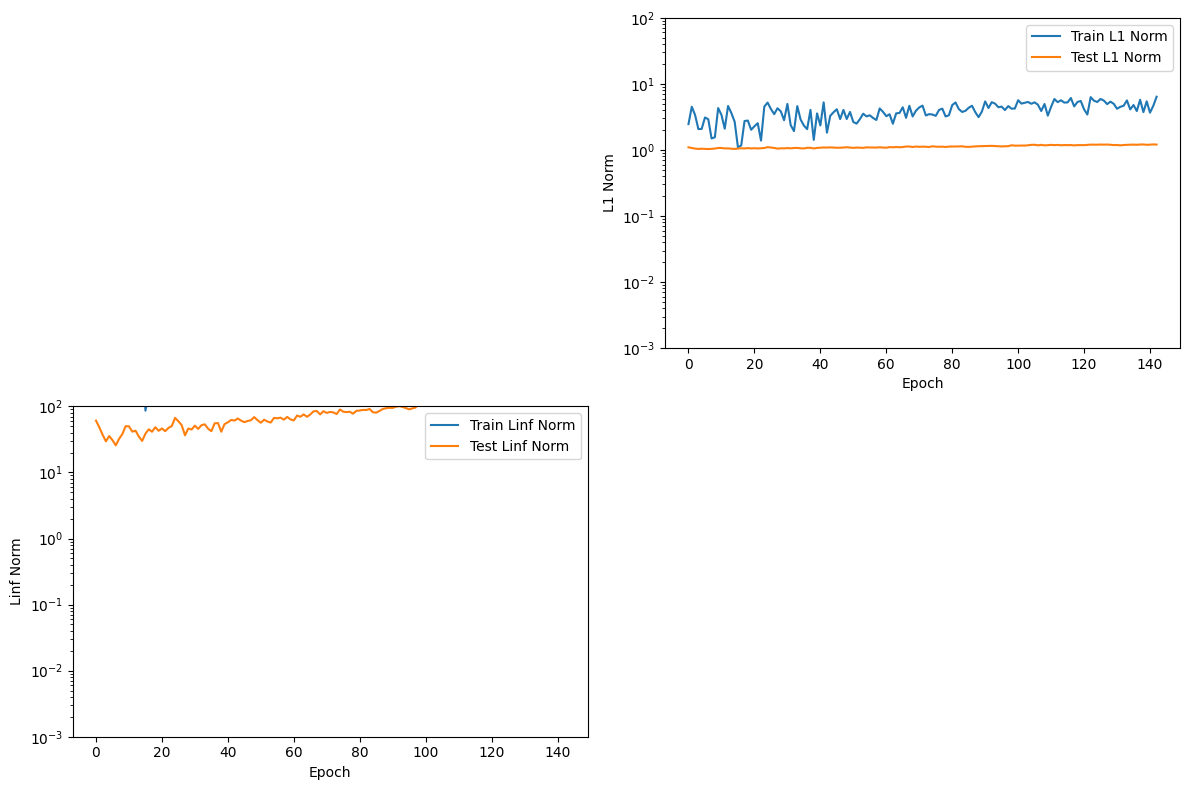

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'MSE Loss')

(1e-07, 1.0)

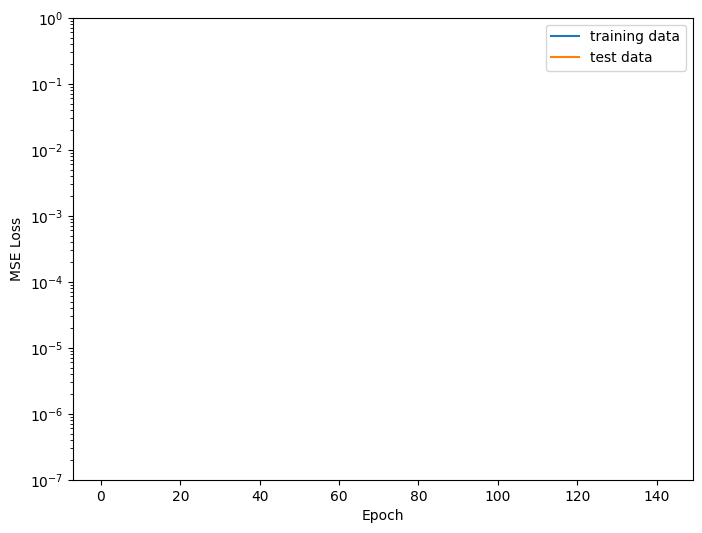

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel(f"{loss_name} Loss")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]
dropout_rate_loaded = var_dict_loaded["dropout_rate"]

# Loading the activation functions with subparameters
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  negative_slope_loaded = var_dict_loaded.get("leakyrelu_slope", 0.01)  # For backwards compatibiltiy with earlier models; default to 0.01 if not present
  hidden_activation_loaded = nn.LeakyReLU(negative_slope=negative_slope_loaded)
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU()
elif hidden_activation_name_loaded == "PReLU":
  init_loaded = var_dict_loaded.get("prelu_init", 0.25)  # Default to 0.25 if not present
  hidden_activation_loaded = nn.PReLU(init=init_loaded)
elif hidden_activation_name_loaded == "Swish":
    class Swish(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)
    hidden_activation_loaded = Swish()
elif hidden_activation_name_loaded == "GELU":
    hidden_activation_loaded = nn.GELU()
elif hidden_activation_name_loaded == "SoftPlus":
  beta_loaded = var_dict_loaded.get("softplus_beta", 1)  # Default to 1 if not present
  hidden_activation_loaded = nn.Softplus(beta=beta_loaded)



# We used to have options here, but since we have a regression problem with continuous output, we only use Linear.
output_activation_loaded = nn.Identity()

# load the network from the .pth file
net_loaded = Net(
    n_layers_loaded, 
    n_units_loaded, 
    hidden_activation_loaded, 
    output_activation_loaded, 
    dropout_rate_loaded
).to(device)

if torch.cuda.is_available():
 net_loaded.load_state_dict(torch.load("net.pth"))
else: 
  net_loaded.load_state_dict(torch.load("net.pth", map_location=torch.device('cpu')))


# Creating the loss function from its name
if loss_name_loaded == "MSE":
    loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
    loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
    loss_fn_loaded = nn.SmoothL1Loss() 
elif loss_name_loaded == "Quantile":
    def quantile_loss(y_pred, y_true, q=0.5):
        e = y_pred - y_true
        return torch.mean(torch.max(q*e, (q-1)*e))
    loss_fn_loaded = quantile_loss

# load the optimizer from the .pth file
if torch.cuda.is_available():
  optimizer_loaded_state_dict = torch.load("optimizer.pth")
else:
  optimizer_loaded_state_dict = torch.load("optimizer.pth", map_location=torch.device('cpu'))

if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
elif optimizer_name_loaded == "Adagrad":
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
if torch.cuda.is_available():
  scheduler_loaded_state_dict = torch.load("scheduler.pth")
else: 
  scheduler_loaded_state_dict = torch.load("scheduler.pth", map_location=torch.device('cpu'))

if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
elif scheduler_name_loaded == "CyclicLR":  # Added CyclicLR
    base_lr_loaded = scheduler_loaded_state_dict["base_lr"]
    max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
    step_size_up_loaded = scheduler_loaded_state_dict["step_size_up"]
    scheduler_loaded = optim.lr_scheduler.CyclicLR(
                    optimizer, base_lr=base_lr_loaded, max_lr=max_lr_loaded, step_size_up=step_size_up_loaded
                )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

<All keys matched successfully>

In [ ]:
# %%script echo skipping

var_dict_loaded["batch_size"]
var_dict_loaded["n_epochs"]
var_dict_loaded["loss_name"]
var_dict_loaded["optimizer_name"]
var_dict_loaded["scheduler_name"]
var_dict_loaded["n_units"]
var_dict_loaded["n_layers"]
var_dict_loaded["hidden_activation_name"]
var_dict_loaded["output_activation_name"]
var_dict_loaded["lr"]
var_dict_loaded["dropout_rate"]

1024

143

'MSE'

'Adam'

'ReduceLROnPlateau'

[3558, 165, 3906, 434, 239, 1274]

6

'PReLU'

'Identity'

1.0435149104684462e-06

0.06388872518840581

In [ ]:
%%script echo skipping

scheduler_loaded_state_dict["mode"]
scheduler_loaded_state_dict["factor"]
scheduler_loaded_state_dict["patience"]
scheduler_loaded_state_dict["threshold"]
scheduler_loaded_state_dict["min_lrs"]


scheduler_loaded_state_dict["base_lr"]
scheduler_loaded_state_dict["max_lr"]
scheduler_loaded_state_dict["step_size_up"]

skipping


In [ ]:
# %%script echo skipping

var_dict
hidden_activation_name_loaded

{'batch_size': 1024,
 'n_epochs': 143,
 'loss_name': 'MSE',
 'optimizer_name': 'Adam',
 'scheduler_name': 'ReduceLROnPlateau',
 'n_units': [3558, 165, 3906, 434, 239, 1274],
 'n_layers': 6,
 'hidden_activation_name': 'PReLU',
 'output_activation_name': 'Identity',
 'lr': 1.0435149104684462e-06,
 'dropout_rate': 0.06388872518840581,
 'prelu_init': 0.20173096656799316}

'PReLU'

In [ ]:
# %%script echo skipping

if hidden_activation_name_loaded == "LeakyReLU":
  var_dict_loaded["leakyrelu_slope"]
if hidden_activation_name_loaded == "PReLU":
  var_dict_loaded["prelu_init"]
elif hidden_activation_name_loaded == "SoftPlus":
  var_dict_loaded["softplus_beta"]

batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
dropout_rate_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
if scheduler_loaded is not None:
  scheduler_loaded
  scheduler_loaded.__dict__ # print the subparameters of the scheduler
train_losses_loaded
test_losses_loaded
train_metrics_loaded
test_metrics_loaded


0.20173096656799316

1024

143

'MSE'

'Adam'

'ReduceLROnPlateau'

[3558, 165, 3906, 434, 239, 1274]

6

'PReLU'

'Identity'

1.0435149104684462e-06

0.06388872518840581

PReLU(num_parameters=1)

Identity()

Net(
  (hidden_activation): PReLU(num_parameters=1)
  (output_activation): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=14, out_features=3558, bias=True)
    (1): Linear(in_features=3558, out_features=165, bias=True)
    (2): Linear(in_features=165, out_features=3906, bias=True)
    (3): Linear(in_features=3906, out_features=434, bias=True)
    (4): Linear(in_features=434, out_features=239, bias=True)
    (5): Linear(in_features=239, out_features=1274, bias=True)
    (6): Linear(in_features=1274, out_features=1, bias=True)
  )
  (dropouts): ModuleList(
    (0-5): 6 x Dropout(p=0.06388872518840581, inplace=False)
  )
)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('hidden_activation', PReLU(num_parameters=1)),
              ('output_activation', Identity()),
              ('layers',
               ModuleList(
                 (0): Linear(in_features=14, out_features=3558, bias=True)
                 (1): Linear(in_features=3558, out_features=165, bias=True)
                 (2): Linear(in_features=165, out_features=3906, bias=True)
                 (3): Linear(in_fea

MSELoss()

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.939104753876406, 0.9991856135686923)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.0435149104684462e-06
    maximize: False
    weight_decay: 0.0009246275300019842
)

{'defaults': {'lr': 1.0435149104684462e-06,
  'betas': (0.939104753876406, 0.9991856135686923),
  'eps': 1e-08,
  'weight_decay': 0.0009246275300019842,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None},
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_grad#Adam.zero_grad',
 'state': defaultdict(dict,
             {Parameter containing:
              tensor([0.2017], device='cuda:0', requires_grad=True): {'step': tensor(12012.),
               'exp_avg': tensor([-4.1726], device='cuda:0'),
               'exp_avg_sq': tensor([9821984.], device='cuda:0')},
              Parameter containing:
              tensor([[ 0.1714, -0.2086, -0.0275,  ..., -0.0289,  0.2055,  0.0674],
                      [-0.1348,  0.1487,  0.1684,  ..., -0.0689, -0.1292,  0.2476],
                      [ 0.0141, -0.2602, -0.0598,  ..., -0.0233, -0.151

{'factor': 0.11351038537346028,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.939104753876406, 0.9991856135686923)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 1.0435149104684462e-06
     maximize: False
     weight_decay: 0.0009246275300019842
 ),
 'min_lrs': [0],
 'patience': 6,
 'verbose': False,
 'cooldown': 0,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.0024087472803278587,
 'threshold_mode': 'rel',
 'best': inf,
 'num_bad_epochs': 0,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 0}

[329.7682469941981,
 60.670210743533865,
 214.82536590971105,
 254.8235335215849,
 260.79753624554803,
 175.55626383200251,
 86.4886414346134,
 224.84707958697152,
 267.4306979967903,
 60.80470394897461,
 109.20048194651883,
 127.78668296042048,
 89.88581229750689,
 271.3847599761963,
 84.37362592629826,
 169.27452567084816,
 105.81718339412912,
 98.01889168270336,
 99.98805096399644,
 89.01658562945198,
 69.45862861902573,
 85.75294198823816,
 76.17052950116326,
 62.06362083058077,
 270.6012640138514,
 127.1333292695887,
 115.46500750732422,
 551.4420475068933,
 241.1380550235524,
 70.30089705559226,
 128.4908230501063,
 120.6162562640022,
 118.83837587639304,
 60.5539454959645,
 294.43668231237075,
 59.91180491189396,
 342.2578929127413,
 61.0743972491096,
 563.453007717716,
 406.1808843563304,
 109.09669203150132,
 60.09493388671875,
 80.60267702564913,
 119.16066909610524,
 102.10882005354938,
 83.34829251870548,
 63.48556739573759,
 59.2889790624282,
 119.14343903305952,
 390.5235

[48.52852320149739,
 48.9826415649414,
 49.63599255777995,
 50.30754013264974,
 49.88135396321615,
 50.35551092529297,
 51.019969673665365,
 50.362748970540366,
 49.90369322102865,
 49.16101432291666,
 49.20761100260417,
 49.7406426961263,
 49.66824965820312,
 50.29563568929037,
 50.882777473958335,
 50.07050185953776,
 49.60693638102214,
 49.903725272623696,
 49.4396,
 49.90802005208333,
 49.684298315429686,
 50.08499295247396,
 49.72314844563802,
 49.54006092122396,
 48.70808123779297,
 49.03478438313802,
 49.49044652913411,
 50.789546048990886,
 49.98793509521485,
 50.17488321533203,
 49.73143297932943,
 50.178494283040365,
 49.73317892252605,
 49.67396096598307,
 50.31385185953776,
 50.7211615234375,
 49.6556697631836,
 49.66030877278646,
 50.97781237386068,
 49.82410281982422,
 49.63029313557943,
 49.35670391845703,
 49.481733984375,
 49.25704972737631,
 49.55820872395833,
 49.83234582926432,
 49.70316097005208,
 49.62724474690755,
 49.22343535563151,
 49.71524131673177,
 50.20495

[{'l1_norm': 2.462433651015338, 'linf_norm': 1471.0911383085588},
 {'l1_norm': 4.505640866790098, 'linf_norm': 3560.750384835451},
 {'l1_norm': 3.3745522125019747, 'linf_norm': 2411.0259789586908},
 {'l1_norm': 2.069184050032672, 'linf_norm': 1078.049683562447},
 {'l1_norm': 2.081270943484587, 'linf_norm': 1092.550133956135},
 {'l1_norm': 3.09893632441128, 'linf_norm': 2132.9980466103048},
 {'l1_norm': 2.917815266093086, 'linf_norm': 1951.53434892577},
 {'l1_norm': 1.490851698572495, 'linf_norm': 488.5837541184033},
 {'l1_norm': 1.5546375295526842, 'linf_norm': 554.0419568942463},
 {'l1_norm': 4.302632949279336, 'linf_norm': 3358.6246256677964},
 {'l1_norm': 3.392723059957168, 'linf_norm': 2423.1418104261734},
 {'l1_norm': 2.0947805477591124, 'linf_norm': 1097.888804274054},
 {'l1_norm': 4.624693239458869, 'linf_norm': 3696.5623760130825},
 {'l1_norm': 3.6214763282102695, 'linf_norm': 2666.720595997081},
 {'l1_norm': 2.6795040133083567, 'linf_norm': 1707.2449429077597},
 {'l1_norm': 1.

[{'l1_norm': 1.096243870608012, 'linf_norm': 60.96088713480631},
 {'l1_norm': 1.0696745104471843, 'linf_norm': 48.35170460205078},
 {'l1_norm': 1.0483041390736898, 'linf_norm': 37.28235263875325},
 {'l1_norm': 1.034365457089742, 'linf_norm': 29.58243853963216},
 {'l1_norm': 1.0437649065653485, 'linf_norm': 35.538838480122884},
 {'l1_norm': 1.0362086419423422, 'linf_norm': 30.843678192138672},
 {'l1_norm': 1.030736967086792, 'linf_norm': 25.750377920532227},
 {'l1_norm': 1.0382170139312743, 'linf_norm': 32.25114989878337},
 {'l1_norm': 1.047505692545573, 'linf_norm': 38.10431731414795},
 {'l1_norm': 1.0712038208643595, 'linf_norm': 50.252415264892576},
 {'l1_norm': 1.070287463315328, 'linf_norm': 49.93542903035482},
 {'l1_norm': 1.0538532957077027, 'linf_norm': 41.546618448384606},
 {'l1_norm': 1.0561909530003866, 'linf_norm': 42.85725467020671},
 {'l1_norm': 1.042140861574809, 'linf_norm': 34.97467788340251},
 {'l1_norm': 1.0367469018300377, 'linf_norm': 29.99719788029989},
 {'l1_norm'

In [ ]:
train_losses_loaded[-1]
test_losses_loaded[-1]
test_metrics_loaded[-1]['l1_norm']
test_metrics_loaded[-1]['linf_norm']
# print(f'Error is {test_metrics_loaded[-1]["l1_norm"] / (3.84e-4)} times bigger than in Dieselhorst et al.')
# print(f'Error is {test_metrics_loaded[-1]["linf_norm"] / (8.14e-3)} times bigger than in Dieselhorst et al.')

64.69356279512293

48.5566469523112

1.2060399401982624

132.6225849258423

### Visualize loaded results

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

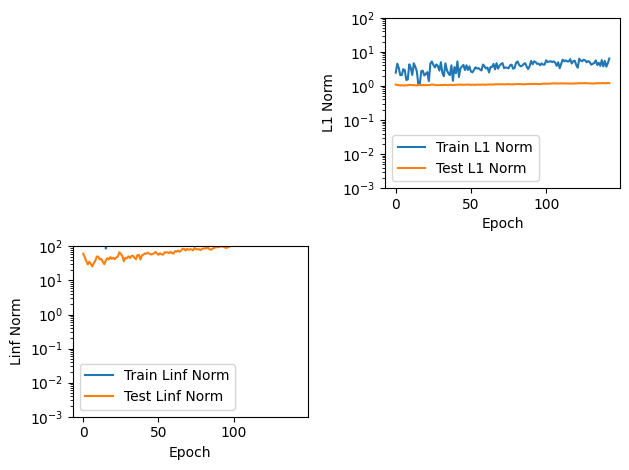

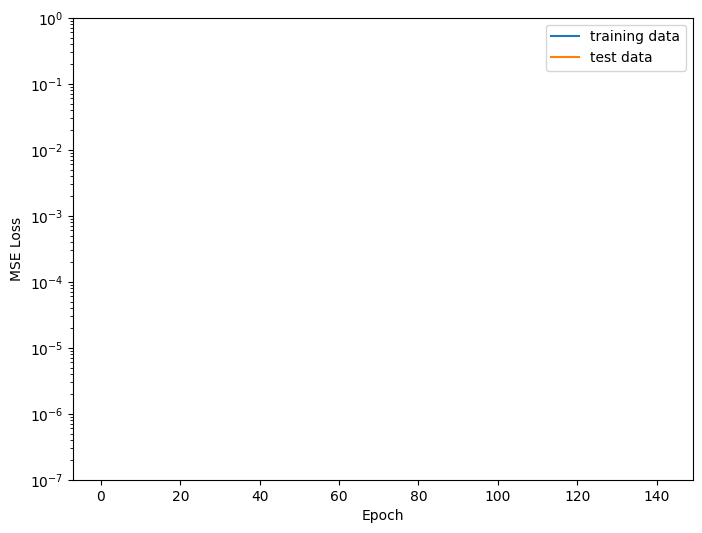

In [ ]:
# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel(f"{loss_name_loaded} Loss")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Counting the number of parameters in the network.

In [ ]:
net_loaded.eval()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(net_loaded)} parameters.')

Net(
  (hidden_activation): PReLU(num_parameters=1)
  (output_activation): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=14, out_features=3558, bias=True)
    (1): Linear(in_features=3558, out_features=165, bias=True)
    (2): Linear(in_features=165, out_features=3906, bias=True)
    (3): Linear(in_features=3906, out_features=434, bias=True)
    (4): Linear(in_features=434, out_features=239, bias=True)
    (5): Linear(in_features=239, out_features=1274, bias=True)
    (6): Linear(in_features=1274, out_features=1, bias=True)
  )
  (dropouts): ModuleList(
    (0-5): 6 x Dropout(p=0.06388872518840581, inplace=False)
  )
)

The model has 3395640 parameters.


## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network. Note that `net` is only available if we have trained the model in this session.

In [ ]:
#%%script echo skipping

# Set the network to evaluation mode
net.eval()

Net(
  (hidden_activation): PReLU(num_parameters=1)
  (output_activation): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=14, out_features=3558, bias=True)
    (1): Linear(in_features=3558, out_features=165, bias=True)
    (2): Linear(in_features=165, out_features=3906, bias=True)
    (3): Linear(in_features=3906, out_features=434, bias=True)
    (4): Linear(in_features=434, out_features=239, bias=True)
    (5): Linear(in_features=239, out_features=1274, bias=True)
    (6): Linear(in_features=1274, out_features=1, bias=True)
  )
  (dropouts): ModuleList(
    (0-5): 6 x Dropout(p=0.06388872518840581, inplace=False)
  )
)

In [ ]:
# Set the network to evaluation mode
net_loaded.eval

<bound method Module.eval of Net(
  (hidden_activation): PReLU(num_parameters=1)
  (output_activation): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=14, out_features=3558, bias=True)
    (1): Linear(in_features=3558, out_features=165, bias=True)
    (2): Linear(in_features=165, out_features=3906, bias=True)
    (3): Linear(in_features=3906, out_features=434, bias=True)
    (4): Linear(in_features=434, out_features=239, bias=True)
    (5): Linear(in_features=239, out_features=1274, bias=True)
    (6): Linear(in_features=1274, out_features=1, bias=True)
  )
  (dropouts): ModuleList(
    (0-5): 6 x Dropout(p=0.06388872518840581, inplace=False)
  )
)>

In [ ]:
for p1, p2 in zip(net.parameters(), net_loaded.parameters()):
    if p1.data.ne(p2.data).sum() > 0:
        print("Parameters are NOT the same.")
        break
else:
    print("Parameters are the same.")

print("Net device:", next(net.parameters()).device)
print("Net_loaded device:", next(net_loaded.parameters()).device)

Parameters are the same.
Net device: cuda:0
Net_loaded device: cuda:0


In [ ]:
#%%script echo skipping

print(list(net.parameters()))

[Parameter containing:
tensor([0.2017], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[ 0.1714, -0.2086, -0.0275,  ..., -0.0289,  0.2055,  0.0674],
        [-0.1348,  0.1487,  0.1684,  ..., -0.0689, -0.1292,  0.2476],
        [ 0.0141, -0.2602, -0.0598,  ..., -0.0233, -0.1510, -0.1562],
        ...,
        [ 0.0950,  0.2630,  0.2416,  ...,  0.0394,  0.1964,  0.0878],
        [ 0.0915, -0.0232,  0.2064,  ..., -0.1801,  0.0730,  0.1871],
        [ 0.0377, -0.2164, -0.0513,  ..., -0.1552,  0.0815,  0.1792]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0751, -0.2434,  0.0402,  ...,  0.1357, -0.0321, -0.1180],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-0.0106,  0.0039, -0.0041,  ..., -0.0065,  0.0139, -0.0117],
        [-0.0014,  0.0015,  0.0052,  ...,  0.0156,  0.0045,  0.0103],
        [ 0.0160, -0.0106,  0.0124,  ...,  0.0112,  0.0148,  0.0165],
        ...,
        [-0.0047,  0.0093, -0.0130,  ...

In [ ]:
print(list(net_loaded.parameters()))

[Parameter containing:
tensor([0.2017], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[ 0.1714, -0.2086, -0.0275,  ..., -0.0289,  0.2055,  0.0674],
        [-0.1348,  0.1487,  0.1684,  ..., -0.0689, -0.1292,  0.2476],
        [ 0.0141, -0.2602, -0.0598,  ..., -0.0233, -0.1510, -0.1562],
        ...,
        [ 0.0950,  0.2630,  0.2416,  ...,  0.0394,  0.1964,  0.0878],
        [ 0.0915, -0.0232,  0.2064,  ..., -0.1801,  0.0730,  0.1871],
        [ 0.0377, -0.2164, -0.0513,  ..., -0.1552,  0.0815,  0.1792]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0751, -0.2434,  0.0402,  ...,  0.1357, -0.0321, -0.1180],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-0.0106,  0.0039, -0.0041,  ..., -0.0065,  0.0139, -0.0117],
        [-0.0014,  0.0015,  0.0052,  ...,  0.0156,  0.0045,  0.0103],
        [ 0.0160, -0.0106,  0.0124,  ...,  0.0112,  0.0148,  0.0165],
        ...,
        [-0.0047,  0.0093, -0.0130,  ...

In [ ]:
rho_example, epsilon_example, vx_example, vy_example, vz_example, Bx_example, By_example, Bz_example, gxx_example, gxy_example, gxz_example, gyy_example, gyz_example, gzz_example = generate_samples(20)

inputs =  generate_input_data(rho_example, epsilon_example, vx_example, vy_example, vz_example, Bx_example, By_example, Bz_example, gxx_example, gxy_example, gxz_example, gyy_example, gyz_example, gzz_example)
inputs


rho.shape:  torch.Size([20])
epsilon.shape:  torch.Size([20])


tensor([[ 5.8377e-01,  3.5042e+01,  2.4076e+01,  5.7846e+01,  7.4569e+01,
         -8.5106e+00, -1.5336e+00,  5.7988e+00,  1.0729e+00,  4.8974e-02,
          7.0864e-02,  9.2059e-01,  8.6702e-02,  1.0328e+00],
        [ 2.6172e+00,  2.4673e+01,  5.5416e+01,  8.9492e+00,  7.5616e+01,
         -9.3517e+00,  4.0517e+00, -4.2435e+00,  9.5271e-01,  7.5467e-02,
          3.8309e-02,  9.7772e-01,  6.4975e-02,  1.0279e+00],
        [ 6.3902e+00,  4.1409e+01,  3.7410e+01, -3.5789e+01,  8.7587e+01,
         -3.0872e+00, -8.3299e+00, -5.5289e+00,  1.0909e+00,  7.3099e-02,
          4.3896e-02,  1.0323e+00,  3.1160e-02,  9.6139e-01],
        [ 6.6427e+00, -2.3341e+01,  1.5950e+02,  5.5226e+01,  2.2358e+02,
          6.2581e+00,  8.2670e+00,  6.5763e+00,  9.6335e-01,  3.7827e-02,
          8.1243e-02,  9.9831e-01,  8.3793e-02,  1.0077e+00],
        [ 1.5121e+00,  1.0021e+02,  6.7436e+00,  6.4227e+01,  1.1664e+02,
         -4.8554e+00, -7.2420e+00,  6.4374e+00,  1.0282e+00,  4.8482e-02,
          8.

In [ ]:
#%%script echo skipping

# Pass the inputs to the network and get the outputs
outputs = [net(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

[tensor([[0.3023]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.1900]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2093]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.1500]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.4054]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2677]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2610]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.4729]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2256]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2286]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2008]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.1993]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2208]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2230]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.3046]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2329]], device='cuda:0', gra

In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

[tensor([[0.3023]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.1900]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2093]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.1500]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.4054]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2677]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2610]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.4729]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2256]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2286]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2008]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.1993]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2208]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2230]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.3046]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.2329]], device='cuda:0', gra

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 5) to trace the model
dummy_input = torch.randn(1, N_INPUTS).to(device)

# Ensure that net_loaded is in evaluation mode.
net_loaded.eval()

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*generate_samples(1))
print("input shape: ", example_input_to_validate_correct_export_and_import.shape)
print("input: ", example_input_to_validate_correct_export_and_import)
print("Output:", net_loaded(example_input_to_validate_correct_export_and_import))

Net(
  (hidden_activation): PReLU(num_parameters=1)
  (output_activation): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=14, out_features=3558, bias=True)
    (1): Linear(in_features=3558, out_features=165, bias=True)
    (2): Linear(in_features=165, out_features=3906, bias=True)
    (3): Linear(in_features=3906, out_features=434, bias=True)
    (4): Linear(in_features=434, out_features=239, bias=True)
    (5): Linear(in_features=239, out_features=1274, bias=True)
    (6): Linear(in_features=1274, out_features=1, bias=True)
  )
  (dropouts): ModuleList(
    (0-5): 6 x Dropout(p=0.06388872518840581, inplace=False)
  )
)

<ipython-input-74-61389beeeffb>:62: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert x.shape[1] == N_INPUTS, f"x must have shape (batch_size, {N_INPUTS})"


rho.shape:  torch.Size([1])
epsilon.shape:  torch.Size([1])
input shape:  torch.Size([1, 14])
input:  tensor([[ 1.0234e+00,  1.8287e+01,  4.0764e+01,  4.6277e+01,  7.8273e+01,
          5.8426e+00, -7.7507e+00,  4.7959e+00,  1.0050e+00,  4.0137e-02,
          9.3720e-02,  9.3847e-01,  2.5888e-02,  9.8740e-01]], device='cuda:0')
Output: tensor([[0.2368]], device='cuda:0', grad_fn=<AddmmBackward0>)
